# Tequila Chemistry Basics

Here we show the basics of the tequila chemistry module.  
In order for this to work you need to have psi4 installed in the same python environment as tequila.  
If you are in a conda environment installing psi4 is easy:
`conda install psi4 -c psi4`  
But better check the psi4 website for up to date instructions.

In some cases problems with the environment where enountered which are suspected to originate from conflicts between psi4 and tequila dependcies. Usually the safest way is to install psi4 **first** and then install tequila

Basic functionality is currently also provided with PySCF which might be easier to install. 

At the moment we only support closed-shell molecules

**There might be issues with psi4 and jupyter, currently the workarround is to reload the kernel before a cell gets executed, or run as a regular python script**

In [1]:
import tequila as tq

## Initialize Molecules

Molecules can be initialized by passing their geometries as string or the name of a `xyz` file.

In [ ]:
import tequila as tq
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g")
print(molecule)

# lets also print some information about the orbitals
# we need it later

print("The Orbitals are:")
for orbital in molecule.orbitals:
    print(orbital)

You can initialize a tequila `QubitHamiltonian` from a molecule with `make_hamiltonian`.
The standard transformation is the `jordan-wigner` transformation.  
You can use other transformations by initializing the molecule with the `transformation` keyword.

In [ ]:
import tequila as tq
H = molecule.make_hamiltonian()
# the LiH Hamiltonian is already quite large, better not print the full thing
print("Hamiltonian has {} terms".format(len(H)))

In [ ]:
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", transformation="bravyi-kitaev")
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

## Setting active spaces

You can define active spaces on your molcule by passing down a dictionary of active orbitals.  
The orbitals are grouped into the irreducible representation of the underlying symmetry group (see the printout of `print(molecule)` above).

Lets take the LiH molecule from above but initialize it with an active space containing the second two A1 orbitals (meaning the first 0A1 orbital is frozen) and the B1 orbital

In [ ]:
import tequila as tq
active_orbitals = {"A1":[1,2], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))

Lets make the active space even smaller, so that we can print out stuff in this tutorial

In [ ]:
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0]}
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)
H = molecule.make_hamiltonian()
print("Hamiltonian has {} terms".format(len(H)))
print(H)

## Computing classical methods with Psi4

We can use psi4 to compute the energies (and sometimes other quantities) with the `compute_energy` function.
Here are some examples. Note that the energies are computed within the active space if one is set.

Note also that not all active spaces can be represented by psi4 which will mean you can/should not use the classical psi4 methods with those (a warning will be printed). You will still get the right active space hamiltonian however.

Active spaces which will not work for psi4 methds are the ones where the orbitals of individual irreps are not in one block ( e.g. {`"A1":[1,3]`} )

In [ ]:
import tequila as tq
active_orbitals = {"A1":[1], "B1":[0], "B2":[0]}
molecule = tq.chemistry.Molecule(name="new", geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

mp2 = molecule.compute_energy(method="mp2")

# Note there are known issues for some methods when the active space as frozen virtuals as is the case here
# detci based methods are fine again 
fci = molecule.compute_energy(method="fci")

# for most coupled-cluster like models you can compute amplitudes
# Amplitudes are computed in c1 and in the full space, this is why the active space troubles from above usually don't hold
# Note that amplitudes are in closed-shell
amplitudes = molecule.compute_amplitudes("mp2")

# you can export a parameter dictionary which holds the indices of the amplitude as keys and values as values
# for this small active space that is only one amplitude for mp2
variables = amplitudes.make_parameter_dictionary()
print(variables)

# similar for ccsd since the singles are 0 due to symmetry (that changes if you change the active space)
amplitudes = molecule.compute_amplitudes("ccsd")
variables = amplitudes.make_parameter_dictionary()
print(variables)

## Hello World H2 optimization with LiH in an active space

Lets do a small hand-constructed VQE like it would be done for the Hydrogen molecule in STO-3G, just that we use our active space LiH molecule from the cell above.
For consistency reasons we initialize everything again.  

Check the `BasicUsage` and `SciPyOptimizers` tutorial notebooks for more information about then

In [ ]:
import tequila as tq
# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# define a hand designed circuit
U = tq.gates.Ry(angle="a", target=0) + tq.gates.X(target=[2,3])
U += tq.gates.X(target=1, control=0)
U += tq.gates.X(target=2, control=0)
U += tq.gates.X(target=3, control=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

# compute a reference value with psi4
fci = molecule.compute_energy(method="fci")

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))


In [ ]:
# some more information from the optimization
result.history.plot("energies", baselines={"fci":fci})

## Unitary Coupled-Cluster Style Construction

Here we show how to initialize in the style of unitary coupled-cluster.  
In this example we are gonna compute the `mp2` amplitudes and build a UCC type circuit from them.  
Here we use the cc2 amplitudes only to define an order on the trotterized gates and remove small amplitudes as classical prescreening.

We use again an active space to make the computation fast.

First we start with the manual construction and then show how to use in build convenience functions of tequila to.

An important function is the `make_excitation_generator` function of the molecule.  
This initializes a `QubitHamiltonian` which can be used to define a unitary gate which acts as excitation operation of electrons.

$$\displaystyle
U(\theta) = e^{-i\frac{\theta}{2} G_{iajbkc\dots}}
$$

In fermionic language the generator is defined as

$$
G_{ia,jb,jc,\dots} =  i ( a^\dagger_a a_i a^\dagger_b a_j a^\dagger_c a_k \dots - h.c. )
$$

The `make_excitation_generator` function gives back this generator in the qubit representation (depends on the chosen `transformation` of the molecule) and takes the indices as list of tuples  
  
$$
\text{make_excitation_generator(indices=[(a,i),(b,j),...])} = G_{ia,jb,jc,\dots}
$$

### Manual Construction

In [ ]:
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# compute classical amplitudes
amplitudes = molecule.compute_amplitudes(method="mp2")

# in this example there is only one closed-shell MP2 amplitude, therefore manual construction is reasonable in this tutorial
# first we make a dictionary out of the non-zero MP2 amplitudes
ampdict = amplitudes.make_parameter_dictionary(threshold=threshold)
print(ampdict)
# lets get the indices of the only amplitude which is there manually
indices = list(ampdict.keys())[0]

# the (1, 0, 1, 0) index in closed shell leads to the (2, 0, 3, 1) and (3, 1, 2, 0) excitations on the qubits
# but first we need to initialize the hartree fock state
U = molecule.prepare_reference()

# now add the two 2-electron excitations 
# for this we define the generators and build trotterized gates with them
# note that the two generators are actually the same
# we sum them up since we want to parametrize them with the same variable which we will call "a"
generator = molecule.make_excitation_generator(indices=[(3, 1),(2, 0)]) + molecule.make_excitation_generator(indices=[(3, 1),(2, 0)])
U += tq.gates.Trotterized(generators=[generators], angles=["a"], steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))



### Automatic Construction

In [ ]:
import tequila as tq
threshold = 1.e-6

# define the active space
active_orbitals = {"A1":[1], "B1":[0]}

# define the molecule
molecule = tq.chemistry.Molecule(geometry = "H 0.0 0.0 0.0\nLi 0.0 0.0 1.6", basis_set="sto-3g", active_orbitals=active_orbitals)

# make the hamiltonian
H = molecule.make_hamiltonian()

# make the UCCSD ansatz (note that this will be without singles since it starts from mp2)
U = molecule.make_uccsd_ansatz(initial_amplitudes="mp2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# optimize
result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()})

print("VQE : {:+2.8}f".format(result.energy))
print("FCI : {:+2.8}f".format(fci))
    
    

### Pi System of Benzene
Lets repeat the last cell with the pi system of the benzene molecule

In [1]:
import tequila as tq
threshold = 1.e-6
active = {"B1u": [0], "B3g": [0, 1], "B2g": [0], "Au": [0], "b1u": [1]}
molecule = tq.quantumchemistry.Molecule(geometry="data/benzene.xyz", basis_set='sto-3g', active_orbitals=active)
H = molecule.make_hamiltonian()

# make the UCCSD ansatz
U = molecule.make_uccsd_ansatz(initial_amplitudes="cc2", threshold=threshold, trotter_steps=1)

# define the expectationvalue
E = tq.ExpectationValue(H=H, U=U)

# compute reference energies
fci = molecule.compute_energy("fci")
cisd = molecule.compute_energy("detci", options={"detci__ex_level": 2})

# optimize
result = tq.minimize(objective=E, method="BFGS", gradient="2-point", method_options={"eps":1.e-3}, initial_values={k:0.0 for k in E.extract_variables()})

print("VQE : {:+2.8}f".format(result.energy))
print("CISD: {:+2.8}f".format(cisd))
print("FCI : {:+2.8}f".format(fci))

There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for hf.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for fci.
There are known issues with some psi4 methods and frozen virtual orbitals. Proceed with fingers crossed for detci.
ObjectiveType is <class 'tequila.objective.objective.Objective'>
Starting BFGS optimization
Objective: 1 expectationvalues
Gradients: 2-point
Hessian: None

backend: <class 'tequila.simulators.simulator_qulacs.BackendExpectationValueQulacs'>
samples: None
22 active variables
E= -227.88792153297504  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0

E= -227.88772699368133  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.001, (4, 2, 4, 2): 0.0, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E= -227.88781001304642  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2, 5, 2): 0.0, (4, 2, 3, 1): 0.0, (4, 0): 0.0, (5, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (3, 1, 4, 2): 0.0, (4, 1, 5, 0): 0.0, (3, 2, 4, 1): 0.0, (5, 1, 4, 0): 0.0, (5, 0, 4, 1): 0.0, (5, 0, 3, 2): 0.0, (4, 0, 4, 0): 0.0, (5, 2, 3, 0): 0.0, (4, 1, 4, 1): 0.0, (4, 2, 4, 2): 0.001, (3, 2, 3, 2): 0.0, (4, 1, 3, 2): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (4, 0, 5, 1): 0.0}  samples= None
E= -227.8877269810726  angles= {(3, 0, 5, 2): 0.0, (3, 2, 5, 0): 0.0, (5, 2,

E= -226.98666157196465  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 0): -0.0002797510205709841, (5, 0, 5, 0): -0.08711814404907636, (3, 1, 3, 1): -0.11151888708127444, (3, 1, 4, 2): 0.3530088013974364, (4, 1, 5, 0): -0.04039760713681062, (3, 2, 4, 1): -0.2734920682314623, (5, 1, 4, 0): -0.16205490697984715, (5, 0, 4, 1): -0.04039760713681062, (5, 0, 3, 2): 0.03545315459518861, (4, 0, 4, 0): -0.11265558811146548, (5, 2, 3, 0): 0.1572695008746905, (4, 1, 4, 1): -0.19453929371593404, (4, 2, 4, 2): -0.11151992862323823, (3, 2, 3, 2): -0.19455190243888865, (4, 1, 3, 2): -0.2734920682314623, (3, 0, 3, 0): -0.11265259740866895, (5, 1, 5, 1): -0.11507963489520989, (4, 0, 5, 1): -0.16205490697984715}  samples= None
E= -226.98653821418802  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 

E= -226.98622767253497  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 0): -0.0002797510205709841, (5, 0, 5, 0): -0.08811814404907636, (3, 1, 3, 1): -0.11151888708127444, (3, 1, 4, 2): 0.3530088013974364, (4, 1, 5, 0): -0.04039760713681062, (3, 2, 4, 1): -0.2734920682314623, (5, 1, 4, 0): -0.16205490697984715, (5, 0, 4, 1): -0.04039760713681062, (5, 0, 3, 2): 0.03545315459518861, (4, 0, 4, 0): -0.11265558811146548, (5, 2, 3, 0): 0.1572695008746905, (4, 1, 4, 1): -0.19353929371593404, (4, 2, 4, 2): -0.11151992862323823, (3, 2, 3, 2): -0.19455190243888865, (4, 1, 3, 2): -0.2734920682314623, (3, 0, 3, 0): -0.11265259740866895, (5, 1, 5, 1): -0.11507963489520989, (4, 0, 5, 1): -0.16205490697984715}  samples= None
E= -226.9865372541076  angles= {(3, 0, 5, 2): 0.1572695008746905, (3, 2, 5, 0): 0.03545315459518861, (5, 2, 5, 2): -0.11507814411970685, (4, 2, 3, 1): 0.3530088013974364, (4, 0

E= -227.92456508897956  angles= {(3, 0, 5, 2): 0.016038618246392595, (3, 2, 5, 0): 0.00461557459660049, (5, 2, 5, 2): -0.011735870030578549, (4, 2, 3, 1): 0.036000453818069295, (4, 0): -2.852949744243007e-05, (5, 0, 5, 0): -0.00898644215899085, (3, 1, 3, 1): -0.01137289078436292, (3, 1, 4, 2): 0.036000453818069295, (4, 1, 5, 0): -0.0041198184983832495, (3, 2, 4, 1): -0.027891198556519947, (5, 1, 4, 0): -0.01652664231493541, (5, 0, 4, 1): -0.0041198184983832495, (5, 0, 3, 2): 0.00361557459660049, (4, 0, 4, 0): -0.011488813539773973, (5, 2, 3, 0): 0.016038618246392595, (4, 1, 4, 1): -0.019839456782652223, (4, 2, 4, 2): -0.011372997002630619, (3, 2, 3, 2): -0.019840742642230326, (4, 1, 3, 2): -0.027891198556519947, (3, 0, 3, 0): -0.01148850854268188, (5, 1, 5, 1): -0.011736022062466813, (4, 0, 5, 1): -0.01652664231493541}  samples= None
E= -227.92438120937683  angles= {(3, 0, 5, 2): 0.016038618246392595, (3, 2, 5, 0): 0.00361557459660049, (5, 2, 5, 2): -0.010735870030578548, (4, 2, 3, 1):

E= -227.92434875694224  angles= {(3, 0, 5, 2): 0.016038618246392595, (3, 2, 5, 0): 0.00361557459660049, (5, 2, 5, 2): -0.011735870030578549, (4, 2, 3, 1): 0.036000453818069295, (4, 0): -2.852949744243007e-05, (5, 0, 5, 0): -0.00898644215899085, (3, 1, 3, 1): -0.01137289078436292, (3, 1, 4, 2): 0.036000453818069295, (4, 1, 5, 0): -0.0041198184983832495, (3, 2, 4, 1): -0.027891198556519947, (5, 1, 4, 0): -0.01652664231493541, (5, 0, 4, 1): -0.0031198184983832495, (5, 0, 3, 2): 0.00361557459660049, (4, 0, 4, 0): -0.011488813539773973, (5, 2, 3, 0): 0.016038618246392595, (4, 1, 4, 1): -0.019839456782652223, (4, 2, 4, 2): -0.011372997002630619, (3, 2, 3, 2): -0.019840742642230326, (4, 1, 3, 2): -0.027891198556519947, (3, 0, 3, 0): -0.01148850854268188, (5, 1, 5, 1): -0.011736022062466813, (4, 0, 5, 1): -0.01652664231493541}  samples= None
E= -227.92456504797573  angles= {(3, 0, 5, 2): 0.016038618246392595, (3, 2, 5, 0): 0.00361557459660049, (5, 2, 5, 2): -0.011735870030578549, (4, 2, 3, 1):

E= -227.92438283296332  angles= {(3, 0, 5, 2): 0.016038618246392595, (3, 2, 5, 0): 0.00361557459660049, (5, 2, 5, 2): -0.011735870030578549, (4, 2, 3, 1): 0.036000453818069295, (4, 0): -2.852949744243007e-05, (5, 0, 5, 0): -0.00898644215899085, (3, 1, 3, 1): -0.01137289078436292, (3, 1, 4, 2): 0.036000453818069295, (4, 1, 5, 0): -0.0041198184983832495, (3, 2, 4, 1): -0.027891198556519947, (5, 1, 4, 0): -0.01652664231493541, (5, 0, 4, 1): -0.0041198184983832495, (5, 0, 3, 2): 0.00361557459660049, (4, 0, 4, 0): -0.011488813539773973, (5, 2, 3, 0): 0.016038618246392595, (4, 1, 4, 1): -0.019839456782652223, (4, 2, 4, 2): -0.011372997002630619, (3, 2, 3, 2): -0.019840742642230326, (4, 1, 3, 2): -0.027891198556519947, (3, 0, 3, 0): -0.01148850854268188, (5, 1, 5, 1): -0.011736022062466813, (4, 0, 5, 1): -0.015526642314935408}  samples= None
E= -227.97587219115377  angles= {(3, 0, 5, 2): 0.05188362745949063, (3, 2, 5, 0): 0.038696555272062, (5, 2, 5, 2): -0.045489129617491096, (4, 2, 3, 1): 0

E= -227.97589086572157  angles= {(3, 0, 5, 2): 0.05188362745949063, (3, 2, 5, 0): 0.038696555272062, (5, 2, 5, 2): -0.045489129617491096, (4, 2, 3, 1): 0.05014216941646648, (4, 0): -0.00013290392263026646, (5, 0, 5, 0): -0.04074348549779582, (3, 1, 3, 1): -0.037925256587992916, (3, 1, 4, 2): 0.05121428434654047, (4, 1, 5, 0): -0.04083588586137032, (3, 2, 4, 1): -0.0009682035437380276, (5, 1, 4, 0): -0.054058411253988733, (5, 0, 4, 1): -0.040826433718010514, (5, 0, 3, 2): 0.038684254233053744, (4, 0, 4, 0): -0.04547242641524549, (5, 2, 3, 0): 0.051878666753063546, (4, 1, 4, 1): -0.0891003813490261, (4, 2, 4, 2): -0.03792524196738341, (3, 2, 3, 2): -0.088872560456033, (4, 1, 3, 2): -0.0008386380376790778, (3, 0, 3, 0): -0.04535521125209002, (5, 1, 5, 1): -0.04559390182564036, (4, 0, 5, 1): -0.05405913498645873}  samples= None
E= -227.97582029157167  angles= {(3, 0, 5, 2): 0.05188362745949063, (3, 2, 5, 0): 0.038696555272062, (5, 2, 5, 2): -0.045489129617491096, (4, 2, 3, 1): 0.0501421694

E= -227.97577712668883  angles= {(3, 0, 5, 2): 0.05188362745949063, (3, 2, 5, 0): 0.038696555272062, (5, 2, 5, 2): -0.045489129617491096, (4, 2, 3, 1): 0.05014216941646648, (4, 0): -0.00013290392263026646, (5, 0, 5, 0): -0.04074348549779582, (3, 1, 3, 1): -0.037925256587992916, (3, 1, 4, 2): 0.05021428434654047, (4, 1, 5, 0): -0.04083588586137032, (3, 2, 4, 1): -0.0009682035437380276, (5, 1, 4, 0): -0.054058411253988733, (5, 0, 4, 1): -0.040826433718010514, (5, 0, 3, 2): 0.038684254233053744, (4, 0, 4, 0): -0.04547242641524549, (5, 2, 3, 0): 0.051878666753063546, (4, 1, 4, 1): -0.0891003813490261, (4, 2, 4, 2): -0.03792524196738341, (3, 2, 3, 2): -0.087872560456033, (4, 1, 3, 2): -0.0008386380376790778, (3, 0, 3, 0): -0.04535521125209002, (5, 1, 5, 1): -0.04559390182564036, (4, 0, 5, 1): -0.05405913498645873}  samples= None
E= -227.97595101325697  angles= {(3, 0, 5, 2): 0.05188362745949063, (3, 2, 5, 0): 0.038696555272062, (5, 2, 5, 2): -0.045489129617491096, (4, 2, 3, 1): 0.0501421694

E= -227.96746769177494  angles= {(3, 0, 5, 2): 0.07784101819050153, (3, 2, 5, 0): 0.09157838128646531, (5, 2, 5, 2): -0.022574706032445067, (4, 2, 3, 1): 0.12433689625838715, (4, 0): -0.00038565569137247115, (5, 0, 5, 0): -0.0454587582735263, (3, 1, 3, 1): -0.028368768186871774, (3, 1, 4, 2): 0.12319378360703517, (4, 1, 5, 0): -0.0954436979844007, (3, 2, 4, 1): 0.05659765197012563, (5, 1, 4, 0): -0.07135407540258912, (5, 0, 4, 1): -0.09537770407479579, (5, 0, 3, 2): 0.09148168031237836, (4, 0, 4, 0): -0.03967779966452591, (5, 2, 3, 0): 0.07775760688082878, (4, 1, 4, 1): -0.21084919595998053, (4, 2, 4, 2): -0.02838522852048221, (3, 2, 3, 2): -0.20644853036766764, (4, 1, 3, 2): 0.057489125533973555, (3, 0, 3, 0): -0.03675177145653337, (5, 1, 5, 1): -0.025060548226381037, (4, 0, 5, 1): -0.07140034647427146}  samples= None
E= -227.96758634847913  angles= {(3, 0, 5, 2): 0.07784101819050153, (3, 2, 5, 0): 0.09157838128646531, (5, 2, 5, 2): -0.022574706032445067, (4, 2, 3, 1): 0.1233368962583

E= -227.96755444768837  angles= {(3, 0, 5, 2): 0.07784101819050153, (3, 2, 5, 0): 0.09157838128646531, (5, 2, 5, 2): -0.022574706032445067, (4, 2, 3, 1): 0.12333689625838715, (4, 0): -0.00038565569137247115, (5, 0, 5, 0): -0.0454587582735263, (3, 1, 3, 1): -0.028368768186871774, (3, 1, 4, 2): 0.12319378360703517, (4, 1, 5, 0): -0.0954436979844007, (3, 2, 4, 1): 0.05659765197012563, (5, 1, 4, 0): -0.07135407540258912, (5, 0, 4, 1): -0.09537770407479579, (5, 0, 3, 2): 0.09148168031237836, (4, 0, 4, 0): -0.03867779966452591, (5, 2, 3, 0): 0.07775760688082878, (4, 1, 4, 1): -0.21084919595998053, (4, 2, 4, 2): -0.02838522852048221, (3, 2, 3, 2): -0.20644853036766764, (4, 1, 3, 2): 0.057489125533973555, (3, 0, 3, 0): -0.03675177145653337, (5, 1, 5, 1): -0.025060548226381037, (4, 0, 5, 1): -0.07140034647427146}  samples= None
E= -227.96781616960936  angles= {(3, 0, 5, 2): 0.07784101819050153, (3, 2, 5, 0): 0.09157838128646531, (5, 2, 5, 2): -0.022574706032445067, (4, 2, 3, 1): 0.1233368962583

E= -227.9861031826799  angles= {(3, 0, 5, 2): 0.06291250930354048, (3, 2, 5, 0): 0.061165200786330996, (5, 2, 5, 2): -0.0357531560420708, (4, 2, 3, 1): 0.08124144292636633, (4, 0): -0.00024029412306370682, (5, 0, 5, 0): -0.04274692979020953, (3, 1, 3, 1): -0.03386485689249959, (3, 1, 4, 2): 0.08122211108547146, (4, 1, 5, 0): -0.06403787537981065, (3, 2, 4, 1): 0.023490611492534397, (5, 1, 4, 0): -0.06140706344657581, (5, 0, 4, 1): -0.06400439954063206, (5, 0, 3, 2): 0.06111703955932178, (4, 0, 4, 0): -0.04301038181198317, (5, 2, 3, 0): 0.06287421618544085, (4, 1, 4, 1): -0.14082951332966, (4, 2, 4, 2): -0.03387184221750714, (3, 2, 3, 2): -0.13882871719353565, (4, 1, 3, 2): 0.023943899595847515, (3, 0, 3, 0): -0.041699746727906106, (5, 1, 5, 1): -0.03686960695890791, (4, 0, 5, 1): -0.061427139517949564}  samples= None
E= -227.98621701505655  angles= {(3, 0, 5, 2): 0.06391250930354048, (3, 2, 5, 0): 0.061165200786330996, (5, 2, 5, 2): -0.0357531560420708, (4, 2, 3, 1): 0.0812414429263663

E= -227.98619401221112  angles= {(3, 0, 5, 2): 0.06291250930354048, (3, 2, 5, 0): 0.061165200786330996, (5, 2, 5, 2): -0.0357531560420708, (4, 2, 3, 1): 0.08124144292636633, (4, 0): -0.00024029412306370682, (5, 0, 5, 0): -0.04274692979020953, (3, 1, 3, 1): -0.03386485689249959, (3, 1, 4, 2): 0.08122211108547146, (4, 1, 5, 0): -0.06403787537981065, (3, 2, 4, 1): 0.024490611492534398, (5, 1, 4, 0): -0.06140706344657581, (5, 0, 4, 1): -0.06400439954063206, (5, 0, 3, 2): 0.06111703955932178, (4, 0, 4, 0): -0.04301038181198317, (5, 2, 3, 0): 0.06287421618544085, (4, 1, 4, 1): -0.14082951332966, (4, 2, 4, 2): -0.03387184221750714, (3, 2, 3, 2): -0.13882871719353565, (4, 1, 3, 2): 0.023943899595847515, (3, 0, 3, 0): -0.041699746727906106, (5, 1, 5, 1): -0.03686960695890791, (4, 0, 5, 1): -0.061427139517949564}  samples= None
E= -227.98594924905296  angles= {(3, 0, 5, 2): 0.06291250930354048, (3, 2, 5, 0): 0.061165200786330996, (5, 2, 5, 2): -0.0357531560420708, (4, 2, 3, 1): 0.081241442926366

E= -227.9860866286116  angles= {(3, 0, 5, 2): 0.06291250930354048, (3, 2, 5, 0): 0.061165200786330996, (5, 2, 5, 2): -0.0357531560420708, (4, 2, 3, 1): 0.08124144292636633, (4, 0): -0.00024029412306370682, (5, 0, 5, 0): -0.04274692979020953, (3, 1, 3, 1): -0.03386485689249959, (3, 1, 4, 2): 0.08122211108547146, (4, 1, 5, 0): -0.06403787537981065, (3, 2, 4, 1): 0.023490611492534397, (5, 1, 4, 0): -0.06140706344657581, (5, 0, 4, 1): -0.06400439954063206, (5, 0, 3, 2): 0.06111703955932178, (4, 0, 4, 0): -0.04301038181198317, (5, 2, 3, 0): 0.06287421618544085, (4, 1, 4, 1): -0.14082951332966, (4, 2, 4, 2): -0.03387184221750714, (3, 2, 3, 2): -0.13882871719353565, (4, 1, 3, 2): 0.023943899595847515, (3, 0, 3, 0): -0.040699746727906105, (5, 1, 5, 1): -0.03686960695890791, (4, 0, 5, 1): -0.061427139517949564}  samples= None
E= -227.9860816349578  angles= {(3, 0, 5, 2): 0.06291250930354048, (3, 2, 5, 0): 0.061165200786330996, (5, 2, 5, 2): -0.0357531560420708, (4, 2, 3, 1): 0.08124144292636633

E= -227.99267403261973  angles= {(3, 0, 5, 2): 0.08928361506312527, (3, 2, 5, 0): 0.06832164642968115, (5, 2, 5, 2): -0.025600544245769657, (4, 2, 3, 1): 0.11033347487639153, (4, 0): -0.00033221143351189496, (5, 0, 5, 0): -0.044732516787990256, (3, 1, 3, 1): -0.027677598324304695, (3, 1, 4, 2): 0.11014607690961849, (4, 1, 5, 0): -0.06635332085472963, (3, 2, 4, 1): 0.05836634077724001, (5, 1, 4, 0): -0.08950953347075809, (5, 0, 4, 1): -0.06629495741767509, (5, 0, 3, 2): 0.06823513561744972, (4, 0, 4, 0): -0.040263017404415624, (5, 2, 3, 0): 0.08920901396892379, (4, 1, 4, 1): -0.19767400140132846, (4, 2, 4, 2): -0.02766988203387804, (3, 2, 3, 2): -0.19407543936693855, (4, 1, 3, 2): 0.05928648807525715, (3, 0, 3, 0): -0.03753460805636938, (5, 1, 5, 1): -0.027916302287260816, (4, 0, 5, 1): -0.08954979449613326}  samples= None
E= -227.99272062451445  angles= {(3, 0, 5, 2): 0.08928361506312527, (3, 2, 5, 0): 0.06832164642968115, (5, 2, 5, 2): -0.025600544245769657, (4, 2, 3, 1): 0.1103334748

E= -227.99274091720116  angles= {(3, 0, 5, 2): 0.08928361506312527, (3, 2, 5, 0): 0.06832164642968115, (5, 2, 5, 2): -0.025600544245769657, (4, 2, 3, 1): 0.11033347487639153, (4, 0): -0.00033221143351189496, (5, 0, 5, 0): -0.04573251678799026, (3, 1, 3, 1): -0.027677598324304695, (3, 1, 4, 2): 0.11014607690961849, (4, 1, 5, 0): -0.06635332085472963, (3, 2, 4, 1): 0.05836634077724001, (5, 1, 4, 0): -0.08950953347075809, (5, 0, 4, 1): -0.06629495741767509, (5, 0, 3, 2): 0.06823513561744972, (4, 0, 4, 0): -0.040263017404415624, (5, 2, 3, 0): 0.08920901396892379, (4, 1, 4, 1): -0.19667400140132846, (4, 2, 4, 2): -0.02766988203387804, (3, 2, 3, 2): -0.19407543936693855, (4, 1, 3, 2): 0.05928648807525715, (3, 0, 3, 0): -0.03753460805636938, (5, 1, 5, 1): -0.027916302287260816, (4, 0, 5, 1): -0.08954979449613326}  samples= None
E= -227.99272089085403  angles= {(3, 0, 5, 2): 0.08928361506312527, (3, 2, 5, 0): 0.06832164642968115, (5, 2, 5, 2): -0.025600544245769657, (4, 2, 3, 1): 0.11033347487

E= -227.9902922391494  angles= {(3, 0, 5, 2): 0.08105166172352592, (3, 2, 5, 0): 0.05321934159561182, (5, 2, 5, 2): -0.047472587923958386, (4, 2, 3, 1): 0.11304431807358181, (4, 0): -0.0015875788983468102, (5, 0, 5, 0): -0.08864067623605273, (3, 1, 3, 1): -0.03286754678628608, (3, 1, 4, 2): 0.11260944402872167, (4, 1, 5, 0): -0.06402024571540171, (3, 2, 4, 1): 0.06245389199296386, (5, 1, 4, 0): -0.07120478435219527, (5, 0, 4, 1): -0.06405950758376747, (5, 0, 3, 2): 0.05214150806979283, (4, 0, 4, 0): -0.04498740122696637, (5, 2, 3, 0): 0.08097660000301994, (4, 1, 4, 1): -0.19484807911903188, (4, 2, 4, 2): -0.03263124739667978, (3, 2, 3, 2): -0.19275269042919047, (4, 1, 3, 2): 0.06373653934905547, (3, 0, 3, 0): -0.0463201067775266, (5, 1, 5, 1): -0.045583257418922225, (4, 0, 5, 1): -0.07117230161579599}  samples= None
E= -227.99020781148437  angles= {(3, 0, 5, 2): 0.08105166172352592, (3, 2, 5, 0): 0.05221934159561182, (5, 2, 5, 2): -0.046472587923958385, (4, 2, 3, 1): 0.1130443180735818

E= -227.9902344942629  angles= {(3, 0, 5, 2): 0.08105166172352592, (3, 2, 5, 0): 0.05221934159561182, (5, 2, 5, 2): -0.047472587923958386, (4, 2, 3, 1): 0.11304431807358181, (4, 0): -0.0015875788983468102, (5, 0, 5, 0): -0.08864067623605273, (3, 1, 3, 1): -0.03286754678628608, (3, 1, 4, 2): 0.11260944402872167, (4, 1, 5, 0): -0.06402024571540171, (3, 2, 4, 1): 0.06245389199296386, (5, 1, 4, 0): -0.07120478435219527, (5, 0, 4, 1): -0.06305950758376747, (5, 0, 3, 2): 0.05214150806979283, (4, 0, 4, 0): -0.04498740122696637, (5, 2, 3, 0): 0.08097660000301994, (4, 1, 4, 1): -0.19484807911903188, (4, 2, 4, 2): -0.03263124739667978, (3, 2, 3, 2): -0.19275269042919047, (4, 1, 3, 2): 0.06373653934905547, (3, 0, 3, 0): -0.0463201067775266, (5, 1, 5, 1): -0.045583257418922225, (4, 0, 5, 1): -0.07117230161579599}  samples= None
E= -227.99029202665608  angles= {(3, 0, 5, 2): 0.08105166172352592, (3, 2, 5, 0): 0.05221934159561182, (5, 2, 5, 2): -0.047472587923958386, (4, 2, 3, 1): 0.1130443180735818

E= -227.99006705552057  angles= {(3, 0, 5, 2): 0.08105166172352592, (3, 2, 5, 0): 0.05221934159561182, (5, 2, 5, 2): -0.047472587923958386, (4, 2, 3, 1): 0.11304431807358181, (4, 0): -0.0015875788983468102, (5, 0, 5, 0): -0.08864067623605273, (3, 1, 3, 1): -0.03286754678628608, (3, 1, 4, 2): 0.11260944402872167, (4, 1, 5, 0): -0.06402024571540171, (3, 2, 4, 1): 0.06245389199296386, (5, 1, 4, 0): -0.07120478435219527, (5, 0, 4, 1): -0.06405950758376747, (5, 0, 3, 2): 0.05214150806979283, (4, 0, 4, 0): -0.04498740122696637, (5, 2, 3, 0): 0.08097660000301994, (4, 1, 4, 1): -0.19484807911903188, (4, 2, 4, 2): -0.03263124739667978, (3, 2, 3, 2): -0.19275269042919047, (4, 1, 3, 2): 0.06373653934905547, (3, 0, 3, 0): -0.0463201067775266, (5, 1, 5, 1): -0.045583257418922225, (4, 0, 5, 1): -0.07017230161579599}  samples= None
E= -227.99385660485095  angles= {(3, 0, 5, 2): 0.0863682213648993, (3, 2, 5, 0): 0.06261892240981395, (5, 2, 5, 2): -0.033346654515852635, (4, 2, 3, 1): 0.1112935356114238

E= -227.99385889296158  angles= {(3, 0, 5, 2): 0.0863682213648993, (3, 2, 5, 0): 0.06261892240981395, (5, 2, 5, 2): -0.033346654515852635, (4, 2, 3, 1): 0.11129353561142383, (4, 0): -0.0007768070531605044, (5, 0, 5, 0): -0.060928688643775396, (3, 1, 3, 1): -0.029515648470603808, (3, 1, 4, 2): 0.11201849256592492, (4, 1, 5, 0): -0.0655270488536525, (3, 2, 4, 1): 0.059813970588037405, (5, 1, 4, 0): -0.08302680111959748, (5, 0, 4, 1): -0.06550325998091681, (5, 0, 3, 2): 0.062535484708554, (4, 0, 4, 0): -0.04193618515161467, (5, 2, 3, 0): 0.0862934571372385, (4, 1, 4, 1): -0.196673184745353, (4, 2, 4, 2): -0.02942697815877089, (3, 2, 3, 2): -0.19360698021048353, (4, 1, 3, 2): 0.06086249936992825, (3, 0, 3, 0): -0.04064604304036318, (5, 1, 5, 1): -0.03417315622372801, (4, 0, 5, 1): -0.0830412995226747}  samples= None
E= -227.9938490214236  angles= {(3, 0, 5, 2): 0.0863682213648993, (3, 2, 5, 0): 0.06261892240981395, (5, 2, 5, 2): -0.033346654515852635, (4, 2, 3, 1): 0.11129353561142383, (4,

E= -227.99386801437527  angles= {(3, 0, 5, 2): 0.0863682213648993, (3, 2, 5, 0): 0.06261892240981395, (5, 2, 5, 2): -0.033346654515852635, (4, 2, 3, 1): 0.11129353561142383, (4, 0): -0.0007768070531605044, (5, 0, 5, 0): -0.060928688643775396, (3, 1, 3, 1): -0.029515648470603808, (3, 1, 4, 2): 0.11101849256592491, (4, 1, 5, 0): -0.0655270488536525, (3, 2, 4, 1): 0.059813970588037405, (5, 1, 4, 0): -0.08302680111959748, (5, 0, 4, 1): -0.06550325998091681, (5, 0, 3, 2): 0.062535484708554, (4, 0, 4, 0): -0.04193618515161467, (5, 2, 3, 0): 0.0862934571372385, (4, 1, 4, 1): -0.196673184745353, (4, 2, 4, 2): -0.02942697815877089, (3, 2, 3, 2): -0.19260698021048353, (4, 1, 3, 2): 0.06086249936992825, (3, 0, 3, 0): -0.04064604304036318, (5, 1, 5, 1): -0.03417315622372801, (4, 0, 5, 1): -0.0830412995226747}  samples= None
E= -227.99384566974734  angles= {(3, 0, 5, 2): 0.0863682213648993, (3, 2, 5, 0): 0.06261892240981395, (5, 2, 5, 2): -0.033346654515852635, (4, 2, 3, 1): 0.11129353561142383, (4

E= -227.99232091578727  angles= {(3, 0, 5, 2): 0.07283037071438715, (3, 2, 5, 0): 0.06644215378141896, (5, 2, 5, 2): -0.04230181172807533, (4, 2, 3, 1): 0.11147300772448619, (4, 0): -0.0010502494825680756, (5, 0, 5, 0): -0.07551470563188814, (3, 1, 3, 1): -0.03289734131638612, (3, 1, 4, 2): 0.11007047231649365, (4, 1, 5, 0): -0.05799053951541914, (3, 2, 4, 1): 0.058550720771915324, (5, 1, 4, 0): -0.08219965587589653, (5, 0, 4, 1): -0.058008212182625106, (5, 0, 3, 2): 0.06634697319796144, (4, 0, 4, 0): -0.04400531036848177, (5, 2, 3, 0): 0.07274102142749128, (4, 1, 4, 1): -0.18984875415850938, (4, 2, 4, 2): -0.032693486203188904, (3, 2, 3, 2): -0.1883902006650309, (4, 1, 3, 2): 0.05976904575742784, (3, 0, 3, 0): -0.04339627568976961, (5, 1, 5, 1): -0.04250338049416327, (4, 0, 5, 1): -0.08218347817044422}  samples= None
E= -227.99232719977732  angles= {(3, 0, 5, 2): 0.07283037071438715, (3, 2, 5, 0): 0.06644215378141896, (5, 2, 5, 2): -0.04230181172807533, (4, 2, 3, 1): 0.110473007724486

E= -227.99234113251111  angles= {(3, 0, 5, 2): 0.07283037071438715, (3, 2, 5, 0): 0.06644215378141896, (5, 2, 5, 2): -0.04230181172807533, (4, 2, 3, 1): 0.11047300772448619, (4, 0): -0.0010502494825680756, (5, 0, 5, 0): -0.07551470563188814, (3, 1, 3, 1): -0.03289734131638612, (3, 1, 4, 2): 0.11007047231649365, (4, 1, 5, 0): -0.05799053951541914, (3, 2, 4, 1): 0.058550720771915324, (5, 1, 4, 0): -0.08219965587589653, (5, 0, 4, 1): -0.058008212182625106, (5, 0, 3, 2): 0.06634697319796144, (4, 0, 4, 0): -0.04300531036848177, (5, 2, 3, 0): 0.07274102142749128, (4, 1, 4, 1): -0.18984875415850938, (4, 2, 4, 2): -0.032693486203188904, (3, 2, 3, 2): -0.1883902006650309, (4, 1, 3, 2): 0.05976904575742784, (3, 0, 3, 0): -0.04339627568976961, (5, 1, 5, 1): -0.04250338049416327, (4, 0, 5, 1): -0.08218347817044422}  samples= None
E= -227.99242862564228  angles= {(3, 0, 5, 2): 0.07283037071438715, (3, 2, 5, 0): 0.06644215378141896, (5, 2, 5, 2): -0.04230181172807533, (4, 2, 3, 1): 0.110473007724486

E= -227.99418616906357  angles= {(3, 0, 5, 2): 0.08238002011665105, (3, 2, 5, 0): 0.06374523237748966, (5, 2, 5, 2): -0.035984811051483705, (4, 2, 3, 1): 0.11105181109935859, (4, 0): -0.0008573621919665345, (5, 0, 5, 0): -0.06522567585841577, (3, 1, 3, 1): -0.030511882804761647, (3, 1, 4, 2): 0.11073920927053686, (4, 1, 5, 0): -0.06330682078893826, (3, 2, 4, 1): 0.05944182181615559, (5, 1, 4, 0): -0.08278312715845167, (5, 0, 4, 1): -0.06329524633410527, (5, 0, 3, 2): 0.06365833526611747, (4, 0, 4, 0): -0.04254574186676274, (5, 2, 3, 0): 0.08230095918392615, (4, 1, 4, 1): -0.19466273247433435, (4, 2, 4, 2): -0.03038927947206452, (3, 2, 3, 2): -0.19207013605167883, (4, 1, 3, 2): 0.060540371938118336, (3, 0, 3, 0): -0.04145625151203965, (5, 1, 5, 1): -0.03662720980218738, (4, 0, 5, 1): -0.08278858849224165}  samples= None
E= -227.99417551658294  angles= {(3, 0, 5, 2): 0.08338002011665105, (3, 2, 5, 0): 0.06374523237748966, (5, 2, 5, 2): -0.035984811051483705, (4, 2, 3, 1): 0.1110518110993

E= -227.99417723656885  angles= {(3, 0, 5, 2): 0.08238002011665105, (3, 2, 5, 0): 0.06374523237748966, (5, 2, 5, 2): -0.035984811051483705, (4, 2, 3, 1): 0.11105181109935859, (4, 0): -0.0008573621919665345, (5, 0, 5, 0): -0.06522567585841577, (3, 1, 3, 1): -0.030511882804761647, (3, 1, 4, 2): 0.11073920927053686, (4, 1, 5, 0): -0.06330682078893826, (3, 2, 4, 1): 0.060441821816155594, (5, 1, 4, 0): -0.08278312715845167, (5, 0, 4, 1): -0.06329524633410527, (5, 0, 3, 2): 0.06365833526611747, (4, 0, 4, 0): -0.04254574186676274, (5, 2, 3, 0): 0.08230095918392615, (4, 1, 4, 1): -0.19466273247433435, (4, 2, 4, 2): -0.03038927947206452, (3, 2, 3, 2): -0.19207013605167883, (4, 1, 3, 2): 0.060540371938118336, (3, 0, 3, 0): -0.04145625151203965, (5, 1, 5, 1): -0.03662720980218738, (4, 0, 5, 1): -0.08278858849224165}  samples= None
E= -227.99421220438595  angles= {(3, 0, 5, 2): 0.08238002011665105, (3, 2, 5, 0): 0.06374523237748966, (5, 2, 5, 2): -0.035984811051483705, (4, 2, 3, 1): 0.111051811099

E= -227.99418825948968  angles= {(3, 0, 5, 2): 0.08238002011665105, (3, 2, 5, 0): 0.06374523237748966, (5, 2, 5, 2): -0.035984811051483705, (4, 2, 3, 1): 0.11105181109935859, (4, 0): -0.0008573621919665345, (5, 0, 5, 0): -0.06522567585841577, (3, 1, 3, 1): -0.030511882804761647, (3, 1, 4, 2): 0.11073920927053686, (4, 1, 5, 0): -0.06330682078893826, (3, 2, 4, 1): 0.05944182181615559, (5, 1, 4, 0): -0.08278312715845167, (5, 0, 4, 1): -0.06329524633410527, (5, 0, 3, 2): 0.06365833526611747, (4, 0, 4, 0): -0.04254574186676274, (5, 2, 3, 0): 0.08230095918392615, (4, 1, 4, 1): -0.19466273247433435, (4, 2, 4, 2): -0.03038927947206452, (3, 2, 3, 2): -0.19207013605167883, (4, 1, 3, 2): 0.060540371938118336, (3, 0, 3, 0): -0.04045625151203965, (5, 1, 5, 1): -0.03662720980218738, (4, 0, 5, 1): -0.08278858849224165}  samples= None
E= -227.99418632522844  angles= {(3, 0, 5, 2): 0.08238002011665105, (3, 2, 5, 0): 0.06374523237748966, (5, 2, 5, 2): -0.035984811051483705, (4, 2, 3, 1): 0.1110518110993

E= -227.99452126738808  angles= {(3, 0, 5, 2): 0.08126333319009897, (3, 2, 5, 0): 0.06452198599573891, (5, 2, 5, 2): -0.0388587828817272, (4, 2, 3, 1): 0.10652446884749114, (4, 0): -0.0010685983170031247, (5, 0, 5, 0): -0.059983529948405466, (3, 1, 3, 1): -0.03379457083995716, (3, 1, 4, 2): 0.10609217814570236, (4, 1, 5, 0): -0.0649391938590219, (3, 2, 4, 1): 0.05497708357920147, (5, 1, 4, 0): -0.08114440722650848, (5, 0, 4, 1): -0.0649570041211421, (5, 0, 3, 2): 0.0644135689107399, (4, 0, 4, 0): -0.04211521245912659, (5, 2, 3, 0): 0.08116290666300582, (4, 1, 4, 1): -0.18375269238824773, (4, 2, 4, 2): -0.033611862409014294, (3, 2, 3, 2): -0.1812414381947066, (4, 1, 3, 2): 0.056216052479469585, (3, 0, 3, 0): -0.04150001823026924, (5, 1, 5, 1): -0.03924266710660763, (4, 0, 5, 1): -0.08112760795043622}  samples= None
E= -227.994520920883  angles= {(3, 0, 5, 2): 0.08126333319009897, (3, 2, 5, 0): 0.06452198599573891, (5, 2, 5, 2): -0.0388587828817272, (4, 2, 3, 1): 0.10652446884749114, (4,

E= -227.99452079119274  angles= {(3, 0, 5, 2): 0.08126333319009897, (3, 2, 5, 0): 0.06452198599573891, (5, 2, 5, 2): -0.0388587828817272, (4, 2, 3, 1): 0.10652446884749114, (4, 0): -0.0010685983170031247, (5, 0, 5, 0): -0.06098352994840547, (3, 1, 3, 1): -0.03379457083995716, (3, 1, 4, 2): 0.10609217814570236, (4, 1, 5, 0): -0.0649391938590219, (3, 2, 4, 1): 0.05497708357920147, (5, 1, 4, 0): -0.08114440722650848, (5, 0, 4, 1): -0.0649570041211421, (5, 0, 3, 2): 0.0644135689107399, (4, 0, 4, 0): -0.04211521245912659, (5, 2, 3, 0): 0.08116290666300582, (4, 1, 4, 1): -0.18275269238824773, (4, 2, 4, 2): -0.033611862409014294, (3, 2, 3, 2): -0.1812414381947066, (4, 1, 3, 2): 0.056216052479469585, (3, 0, 3, 0): -0.04150001823026924, (5, 1, 5, 1): -0.03924266710660763, (4, 0, 5, 1): -0.08112760795043622}  samples= None
E= -227.99452082214285  angles= {(3, 0, 5, 2): 0.08126333319009897, (3, 2, 5, 0): 0.06452198599573891, (5, 2, 5, 2): -0.0388587828817272, (4, 2, 3, 1): 0.10652446884749114, (4

E= -227.99451726677123  angles= {(3, 0, 5, 2): 0.0807352635594748, (3, 2, 5, 0): 0.06543172378493757, (5, 2, 5, 2): -0.03724000817733058, (4, 2, 3, 1): 0.10504237295822905, (4, 0): -0.0006093350764320535, (5, 0, 5, 0): -0.060334898395946426, (3, 1, 3, 1): -0.03380003307558977, (3, 1, 4, 2): 0.10438656102178248, (4, 1, 5, 0): -0.06458439749075577, (3, 2, 4, 1): 0.05324808284841944, (5, 1, 4, 0): -0.08019231815695795, (5, 0, 4, 1): -0.06463576452097076, (5, 0, 3, 2): 0.06429778614522917, (4, 0, 4, 0): -0.04451228668678799, (5, 2, 3, 0): 0.08060883797485731, (4, 1, 4, 1): -0.18337333626539554, (4, 2, 4, 2): -0.03372355053011456, (3, 2, 3, 2): -0.18053696403892963, (4, 1, 3, 2): 0.054781439614653434, (3, 0, 3, 0): -0.04335278156133074, (5, 1, 5, 1): -0.03807168345703914, (4, 0, 5, 1): -0.0801519168902501}  samples= None
E= -227.99451576407935  angles= {(3, 0, 5, 2): 0.0807352635594748, (3, 2, 5, 0): 0.06443172378493757, (5, 2, 5, 2): -0.03624000817733058, (4, 2, 3, 1): 0.10504237295822905,

E= -227.99451790143345  angles= {(3, 0, 5, 2): 0.0807352635594748, (3, 2, 5, 0): 0.06443172378493757, (5, 2, 5, 2): -0.03724000817733058, (4, 2, 3, 1): 0.10504237295822905, (4, 0): -0.0006093350764320535, (5, 0, 5, 0): -0.060334898395946426, (3, 1, 3, 1): -0.03380003307558977, (3, 1, 4, 2): 0.10438656102178248, (4, 1, 5, 0): -0.06458439749075577, (3, 2, 4, 1): 0.05324808284841944, (5, 1, 4, 0): -0.08019231815695795, (5, 0, 4, 1): -0.06363576452097076, (5, 0, 3, 2): 0.06429778614522917, (4, 0, 4, 0): -0.04451228668678799, (5, 2, 3, 0): 0.08060883797485731, (4, 1, 4, 1): -0.18337333626539554, (4, 2, 4, 2): -0.03372355053011456, (3, 2, 3, 2): -0.18053696403892963, (4, 1, 3, 2): 0.054781439614653434, (3, 0, 3, 0): -0.04335278156133074, (5, 1, 5, 1): -0.03807168345703914, (4, 0, 5, 1): -0.0801519168902501}  samples= None
E= -227.99451724356246  angles= {(3, 0, 5, 2): 0.0807352635594748, (3, 2, 5, 0): 0.06443172378493757, (5, 2, 5, 2): -0.03724000817733058, (4, 2, 3, 1): 0.10504237295822905,

E= -227.99451618383117  angles= {(3, 0, 5, 2): 0.0807352635594748, (3, 2, 5, 0): 0.06443172378493757, (5, 2, 5, 2): -0.03724000817733058, (4, 2, 3, 1): 0.10504237295822905, (4, 0): -0.0006093350764320535, (5, 0, 5, 0): -0.060334898395946426, (3, 1, 3, 1): -0.03380003307558977, (3, 1, 4, 2): 0.10438656102178248, (4, 1, 5, 0): -0.06458439749075577, (3, 2, 4, 1): 0.05324808284841944, (5, 1, 4, 0): -0.08019231815695795, (5, 0, 4, 1): -0.06463576452097076, (5, 0, 3, 2): 0.06429778614522917, (4, 0, 4, 0): -0.04451228668678799, (5, 2, 3, 0): 0.08060883797485731, (4, 1, 4, 1): -0.18337333626539554, (4, 2, 4, 2): -0.03372355053011456, (3, 2, 3, 2): -0.18053696403892963, (4, 1, 3, 2): 0.054781439614653434, (3, 0, 3, 0): -0.04335278156133074, (5, 1, 5, 1): -0.03807168345703914, (4, 0, 5, 1): -0.0791519168902501}  samples= None
E= -227.99452552612868  angles= {(3, 0, 5, 2): 0.08106284164884063, (3, 2, 5, 0): 0.06448771625419071, (5, 2, 5, 2): -0.03824418469881166, (4, 2, 3, 1): 0.10596176334068216

E= -227.9945253482252  angles= {(3, 0, 5, 2): 0.08106284164884063, (3, 2, 5, 0): 0.06448771625419071, (5, 2, 5, 2): -0.03824418469881166, (4, 2, 3, 1): 0.10596176334068216, (4, 0): -0.0008942304124588717, (5, 0, 5, 0): -0.06073726481191657, (3, 1, 3, 1): -0.033796644680180475, (3, 1, 4, 2): 0.10644460860914878, (4, 1, 5, 0): -0.06480448876222916, (3, 2, 4, 1): 0.05432063601765253, (5, 1, 4, 0): -0.08078292875113435, (5, 0, 4, 1): -0.06483503948084374, (5, 0, 3, 2): 0.06436960981185941, (4, 0, 4, 0): -0.043025306656072605, (5, 2, 3, 0): 0.08095254409184531, (4, 1, 4, 1): -0.18360866271991305, (4, 2, 4, 2): -0.03365426689933344, (3, 2, 3, 2): -0.18097397136632365, (4, 1, 3, 2): 0.05567137479361959, (3, 0, 3, 0): -0.042203454584661355, (5, 1, 5, 1): -0.038798081197713746, (4, 0, 5, 1): -0.08075716853657051}  samples= None
E= -227.9945236292399  angles= {(3, 0, 5, 2): 0.08106284164884063, (3, 2, 5, 0): 0.06448771625419071, (5, 2, 5, 2): -0.03824418469881166, (4, 2, 3, 1): 0.105961763340682

E= -227.9945256579409  angles= {(3, 0, 5, 2): 0.08106284164884063, (3, 2, 5, 0): 0.06448771625419071, (5, 2, 5, 2): -0.03824418469881166, (4, 2, 3, 1): 0.10596176334068216, (4, 0): -0.0008942304124588717, (5, 0, 5, 0): -0.06073726481191657, (3, 1, 3, 1): -0.033796644680180475, (3, 1, 4, 2): 0.10544460860914878, (4, 1, 5, 0): -0.06480448876222916, (3, 2, 4, 1): 0.05432063601765253, (5, 1, 4, 0): -0.08078292875113435, (5, 0, 4, 1): -0.06483503948084374, (5, 0, 3, 2): 0.06436960981185941, (4, 0, 4, 0): -0.043025306656072605, (5, 2, 3, 0): 0.08095254409184531, (4, 1, 4, 1): -0.18360866271991305, (4, 2, 4, 2): -0.03365426689933344, (3, 2, 3, 2): -0.17997397136632365, (4, 1, 3, 2): 0.05567137479361959, (3, 0, 3, 0): -0.042203454584661355, (5, 1, 5, 1): -0.038798081197713746, (4, 0, 5, 1): -0.08075716853657051}  samples= None
E= -227.99452451444657  angles= {(3, 0, 5, 2): 0.08106284164884063, (3, 2, 5, 0): 0.06448771625419071, (5, 2, 5, 2): -0.03824418469881166, (4, 2, 3, 1): 0.10596176334068

E= -227.99452077072723  angles= {(3, 0, 5, 2): 0.08075288139575944, (3, 2, 5, 0): 0.06437907905144684, (5, 2, 5, 2): -0.03826502565200633, (4, 2, 3, 1): 0.10637198792248007, (4, 0): -0.0006198686824245138, (5, 0, 5, 0): -0.06049695509254195, (3, 1, 3, 1): -0.033695737628257415, (3, 1, 4, 2): 0.10457321761655938, (4, 1, 5, 0): -0.06493034643236849, (3, 2, 4, 1): 0.053371864609996274, (5, 1, 4, 0): -0.0806544156037372, (5, 0, 4, 1): -0.0649981523975257, (5, 0, 3, 2): 0.0642302327863834, (4, 0, 4, 0): -0.04310442298500833, (5, 2, 3, 0): 0.08061129932794099, (4, 1, 4, 1): -0.1832755231999607, (4, 2, 4, 2): -0.03356680090690671, (3, 2, 3, 2): -0.1808146516950015, (4, 1, 3, 2): 0.055098690111352586, (3, 0, 3, 0): -0.042365444955962006, (5, 1, 5, 1): -0.03869873903963572, (4, 0, 5, 1): -0.08060284733963848}  samples= None
E= -227.99452056413094  angles= {(3, 0, 5, 2): 0.08075288139575944, (3, 2, 5, 0): 0.06437907905144684, (5, 2, 5, 2): -0.03826502565200633, (4, 2, 3, 1): 0.10537198792248006,

E= -227.99452020437732  angles= {(3, 0, 5, 2): 0.08075288139575944, (3, 2, 5, 0): 0.06437907905144684, (5, 2, 5, 2): -0.03826502565200633, (4, 2, 3, 1): 0.10537198792248006, (4, 0): -0.0006198686824245138, (5, 0, 5, 0): -0.06049695509254195, (3, 1, 3, 1): -0.033695737628257415, (3, 1, 4, 2): 0.10457321761655938, (4, 1, 5, 0): -0.06493034643236849, (3, 2, 4, 1): 0.053371864609996274, (5, 1, 4, 0): -0.0806544156037372, (5, 0, 4, 1): -0.0649981523975257, (5, 0, 3, 2): 0.0642302327863834, (4, 0, 4, 0): -0.04210442298500833, (5, 2, 3, 0): 0.08061129932794099, (4, 1, 4, 1): -0.1832755231999607, (4, 2, 4, 2): -0.03356680090690671, (3, 2, 3, 2): -0.1808146516950015, (4, 1, 3, 2): 0.055098690111352586, (3, 0, 3, 0): -0.042365444955962006, (5, 1, 5, 1): -0.03869873903963572, (4, 0, 5, 1): -0.08060284733963848}  samples= None
E= -227.99452092491748  angles= {(3, 0, 5, 2): 0.08075288139575944, (3, 2, 5, 0): 0.06437907905144684, (5, 2, 5, 2): -0.03826502565200633, (4, 2, 3, 1): 0.10537198792248006,

E= -227.99452524910848  angles= {(3, 0, 5, 2): 0.08103252745564268, (3, 2, 5, 0): 0.06447709150756682, (5, 2, 5, 2): -0.03824622294944313, (4, 2, 3, 1): 0.10590408315171258, (4, 0): -0.0008673977640540878, (5, 0, 5, 0): -0.06071376245899211, (3, 1, 3, 1): -0.03378677594431314, (3, 1, 4, 2): 0.10535938634391405, (4, 1, 5, 0): -0.06481679767503369, (3, 2, 4, 1): 0.05422784592774107, (5, 1, 4, 0): -0.08077036013196481, (5, 0, 4, 1): -0.06485099196642931, (5, 0, 3, 2): 0.06435597870259416, (4, 0, 4, 0): -0.04303304425357625, (5, 2, 3, 0): 0.08091917026536932, (4, 1, 4, 1): -0.1835760815883992, (4, 2, 4, 2): -0.03364571270257332, (3, 2, 3, 2): -0.18095838986111876, (4, 1, 3, 2): 0.05561536608306017, (3, 0, 3, 0): -0.04221929728501729, (5, 1, 5, 1): -0.038788365508870604, (4, 0, 5, 1): -0.08074207588345828}  samples= None
E= -227.9945241244047  angles= {(3, 0, 5, 2): 0.08203252745564268, (3, 2, 5, 0): 0.06447709150756682, (5, 2, 5, 2): -0.03824622294944313, (4, 2, 3, 1): 0.10590408315171258,

E= -227.9945240901457  angles= {(3, 0, 5, 2): 0.08103252745564268, (3, 2, 5, 0): 0.06447709150756682, (5, 2, 5, 2): -0.03824622294944313, (4, 2, 3, 1): 0.10590408315171258, (4, 0): -0.0008673977640540878, (5, 0, 5, 0): -0.06071376245899211, (3, 1, 3, 1): -0.03378677594431314, (3, 1, 4, 2): 0.10535938634391405, (4, 1, 5, 0): -0.06481679767503369, (3, 2, 4, 1): 0.05522784592774107, (5, 1, 4, 0): -0.08077036013196481, (5, 0, 4, 1): -0.06485099196642931, (5, 0, 3, 2): 0.06435597870259416, (4, 0, 4, 0): -0.04303304425357625, (5, 2, 3, 0): 0.08091917026536932, (4, 1, 4, 1): -0.1835760815883992, (4, 2, 4, 2): -0.03364571270257332, (3, 2, 3, 2): -0.18095838986111876, (4, 1, 3, 2): 0.05561536608306017, (3, 0, 3, 0): -0.04221929728501729, (5, 1, 5, 1): -0.038788365508870604, (4, 0, 5, 1): -0.08074207588345828}  samples= None
E= -227.99452701701148  angles= {(3, 0, 5, 2): 0.08103252745564268, (3, 2, 5, 0): 0.06447709150756682, (5, 2, 5, 2): -0.03824622294944313, (4, 2, 3, 1): 0.10590408315171258,

E= -227.99452506554834  angles= {(3, 0, 5, 2): 0.08103252745564268, (3, 2, 5, 0): 0.06447709150756682, (5, 2, 5, 2): -0.03824622294944313, (4, 2, 3, 1): 0.10590408315171258, (4, 0): -0.0008673977640540878, (5, 0, 5, 0): -0.06071376245899211, (3, 1, 3, 1): -0.03378677594431314, (3, 1, 4, 2): 0.10535938634391405, (4, 1, 5, 0): -0.06481679767503369, (3, 2, 4, 1): 0.05422784592774107, (5, 1, 4, 0): -0.08077036013196481, (5, 0, 4, 1): -0.06485099196642931, (5, 0, 3, 2): 0.06435597870259416, (4, 0, 4, 0): -0.04303304425357625, (5, 2, 3, 0): 0.08091917026536932, (4, 1, 4, 1): -0.1835760815883992, (4, 2, 4, 2): -0.03364571270257332, (3, 2, 3, 2): -0.18095838986111876, (4, 1, 3, 2): 0.05561536608306017, (3, 0, 3, 0): -0.04121929728501729, (5, 1, 5, 1): -0.038788365508870604, (4, 0, 5, 1): -0.08074207588345828}  samples= None
E= -227.99452558170674  angles= {(3, 0, 5, 2): 0.08103252745564268, (3, 2, 5, 0): 0.06447709150756682, (5, 2, 5, 2): -0.03824622294944313, (4, 2, 3, 1): 0.10590408315171258

E= -227.99452571620142  angles= {(3, 0, 5, 2): 0.08105947123229311, (3, 2, 5, 0): 0.06448653496522813, (5, 2, 5, 2): -0.038244411317201646, (4, 2, 3, 1): 0.10595535029639966, (4, 0): -0.000891247083771659, (5, 0, 5, 0): -0.05973465175476921, (3, 1, 3, 1): -0.033795547446602354, (3, 1, 4, 2): 0.10543513336001092, (4, 1, 5, 0): -0.06480585730148493, (3, 2, 4, 1): 0.05431031935666007, (5, 1, 4, 0): -0.08078153133700058, (5, 0, 4, 1): -0.0648368131226834, (5, 0, 3, 2): 0.06436809426711347, (4, 0, 4, 0): -0.0430261669437436, (5, 2, 3, 0): 0.08094883349673647, (4, 1, 4, 1): -0.18360504025884097, (4, 2, 4, 2): -0.03365331581987958, (3, 2, 3, 2): -0.1809722389711174, (4, 1, 3, 2): 0.05566514758896856, (3, 0, 3, 0): -0.042205216020272995, (5, 1, 5, 1): -0.038797000980330634, (4, 0, 5, 1): -0.08075549049330334}  samples= None
E= -227.99452553766932  angles= {(3, 0, 5, 2): 0.08105947123229311, (3, 2, 5, 0): 0.06448653496522813, (5, 2, 5, 2): -0.038244411317201646, (4, 2, 3, 1): 0.1059553502963996

E= -227.99452565422456  angles= {(3, 0, 5, 2): 0.08105947123229311, (3, 2, 5, 0): 0.06448653496522813, (5, 2, 5, 2): -0.038244411317201646, (4, 2, 3, 1): 0.10595535029639966, (4, 0): -0.000891247083771659, (5, 0, 5, 0): -0.06073465175476921, (3, 1, 3, 1): -0.033795547446602354, (3, 1, 4, 2): 0.10543513336001092, (4, 1, 5, 0): -0.06480585730148493, (3, 2, 4, 1): 0.05431031935666007, (5, 1, 4, 0): -0.08078153133700058, (5, 0, 4, 1): -0.0648368131226834, (5, 0, 3, 2): 0.06436809426711347, (4, 0, 4, 0): -0.0430261669437436, (5, 2, 3, 0): 0.08094883349673647, (4, 1, 4, 1): -0.18260504025884097, (4, 2, 4, 2): -0.03365331581987958, (3, 2, 3, 2): -0.1809722389711174, (4, 1, 3, 2): 0.05566514758896856, (3, 0, 3, 0): -0.042205216020272995, (5, 1, 5, 1): -0.038797000980330634, (4, 0, 5, 1): -0.08075549049330334}  samples= None
E= -227.99452551596016  angles= {(3, 0, 5, 2): 0.08105947123229311, (3, 2, 5, 0): 0.06448653496522813, (5, 2, 5, 2): -0.038244411317201646, (4, 2, 3, 1): 0.1059553502963996

E= -227.99452658574592  angles= {(3, 0, 5, 2): 0.08106246192250326, (3, 2, 5, 0): 0.06548758316484557, (5, 2, 5, 2): -0.0382442102306621, (4, 2, 3, 1): 0.10596104081817419, (4, 0): -0.0008938942971865861, (5, 0, 5, 0): -0.06073697041310683, (3, 1, 3, 1): -0.03379652106089426, (3, 1, 4, 2): 0.10544354108482348, (4, 1, 5, 0): -0.0648046429480373, (3, 2, 4, 1): 0.0543194736960708, (5, 1, 4, 0): -0.08078277131215215, (5, 0, 4, 1): -0.06483523930733702, (5, 0, 3, 2): 0.06436943906374938, (4, 0, 4, 0): -0.0430254035799637, (5, 2, 3, 0): 0.08095212603945615, (4, 1, 4, 1): -0.18360825459710217, (4, 2, 4, 2): -0.033654159746430386, (3, 2, 3, 2): -0.18097377618686222, (4, 1, 3, 2): 0.05567067320864311, (3, 0, 3, 0): -0.04220365303594591, (5, 1, 5, 1): -0.038797959495548845, (4, 0, 5, 1): -0.0807569794806438}  samples= None
E= -227.99452584677107  angles= {(3, 0, 5, 2): 0.08106246192250326, (3, 2, 5, 0): 0.06448758316484557, (5, 2, 5, 2): -0.0372442102306621, (4, 2, 3, 1): 0.10596104081817419, (4

E= -227.99452359978176  angles= {(3, 0, 5, 2): 0.08106246192250326, (3, 2, 5, 0): 0.06448758316484557, (5, 2, 5, 2): -0.0382442102306621, (4, 2, 3, 1): 0.10596104081817419, (4, 0): -0.0008938942971865861, (5, 0, 5, 0): -0.06073697041310683, (3, 1, 3, 1): -0.03379652106089426, (3, 1, 4, 2): 0.10544354108482348, (4, 1, 5, 0): -0.0648046429480373, (3, 2, 4, 1): 0.0543194736960708, (5, 1, 4, 0): -0.08078277131215215, (5, 0, 4, 1): -0.06383523930733702, (5, 0, 3, 2): 0.06436943906374938, (4, 0, 4, 0): -0.0430254035799637, (5, 2, 3, 0): 0.08095212603945615, (4, 1, 4, 1): -0.18360825459710217, (4, 2, 4, 2): -0.033654159746430386, (3, 2, 3, 2): -0.18097377618686222, (4, 1, 3, 2): 0.05567067320864311, (3, 0, 3, 0): -0.04220365303594591, (5, 1, 5, 1): -0.038797959495548845, (4, 0, 5, 1): -0.0807569794806438}  samples= None
E= -227.9945265619107  angles= {(3, 0, 5, 2): 0.08106246192250326, (3, 2, 5, 0): 0.06448758316484557, (5, 2, 5, 2): -0.0382442102306621, (4, 2, 3, 1): 0.10596104081817419, (4,

E= -227.9945275060337  angles= {(3, 0, 5, 2): 0.08106246192250326, (3, 2, 5, 0): 0.06448758316484557, (5, 2, 5, 2): -0.0382442102306621, (4, 2, 3, 1): 0.10596104081817419, (4, 0): -0.0008938942971865861, (5, 0, 5, 0): -0.06073697041310683, (3, 1, 3, 1): -0.03379652106089426, (3, 1, 4, 2): 0.10544354108482348, (4, 1, 5, 0): -0.0648046429480373, (3, 2, 4, 1): 0.0543194736960708, (5, 1, 4, 0): -0.08078277131215215, (5, 0, 4, 1): -0.06483523930733702, (5, 0, 3, 2): 0.06436943906374938, (4, 0, 4, 0): -0.0430254035799637, (5, 2, 3, 0): 0.08095212603945615, (4, 1, 4, 1): -0.18360825459710217, (4, 2, 4, 2): -0.033654159746430386, (3, 2, 3, 2): -0.18097377618686222, (4, 1, 3, 2): 0.05567067320864311, (3, 0, 3, 0): -0.04220365303594591, (5, 1, 5, 1): -0.038797959495548845, (4, 0, 5, 1): -0.0797569794806438}  samples= None
E= -227.9945255257561  angles= {(3, 0, 5, 2): 0.0810627987084158, (3, 2, 5, 0): 0.06448770120410738, (5, 2, 5, 2): -0.03824418758601857, (4, 2, 3, 1): 0.10596168163599015, (4, 

E= -227.99452534788168  angles= {(3, 0, 5, 2): 0.0810627987084158, (3, 2, 5, 0): 0.06448770120410738, (5, 2, 5, 2): -0.03824418758601857, (4, 2, 3, 1): 0.10596168163599015, (4, 0): -0.000894192403684752, (5, 0, 5, 0): -0.060737231520546664, (3, 1, 3, 1): -0.03379663070099561, (3, 1, 4, 2): 0.10644448789076942, (4, 1, 5, 0): -0.06480450619795446, (3, 2, 4, 1): 0.05432050457935711, (5, 1, 4, 0): -0.08078291094753183, (5, 0, 4, 1): -0.06483506207773436, (5, 0, 3, 2): 0.06436959050322669, (4, 0, 4, 0): -0.043025317616473956, (5, 2, 3, 0): 0.08095249681741258, (4, 1, 4, 1): -0.1836086165683424, (4, 2, 4, 2): -0.03365425478220928, (3, 2, 3, 2): -0.18097394929493127, (4, 1, 3, 2): 0.05567129545659716, (3, 0, 3, 0): -0.04220347702603987, (5, 1, 5, 1): -0.03879806743532186, (4, 0, 5, 1): -0.08075714715764308}  samples= None
E= -227.9945236291842  angles= {(3, 0, 5, 2): 0.0810627987084158, (3, 2, 5, 0): 0.06448770120410738, (5, 2, 5, 2): -0.03824418758601857, (4, 2, 3, 1): 0.10596168163599015, (

E= -227.9945256575766  angles= {(3, 0, 5, 2): 0.0810627987084158, (3, 2, 5, 0): 0.06448770120410738, (5, 2, 5, 2): -0.03824418758601857, (4, 2, 3, 1): 0.10596168163599015, (4, 0): -0.000894192403684752, (5, 0, 5, 0): -0.060737231520546664, (3, 1, 3, 1): -0.03379663070099561, (3, 1, 4, 2): 0.10544448789076942, (4, 1, 5, 0): -0.06480450619795446, (3, 2, 4, 1): 0.05432050457935711, (5, 1, 4, 0): -0.08078291094753183, (5, 0, 4, 1): -0.06483506207773436, (5, 0, 3, 2): 0.06436959050322669, (4, 0, 4, 0): -0.043025317616473956, (5, 2, 3, 0): 0.08095249681741258, (4, 1, 4, 1): -0.1836086165683424, (4, 2, 4, 2): -0.03365425478220928, (3, 2, 3, 2): -0.17997394929493127, (4, 1, 3, 2): 0.05567129545659716, (3, 0, 3, 0): -0.04220347702603987, (5, 1, 5, 1): -0.03879806743532186, (4, 0, 5, 1): -0.08075714715764308}  samples= None
E= -227.99452451427456  angles= {(3, 0, 5, 2): 0.0810627987084158, (3, 2, 5, 0): 0.06448770120410738, (5, 2, 5, 2): -0.03824418758601857, (4, 2, 3, 1): 0.10596168163599015, (

E= -227.99452555995248  angles= {(3, 0, 5, 2): 0.08106283687618977, (3, 2, 5, 0): 0.06448771458143611, (5, 2, 5, 2): -0.03824418501971279, (4, 2, 3, 1): 0.10696175425954313, (4, 0): -0.0008942261879406209, (5, 0, 5, 0): -0.06073726111171831, (3, 1, 3, 1): -0.033796643126451816, (3, 1, 4, 2): 0.10544459519179954, (4, 1, 5, 0): -0.06480449070013801, (3, 2, 4, 1): 0.054320621408828894, (5, 1, 4, 0): -0.08078292677233746, (5, 0, 4, 1): -0.0648350419923948, (5, 0, 3, 2): 0.06436960766578463, (4, 0, 4, 0): -0.04302530787427594, (5, 2, 3, 0): 0.08095253883748738, (4, 1, 4, 1): -0.1836086575903566, (4, 2, 4, 2): -0.03365426555256514, (3, 2, 3, 2): -0.18097396891317954, (4, 1, 3, 2): 0.055671365975637245, (3, 0, 3, 0): -0.042203457078927885, (5, 1, 5, 1): -0.038798079668080736, (4, 0, 5, 1): -0.08075716616039104}  samples= None
E= -227.99452574673816  angles= {(3, 0, 5, 2): 0.08106283687618977, (3, 2, 5, 0): 0.06448771458143611, (5, 2, 5, 2): -0.03824418501971279, (4, 2, 3, 1): 0.10596175425954

E= -227.99452534458243  angles= {(3, 0, 5, 2): 0.08106283687618977, (3, 2, 5, 0): 0.06448771458143611, (5, 2, 5, 2): -0.03824418501971279, (4, 2, 3, 1): 0.10596175425954313, (4, 0): -0.0008942261879406209, (5, 0, 5, 0): -0.06073726111171831, (3, 1, 3, 1): -0.033796643126451816, (3, 1, 4, 2): 0.10544459519179954, (4, 1, 5, 0): -0.06480449070013801, (3, 2, 4, 1): 0.054320621408828894, (5, 1, 4, 0): -0.08078292677233746, (5, 0, 4, 1): -0.0648350419923948, (5, 0, 3, 2): 0.06436960766578463, (4, 0, 4, 0): -0.04202530787427594, (5, 2, 3, 0): 0.08095253883748738, (4, 1, 4, 1): -0.1836086575903566, (4, 2, 4, 2): -0.03365426555256514, (3, 2, 3, 2): -0.18097396891317954, (4, 1, 3, 2): 0.055671365975637245, (3, 0, 3, 0): -0.042203457078927885, (5, 1, 5, 1): -0.038798079668080736, (4, 0, 5, 1): -0.08075716616039104}  samples= None
E= -227.9945242117696  angles= {(3, 0, 5, 2): 0.08106283687618977, (3, 2, 5, 0): 0.06448771458143611, (5, 2, 5, 2): -0.03824418501971279, (4, 2, 3, 1): 0.105961754259543

E= -227.99452552610455  angles= {(3, 0, 5, 2): 0.08106284082706758, (3, 2, 5, 0): 0.0644877159661695, (5, 2, 5, 2): -0.03824418475406563, (4, 2, 3, 1): 0.10596176177705735, (4, 0): -0.0008942296850653675, (5, 0, 5, 0): -0.06073726417480246, (3, 1, 3, 1): -0.033796644412653606, (3, 1, 4, 2): 0.10544460629889893, (4, 1, 5, 0): -0.06480448909590562, (3, 2, 4, 1): 0.05432063350225012, (5, 1, 4, 0): -0.08078292841041763, (5, 0, 4, 1): -0.06483503991329208, (5, 0, 3, 2): 0.06436960944234014, (4, 0, 4, 0): -0.04302530686582746, (5, 2, 3, 0): 0.08095254318713012, (4, 1, 4, 1): -0.18360866183668664, (4, 2, 4, 2): -0.03365426666744179, (3, 2, 3, 2): -0.18097397094393203, (4, 1, 3, 2): 0.055671373275306094, (3, 0, 3, 0): -0.042203455014133584, (5, 1, 5, 1): -0.03879808093433576, (4, 0, 5, 1): -0.08075716812743096}  samples= None
E= -227.9945242360914  angles= {(3, 0, 5, 2): 0.08206284082706758, (3, 2, 5, 0): 0.0644877159661695, (5, 2, 5, 2): -0.03824418475406563, (4, 2, 3, 1): 0.10596176177705735

E= -227.99452423254544  angles= {(3, 0, 5, 2): 0.08106284082706758, (3, 2, 5, 0): 0.0644877159661695, (5, 2, 5, 2): -0.03824418475406563, (4, 2, 3, 1): 0.10596176177705735, (4, 0): -0.0008942296850653675, (5, 0, 5, 0): -0.06073726417480246, (3, 1, 3, 1): -0.033796644412653606, (3, 1, 4, 2): 0.10544460629889893, (4, 1, 5, 0): -0.06480448909590562, (3, 2, 4, 1): 0.05532063350225012, (5, 1, 4, 0): -0.08078292841041763, (5, 0, 4, 1): -0.06483503991329208, (5, 0, 3, 2): 0.06436960944234014, (4, 0, 4, 0): -0.04302530686582746, (5, 2, 3, 0): 0.08095254318713012, (4, 1, 4, 1): -0.18360866183668664, (4, 2, 4, 2): -0.03365426666744179, (3, 2, 3, 2): -0.18097397094393203, (4, 1, 3, 2): 0.055671373275306094, (3, 0, 3, 0): -0.042203455014133584, (5, 1, 5, 1): -0.03879808093433576, (4, 0, 5, 1): -0.08075716812743096}  samples= None
E= -227.99452749136384  angles= {(3, 0, 5, 2): 0.08106284082706758, (3, 2, 5, 0): 0.0644877159661695, (5, 2, 5, 2): -0.03824418475406563, (4, 2, 3, 1): 0.1059617617770573

E= -227.9945253199613  angles= {(3, 0, 5, 2): 0.08106284082706758, (3, 2, 5, 0): 0.0644877159661695, (5, 2, 5, 2): -0.03824418475406563, (4, 2, 3, 1): 0.10596176177705735, (4, 0): -0.0008942296850653675, (5, 0, 5, 0): -0.06073726417480246, (3, 1, 3, 1): -0.033796644412653606, (3, 1, 4, 2): 0.10544460629889893, (4, 1, 5, 0): -0.06480448909590562, (3, 2, 4, 1): 0.05432063350225012, (5, 1, 4, 0): -0.08078292841041763, (5, 0, 4, 1): -0.06483503991329208, (5, 0, 3, 2): 0.06436960944234014, (4, 0, 4, 0): -0.04302530686582746, (5, 2, 3, 0): 0.08095254318713012, (4, 1, 4, 1): -0.18360866183668664, (4, 2, 4, 2): -0.03365426666744179, (3, 2, 3, 2): -0.18097397094393203, (4, 1, 3, 2): 0.055671373275306094, (3, 0, 3, 0): -0.04120345501413358, (5, 1, 5, 1): -0.03879808093433576, (4, 0, 5, 1): -0.08075716812743096}  samples= None
E= -227.99452591014727  angles= {(3, 0, 5, 2): 0.08106284082706758, (3, 2, 5, 0): 0.0644877159661695, (5, 2, 5, 2): -0.03824418475406563, (4, 2, 3, 1): 0.10596176177705735,

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284160535027, (3, 2, 5, 0): 0.06448771623894788, (5, 2, 5, 2): -0.038244184701735844, (4, 2, 3, 1): 0.10596176325793107, (4, 0): -0.0008942303739633126, (5, 0, 5, 0): -0.05973726477819883, (3, 1, 3, 1): -0.03379664466602226, (3, 1, 4, 2): 0.10544460848688435, (4, 1, 5, 0): -0.06480448877988819, (3, 2, 4, 1): 0.054320635884530885, (5, 1, 4, 0): -0.08078292873310274, (5, 0, 4, 1): -0.06483503950373003, (5, 0, 3, 2): 0.06436960979230348, (4, 0, 4, 0): -0.04302530666717338, (5, 2, 3, 0): 0.08095254404396543, (4, 1, 4, 1): -0.18360866267317041, (4, 2, 4, 2): -0.033654266887061135, (3, 2, 3, 2): -0.1809739713439696, (4, 1, 3, 2): 0.05567137471326648, (3, 0, 3, 0): -0.042203454607390146, (5, 1, 5, 1): -0.0387980811837751, (4, 0, 5, 1): -0.08075716851491778}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284160535027, (3, 2, 5, 0): 0.06448771623894788, (5, 2, 5, 2): -0.038244184701735844, (4, 2, 3, 1): 0.10596176325793

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284160535027, (3, 2, 5, 0): 0.06448771623894788, (5, 2, 5, 2): -0.038244184701735844, (4, 2, 3, 1): 0.10596176325793107, (4, 0): -0.0008942303739633126, (5, 0, 5, 0): -0.06073726477819883, (3, 1, 3, 1): -0.03379664466602226, (3, 1, 4, 2): 0.10544460848688435, (4, 1, 5, 0): -0.06480448877988819, (3, 2, 4, 1): 0.054320635884530885, (5, 1, 4, 0): -0.08078292873310274, (5, 0, 4, 1): -0.06483503950373003, (5, 0, 3, 2): 0.06436960979230348, (4, 0, 4, 0): -0.04302530666717338, (5, 2, 3, 0): 0.08095254404396543, (4, 1, 4, 1): -0.1826086626731704, (4, 2, 4, 2): -0.033654266887061135, (3, 2, 3, 2): -0.1809739713439696, (4, 1, 3, 2): 0.05567137471326648, (3, 0, 3, 0): -0.042203454607390146, (5, 1, 5, 1): -0.0387980811837751, (4, 0, 5, 1): -0.08075716851491778}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284160535027, (3, 2, 5, 0): 0.06448771623894788, (5, 2, 5, 2): -0.038244184701735844, (4, 2, 3, 1): 0.1059617632579310

E= -227.99452659020756  angles= {(3, 0, 5, 2): 0.08106284156590292, (3, 2, 5, 0): 0.06548771622512208, (5, 2, 5, 2): -0.03824418470438819, (4, 2, 3, 1): 0.10596176318287281, (4, 0): -0.0008942303390464427, (5, 0, 5, 0): -0.060737264747615614, (3, 1, 3, 1): -0.03379664465318024, (3, 1, 4, 2): 0.10544460837598606, (4, 1, 5, 0): -0.06480448879590557, (3, 2, 4, 1): 0.054320635763784715, (5, 1, 4, 0): -0.0807829287167474, (5, 0, 4, 1): -0.06483503952448873, (5, 0, 3, 2): 0.06436960977456556, (4, 0, 4, 0): -0.043025306677242185, (5, 2, 3, 0): 0.08095254400053663, (4, 1, 4, 1): -0.18360866263077313, (4, 2, 4, 2): -0.0336542668759297, (3, 2, 3, 2): -0.18097397132369364, (4, 1, 3, 2): 0.0556713746403833, (3, 0, 3, 0): -0.04220345462800598, (5, 1, 5, 1): -0.03879808117113224, (4, 0, 5, 1): -0.08075716849527798}  samples= None
E= -227.99452585002103  angles= {(3, 0, 5, 2): 0.08106284156590292, (3, 2, 5, 0): 0.06448771622512207, (5, 2, 5, 2): -0.037244184704388186, (4, 2, 3, 1): 0.1059617631828728

E= -227.9945235999763  angles= {(3, 0, 5, 2): 0.08106284156590292, (3, 2, 5, 0): 0.06448771622512207, (5, 2, 5, 2): -0.03824418470438819, (4, 2, 3, 1): 0.10596176318287281, (4, 0): -0.0008942303390464427, (5, 0, 5, 0): -0.060737264747615614, (3, 1, 3, 1): -0.03379664465318024, (3, 1, 4, 2): 0.10544460837598606, (4, 1, 5, 0): -0.06480448879590557, (3, 2, 4, 1): 0.054320635763784715, (5, 1, 4, 0): -0.0807829287167474, (5, 0, 4, 1): -0.06383503952448873, (5, 0, 3, 2): 0.06436960977456556, (4, 0, 4, 0): -0.043025306677242185, (5, 2, 3, 0): 0.08095254400053663, (4, 1, 4, 1): -0.18360866263077313, (4, 2, 4, 2): -0.0336542668759297, (3, 2, 3, 2): -0.18097397132369364, (4, 1, 3, 2): 0.0556713746403833, (3, 0, 3, 0): -0.04220345462800598, (5, 1, 5, 1): -0.03879808117113224, (4, 0, 5, 1): -0.08075716849527798}  samples= None
E= -227.99452656636404  angles= {(3, 0, 5, 2): 0.08106284156590292, (3, 2, 5, 0): 0.06448771622512207, (5, 2, 5, 2): -0.03824418470438819, (4, 2, 3, 1): 0.10596176318287281,

E= -227.99452751170543  angles= {(3, 0, 5, 2): 0.08106284156590292, (3, 2, 5, 0): 0.06448771622512207, (5, 2, 5, 2): -0.03824418470438819, (4, 2, 3, 1): 0.10596176318287281, (4, 0): -0.0008942303390464427, (5, 0, 5, 0): -0.060737264747615614, (3, 1, 3, 1): -0.03379664465318024, (3, 1, 4, 2): 0.10544460837598606, (4, 1, 5, 0): -0.06480448879590557, (3, 2, 4, 1): 0.054320635763784715, (5, 1, 4, 0): -0.0807829287167474, (5, 0, 4, 1): -0.06483503952448873, (5, 0, 3, 2): 0.06436960977456556, (4, 0, 4, 0): -0.043025306677242185, (5, 2, 3, 0): 0.08095254400053663, (4, 1, 4, 1): -0.18360866263077313, (4, 2, 4, 2): -0.0336542668759297, (3, 2, 3, 2): -0.18097397132369364, (4, 1, 3, 2): 0.0556713746403833, (3, 0, 3, 0): -0.04220345462800598, (5, 1, 5, 1): -0.03879808117113224, (4, 0, 5, 1): -0.07975716849527797}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284160154648, (3, 2, 5, 0): 0.06448771623761469, (5, 2, 5, 2): -0.038244184701991604, (4, 2, 3, 1): 0.1059617632506934

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284160154648, (3, 2, 5, 0): 0.06448771623761469, (5, 2, 5, 2): -0.038244184701991604, (4, 2, 3, 1): 0.10596176325069342, (4, 0): -0.0008942303705963861, (5, 0, 5, 0): -0.06073726477524979, (3, 1, 3, 1): -0.03379664466478394, (3, 1, 4, 2): 0.10644460847619076, (4, 1, 5, 0): -0.06480448878143269, (3, 2, 4, 1): 0.0543206358728877, (5, 1, 4, 0): -0.08078292873152564, (5, 0, 4, 1): -0.06483503950573173, (5, 0, 3, 2): 0.06436960979059307, (4, 0, 4, 0): -0.04302530666814428, (5, 2, 3, 0): 0.08095254403977772, (4, 1, 4, 1): -0.18360866266908218, (4, 2, 4, 2): -0.033654266885987764, (3, 2, 3, 2): -0.18097397134201443, (4, 1, 3, 2): 0.055671374706238584, (3, 0, 3, 0): -0.04220345460937806, (5, 1, 5, 1): -0.03879808118255598, (4, 0, 5, 1): -0.08075716851302397}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284160154648, (3, 2, 5, 0): 0.06448771623761469, (5, 2, 5, 2): -0.038244184701991604, (4, 2, 3, 1): 0.10596176325069

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284160154648, (3, 2, 5, 0): 0.06448771623761469, (5, 2, 5, 2): -0.038244184701991604, (4, 2, 3, 1): 0.10596176325069342, (4, 0): -0.0008942303705963861, (5, 0, 5, 0): -0.06073726477524979, (3, 1, 3, 1): -0.03379664466478394, (3, 1, 4, 2): 0.10544460847619076, (4, 1, 5, 0): -0.06480448878143269, (3, 2, 4, 1): 0.0543206358728877, (5, 1, 4, 0): -0.08078292873152564, (5, 0, 4, 1): -0.06483503950573173, (5, 0, 3, 2): 0.06436960979059307, (4, 0, 4, 0): -0.04302530666814428, (5, 2, 3, 0): 0.08095254403977772, (4, 1, 4, 1): -0.18360866266908218, (4, 2, 4, 2): -0.033654266885987764, (3, 2, 3, 2): -0.17997397134201443, (4, 1, 3, 2): 0.055671374706238584, (3, 0, 3, 0): -0.04220345460937806, (5, 1, 5, 1): -0.03879808118255598, (4, 0, 5, 1): -0.08075716851302397}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284160154648, (3, 2, 5, 0): 0.06448771623761469, (5, 2, 5, 2): -0.038244184701991604, (4, 2, 3, 1): 0.10596176325069

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284159829474, (3, 2, 5, 0): 0.064487716236475, (5, 2, 5, 2): -0.03824418470221024, (4, 2, 3, 1): 0.10696176324450621, (4, 0): -0.0008942303677181085, (5, 0, 5, 0): -0.06073726477272874, (3, 1, 3, 1): -0.033796644663725346, (3, 1, 4, 2): 0.10544460846704916, (4, 1, 5, 0): -0.06480448878275305, (3, 2, 4, 1): 0.05432063586293431, (5, 1, 4, 0): -0.08078292873017744, (5, 0, 4, 1): -0.06483503950744292, (5, 0, 3, 2): 0.0643696097891309, (4, 0, 4, 0): -0.04302530666897428, (5, 2, 3, 0): 0.08095254403619778, (4, 1, 4, 1): -0.18360866266558726, (4, 2, 4, 2): -0.03365426688507017, (3, 2, 3, 2): -0.18097397134034304, (4, 1, 3, 2): 0.055671374700230654, (3, 0, 3, 0): -0.042203454611077475, (5, 1, 5, 1): -0.0387980811815138, (4, 0, 5, 1): -0.08075716851140502}  samples= None
E= -227.99452574674908  angles= {(3, 0, 5, 2): 0.08106284159829474, (3, 2, 5, 0): 0.064487716236475, (5, 2, 5, 2): -0.03824418470221024, (4, 2, 3, 1): 0.10596176324450621, (

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284159829474, (3, 2, 5, 0): 0.064487716236475, (5, 2, 5, 2): -0.03824418470221024, (4, 2, 3, 1): 0.10596176324450621, (4, 0): -0.0008942303677181085, (5, 0, 5, 0): -0.06073726477272874, (3, 1, 3, 1): -0.033796644663725346, (3, 1, 4, 2): 0.10544460846704916, (4, 1, 5, 0): -0.06480448878275305, (3, 2, 4, 1): 0.05432063586293431, (5, 1, 4, 0): -0.08078292873017744, (5, 0, 4, 1): -0.06483503950744292, (5, 0, 3, 2): 0.0643696097891309, (4, 0, 4, 0): -0.04202530666897428, (5, 2, 3, 0): 0.08095254403619778, (4, 1, 4, 1): -0.18360866266558726, (4, 2, 4, 2): -0.03365426688507017, (3, 2, 3, 2): -0.18097397134034304, (4, 1, 3, 2): 0.055671374700230654, (3, 0, 3, 0): -0.042203454611077475, (5, 1, 5, 1): -0.0387980811815138, (4, 0, 5, 1): -0.08075716851140502}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284159829474, (3, 2, 5, 0): 0.064487716236475, (5, 2, 5, 2): -0.03824418470221024, (4, 2, 3, 1): 0.10596176324450621, (4,

E= -227.9945255261283  angles= {(3, 0, 5, 2): 0.08106284158209882, (3, 2, 5, 0): 0.06448771623079855, (5, 2, 5, 2): -0.03824418470329921, (4, 2, 3, 1): 0.10596176321368951, (4, 0): -0.0008942303533822756, (5, 0, 5, 0): -0.06073726476017218, (3, 1, 3, 1): -0.03379664465845279, (3, 1, 4, 2): 0.10544460842151761, (4, 1, 5, 0): -0.0648044887893293, (3, 2, 4, 1): 0.05432063581335952, (5, 1, 4, 0): -0.08078292872346242, (5, 0, 4, 1): -0.06483503951596582, (5, 0, 3, 2): 0.06436960978184822, (4, 0, 4, 0): -0.04302530667310823, (5, 2, 3, 0): 0.08095254401836721, (4, 1, 4, 1): -0.1836086626481802, (4, 2, 4, 2): -0.03365426688049994, (3, 2, 3, 2): -0.18097397133201834, (4, 1, 3, 2): 0.05567137467030698, (3, 0, 3, 0): -0.04220345461954173, (5, 1, 5, 1): -0.038798081176323024, (4, 0, 5, 1): -0.0807571685033415}  samples= None
E= -227.9945242360813  angles= {(3, 0, 5, 2): 0.08206284158209882, (3, 2, 5, 0): 0.06448771623079855, (5, 2, 5, 2): -0.03824418470329921, (4, 2, 3, 1): 0.10596176321368951, (4

E= -227.99452423256187  angles= {(3, 0, 5, 2): 0.08106284158209882, (3, 2, 5, 0): 0.06448771623079855, (5, 2, 5, 2): -0.03824418470329921, (4, 2, 3, 1): 0.10596176321368951, (4, 0): -0.0008942303533822756, (5, 0, 5, 0): -0.06073726476017218, (3, 1, 3, 1): -0.03379664465845279, (3, 1, 4, 2): 0.10544460842151761, (4, 1, 5, 0): -0.0648044887893293, (3, 2, 4, 1): 0.05532063581335952, (5, 1, 4, 0): -0.08078292872346242, (5, 0, 4, 1): -0.06483503951596582, (5, 0, 3, 2): 0.06436960978184822, (4, 0, 4, 0): -0.04302530667310823, (5, 2, 3, 0): 0.08095254401836721, (4, 1, 4, 1): -0.1836086626481802, (4, 2, 4, 2): -0.03365426688049994, (3, 2, 3, 2): -0.18097397133201834, (4, 1, 3, 2): 0.05567137467030698, (3, 0, 3, 0): -0.04220345461954173, (5, 1, 5, 1): -0.038798081176323024, (4, 0, 5, 1): -0.0807571685033415}  samples= None
E= -227.99452749138658  angles= {(3, 0, 5, 2): 0.08106284158209882, (3, 2, 5, 0): 0.06448771623079855, (5, 2, 5, 2): -0.03824418470329921, (4, 2, 3, 1): 0.10596176321368951, 

E= -227.99452531998625  angles= {(3, 0, 5, 2): 0.08106284158209882, (3, 2, 5, 0): 0.06448771623079855, (5, 2, 5, 2): -0.03824418470329921, (4, 2, 3, 1): 0.10596176321368951, (4, 0): -0.0008942303533822756, (5, 0, 5, 0): -0.06073726476017218, (3, 1, 3, 1): -0.03379664465845279, (3, 1, 4, 2): 0.10544460842151761, (4, 1, 5, 0): -0.0648044887893293, (3, 2, 4, 1): 0.05432063581335952, (5, 1, 4, 0): -0.08078292872346242, (5, 0, 4, 1): -0.06483503951596582, (5, 0, 3, 2): 0.06436960978184822, (4, 0, 4, 0): -0.04302530667310823, (5, 2, 3, 0): 0.08095254401836721, (4, 1, 4, 1): -0.1836086626481802, (4, 2, 4, 2): -0.03365426688049994, (3, 2, 3, 2): -0.18097397133201834, (4, 1, 3, 2): 0.05567137467030698, (3, 0, 3, 0): -0.04120345461954173, (5, 1, 5, 1): -0.038798081176323024, (4, 0, 5, 1): -0.0807571685033415}  samples= None
E= -227.9945259101711  angles= {(3, 0, 5, 2): 0.08106284158209882, (3, 2, 5, 0): 0.06448771623079855, (5, 2, 5, 2): -0.03824418470329921, (4, 2, 3, 1): 0.10596176321368951, (

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284159740888, (3, 2, 5, 0): 0.06448771623616452, (5, 2, 5, 2): -0.038244184702269805, (4, 2, 3, 1): 0.10596176324282065, (4, 0): -0.0008942303669339916, (5, 0, 5, 0): -0.05973726477204194, (3, 1, 3, 1): -0.03379664466343695, (3, 1, 4, 2): 0.10544460846455875, (4, 1, 5, 0): -0.06480448878311275, (3, 2, 4, 1): 0.05432063586022276, (5, 1, 4, 0): -0.08078292872981015, (5, 0, 4, 1): -0.06483503950790909, (5, 0, 3, 2): 0.06436960978873256, (4, 0, 4, 0): -0.04302530666920039, (5, 2, 3, 0): 0.08095254403522252, (4, 1, 4, 1): -0.18360866266463516, (4, 2, 4, 2): -0.0336542668848202, (3, 2, 3, 2): -0.1809739713398877, (4, 1, 3, 2): 0.05567137469859394, (3, 0, 3, 0): -0.04220345461154044, (5, 1, 5, 1): -0.03879808118122989, (4, 0, 5, 1): -0.08075716851096398}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284159740888, (3, 2, 5, 0): 0.06448771623616452, (5, 2, 5, 2): -0.038244184702269805, (4, 2, 3, 1): 0.10596176324282065

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284159740888, (3, 2, 5, 0): 0.06448771623616452, (5, 2, 5, 2): -0.038244184702269805, (4, 2, 3, 1): 0.10596176324282065, (4, 0): -0.0008942303669339916, (5, 0, 5, 0): -0.06073726477204194, (3, 1, 3, 1): -0.03379664466343695, (3, 1, 4, 2): 0.10544460846455875, (4, 1, 5, 0): -0.06480448878311275, (3, 2, 4, 1): 0.05432063586022276, (5, 1, 4, 0): -0.08078292872981015, (5, 0, 4, 1): -0.06483503950790909, (5, 0, 3, 2): 0.06436960978873256, (4, 0, 4, 0): -0.04302530666920039, (5, 2, 3, 0): 0.08095254403522252, (4, 1, 4, 1): -0.18260866266463516, (4, 2, 4, 2): -0.0336542668848202, (3, 2, 3, 2): -0.1809739713398877, (4, 1, 3, 2): 0.05567137469859394, (3, 0, 3, 0): -0.04220345461154044, (5, 1, 5, 1): -0.03879808118122989, (4, 0, 5, 1): -0.08075716851096398}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284159740888, (3, 2, 5, 0): 0.06448771623616452, (5, 2, 5, 2): -0.038244184702269805, (4, 2, 3, 1): 0.10596176324282065,

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.08106284159660551, (3, 2, 5, 0): 0.06548771623588295, (5, 2, 5, 2): -0.03824418470232382, (4, 2, 3, 1): 0.10596176324129203, (4, 0): -0.0008942303662228827, (5, 0, 5, 0): -0.060737264771419094, (3, 1, 3, 1): -0.03379664466317542, (3, 1, 4, 2): 0.10544460846230022, (4, 1, 5, 0): -0.06480448878343895, (3, 2, 4, 1): 0.05432063585776367, (5, 1, 4, 0): -0.08078292872947707, (5, 0, 4, 1): -0.06483503950833185, (5, 0, 3, 2): 0.06436960978837131, (4, 0, 4, 0): -0.04302530666940545, (5, 2, 3, 0): 0.08095254403433806, (4, 1, 4, 1): -0.1836086626637717, (4, 2, 4, 2): -0.0336542668845935, (3, 2, 3, 2): -0.18097397133947477, (4, 1, 3, 2): 0.055671374697109616, (3, 0, 3, 0): -0.042203454611960296, (5, 1, 5, 1): -0.03879808118097241, (4, 0, 5, 1): -0.080757168510564}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.08106284159660551, (3, 2, 5, 0): 0.06448771623588295, (5, 2, 5, 2): -0.03724418470232382, (4, 2, 3, 1): 0.10596176324129203,

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.08106284159660551, (3, 2, 5, 0): 0.06448771623588295, (5, 2, 5, 2): -0.03824418470232382, (4, 2, 3, 1): 0.10596176324129203, (4, 0): -0.0008942303662228827, (5, 0, 5, 0): -0.060737264771419094, (3, 1, 3, 1): -0.03379664466317542, (3, 1, 4, 2): 0.10544460846230022, (4, 1, 5, 0): -0.06480448878343895, (3, 2, 4, 1): 0.05432063585776367, (5, 1, 4, 0): -0.08078292872947707, (5, 0, 4, 1): -0.06383503950833185, (5, 0, 3, 2): 0.06436960978837131, (4, 0, 4, 0): -0.04302530666940545, (5, 2, 3, 0): 0.08095254403433806, (4, 1, 4, 1): -0.1836086626637717, (4, 2, 4, 2): -0.0336542668845935, (3, 2, 3, 2): -0.18097397133947477, (4, 1, 3, 2): 0.055671374697109616, (3, 0, 3, 0): -0.042203454611960296, (5, 1, 5, 1): -0.03879808118097241, (4, 0, 5, 1): -0.080757168510564}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.08106284159660551, (3, 2, 5, 0): 0.06448771623588295, (5, 2, 5, 2): -0.03824418470232382, (4, 2, 3, 1): 0.10596176324129203,

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.08106284159660551, (3, 2, 5, 0): 0.06448771623588295, (5, 2, 5, 2): -0.03824418470232382, (4, 2, 3, 1): 0.10596176324129203, (4, 0): -0.0008942303662228827, (5, 0, 5, 0): -0.060737264771419094, (3, 1, 3, 1): -0.03379664466317542, (3, 1, 4, 2): 0.10544460846230022, (4, 1, 5, 0): -0.06480448878343895, (3, 2, 4, 1): 0.05432063585776367, (5, 1, 4, 0): -0.08078292872947707, (5, 0, 4, 1): -0.06483503950833185, (5, 0, 3, 2): 0.06436960978837131, (4, 0, 4, 0): -0.04302530666940545, (5, 2, 3, 0): 0.08095254403433806, (4, 1, 4, 1): -0.1836086626637717, (4, 2, 4, 2): -0.0336542668845935, (3, 2, 3, 2): -0.18097397133947477, (4, 1, 3, 2): 0.055671374697109616, (3, 0, 3, 0): -0.042203454611960296, (5, 1, 5, 1): -0.03879808118097241, (4, 0, 5, 1): -0.079757168510564}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158935216, (3, 2, 5, 0): 0.06448771623334075, (5, 2, 5, 2): -0.03824418470281152, (4, 2, 3, 1): 0.10596176322749076, 

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158935216, (3, 2, 5, 0): 0.06448771623334075, (5, 2, 5, 2): -0.03824418470281152, (4, 2, 3, 1): 0.10596176322749076, (4, 0): -0.0008942303598025792, (5, 0, 5, 0): -0.060737264765795634, (3, 1, 3, 1): -0.033796644660814106, (3, 1, 4, 2): 0.10644460844190892, (4, 1, 5, 0): -0.06480448878638413, (3, 2, 4, 1): 0.05432063583556159, (5, 1, 4, 0): -0.08078292872646974, (5, 0, 4, 1): -0.06483503951214883, (5, 0, 3, 2): 0.06436960978510976, (4, 0, 4, 0): -0.04302530667125684, (5, 2, 3, 0): 0.08095254402635263, (4, 1, 4, 1): -0.18360866265597595, (4, 2, 4, 2): -0.03365426688254672, (3, 2, 3, 2): -0.18097397133574655, (4, 1, 3, 2): 0.0556713746837083, (3, 0, 3, 0): -0.042203454615751014, (5, 1, 5, 1): -0.03879808117864771, (4, 0, 5, 1): -0.08075716850695275}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158935216, (3, 2, 5, 0): 0.06448771623334075, (5, 2, 5, 2): -0.03824418470281152, (4, 2, 3, 1): 0.105961763227490

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158935216, (3, 2, 5, 0): 0.06448771623334075, (5, 2, 5, 2): -0.03824418470281152, (4, 2, 3, 1): 0.10596176322749076, (4, 0): -0.0008942303598025792, (5, 0, 5, 0): -0.060737264765795634, (3, 1, 3, 1): -0.033796644660814106, (3, 1, 4, 2): 0.10544460844190892, (4, 1, 5, 0): -0.06480448878638413, (3, 2, 4, 1): 0.05432063583556159, (5, 1, 4, 0): -0.08078292872646974, (5, 0, 4, 1): -0.06483503951214883, (5, 0, 3, 2): 0.06436960978510976, (4, 0, 4, 0): -0.04302530667125684, (5, 2, 3, 0): 0.08095254402635263, (4, 1, 4, 1): -0.18360866265597595, (4, 2, 4, 2): -0.03365426688254672, (3, 2, 3, 2): -0.17997397133574655, (4, 1, 3, 2): 0.0556713746837083, (3, 0, 3, 0): -0.042203454615751014, (5, 1, 5, 1): -0.03879808117864771, (4, 0, 5, 1): -0.08075716850695275}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158935216, (3, 2, 5, 0): 0.06448771623334075, (5, 2, 5, 2): -0.03824418470281152, (4, 2, 3, 1): 0.105961763227490

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158456496, (3, 2, 5, 0): 0.06448771623166288, (5, 2, 5, 2): -0.0382441847031334, (4, 2, 3, 1): 0.10696176321838194, (4, 0): -0.0008942303555651788, (5, 0, 5, 0): -0.06073726476208415, (3, 1, 3, 1): -0.03379664465925564, (3, 1, 4, 2): 0.10544460842845066, (4, 1, 5, 0): -0.06480448878832795, (3, 2, 4, 1): 0.05432063582090822, (5, 1, 4, 0): -0.0807829287244849, (5, 0, 4, 1): -0.06483503951466804, (5, 0, 3, 2): 0.06436960978295715, (4, 0, 4, 0): -0.04302530667247876, (5, 2, 3, 0): 0.08095254402108225, (4, 1, 4, 1): -0.18360866265083076, (4, 2, 4, 2): -0.03365426688119584, (3, 2, 3, 2): -0.18097397133328594, (4, 1, 3, 2): 0.055671374674863425, (3, 0, 3, 0): -0.04220345461825289, (5, 1, 5, 1): -0.03879808117711342, (4, 0, 5, 1): -0.08075716850456932}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158456496, (3, 2, 5, 0): 0.06448771623166288, (5, 2, 5, 2): -0.0382441847031334, (4, 2, 3, 1): 0.10596176321838194, 

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158456496, (3, 2, 5, 0): 0.06448771623166288, (5, 2, 5, 2): -0.0382441847031334, (4, 2, 3, 1): 0.10596176321838194, (4, 0): -0.0008942303555651788, (5, 0, 5, 0): -0.06073726476208415, (3, 1, 3, 1): -0.03379664465925564, (3, 1, 4, 2): 0.10544460842845066, (4, 1, 5, 0): -0.06480448878832795, (3, 2, 4, 1): 0.05432063582090822, (5, 1, 4, 0): -0.0807829287244849, (5, 0, 4, 1): -0.06483503951466804, (5, 0, 3, 2): 0.06436960978295715, (4, 0, 4, 0): -0.04202530667247876, (5, 2, 3, 0): 0.08095254402108225, (4, 1, 4, 1): -0.18360866265083076, (4, 2, 4, 2): -0.03365426688119584, (3, 2, 3, 2): -0.18097397133328594, (4, 1, 3, 2): 0.055671374674863425, (3, 0, 3, 0): -0.04220345461825289, (5, 1, 5, 1): -0.03879808117711342, (4, 0, 5, 1): -0.08075716850456932}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158456496, (3, 2, 5, 0): 0.06448771623166288, (5, 2, 5, 2): -0.0382441847031334, (4, 2, 3, 1): 0.10596176321838194, (4

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158453833, (3, 2, 5, 0): 0.06448771623165356, (5, 2, 5, 2): -0.03824418470313519, (4, 2, 3, 1): 0.10596176321833127, (4, 0): -0.0008942303555416057, (5, 0, 5, 0): -0.06073726476206351, (3, 1, 3, 1): -0.03379664465924697, (3, 1, 4, 2): 0.10544460842837579, (4, 1, 5, 0): -0.06480448878833876, (3, 2, 4, 1): 0.054320635820826704, (5, 1, 4, 0): -0.08078292872447387, (5, 0, 4, 1): -0.06483503951468206, (5, 0, 3, 2): 0.06436960978294518, (4, 0, 4, 0): -0.04302530667248555, (5, 2, 3, 0): 0.08095254402105294, (4, 1, 4, 1): -0.18360866265080214, (4, 2, 4, 2): -0.033654266881188326, (3, 2, 3, 2): -0.18097397133327225, (4, 1, 3, 2): 0.05567137467481422, (3, 0, 3, 0): -0.04220345461826681, (5, 1, 5, 1): -0.03879808117710488, (4, 0, 5, 1): -0.08075716850455607}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158453833, (3, 2, 5, 0): 0.06448771623165356, (5, 2, 5, 2): -0.03824418470313519, (4, 2, 3, 1): 0.1059617632183312

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158453833, (3, 2, 5, 0): 0.06448771623165356, (5, 2, 5, 2): -0.03824418470313519, (4, 2, 3, 1): 0.10596176321833127, (4, 0): -0.0008942303555416057, (5, 0, 5, 0): -0.06073726476206351, (3, 1, 3, 1): -0.03379664465924697, (3, 1, 4, 2): 0.10544460842837579, (4, 1, 5, 0): -0.06480448878833876, (3, 2, 4, 1): 0.055320635820826705, (5, 1, 4, 0): -0.08078292872447387, (5, 0, 4, 1): -0.06483503951468206, (5, 0, 3, 2): 0.06436960978294518, (4, 0, 4, 0): -0.04302530667248555, (5, 2, 3, 0): 0.08095254402105294, (4, 1, 4, 1): -0.18360866265080214, (4, 2, 4, 2): -0.033654266881188326, (3, 2, 3, 2): -0.18097397133327225, (4, 1, 3, 2): 0.05567137467481422, (3, 0, 3, 0): -0.04220345461826681, (5, 1, 5, 1): -0.03879808117710488, (4, 0, 5, 1): -0.08075716850455607}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158453833, (3, 2, 5, 0): 0.06448771623165356, (5, 2, 5, 2): -0.03824418470313519, (4, 2, 3, 1): 0.10596176321833127

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158453833, (3, 2, 5, 0): 0.06448771623165356, (5, 2, 5, 2): -0.03824418470313519, (4, 2, 3, 1): 0.10596176321833127, (4, 0): -0.0008942303555416057, (5, 0, 5, 0): -0.06073726476206351, (3, 1, 3, 1): -0.03379664465924697, (3, 1, 4, 2): 0.10544460842837579, (4, 1, 5, 0): -0.06480448878833876, (3, 2, 4, 1): 0.054320635820826704, (5, 1, 4, 0): -0.08078292872447387, (5, 0, 4, 1): -0.06483503951468206, (5, 0, 3, 2): 0.06436960978294518, (4, 0, 4, 0): -0.04302530667248555, (5, 2, 3, 0): 0.08095254402105294, (4, 1, 4, 1): -0.18360866265080214, (4, 2, 4, 2): -0.033654266881188326, (3, 2, 3, 2): -0.18097397133327225, (4, 1, 3, 2): 0.05567137467481422, (3, 0, 3, 0): -0.041203454618266806, (5, 1, 5, 1): -0.03879808117710488, (4, 0, 5, 1): -0.08075716850455607}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158453833, (3, 2, 5, 0): 0.06448771623165356, (5, 2, 5, 2): -0.03824418470313519, (4, 2, 3, 1): 0.105961763218331

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284158451225, (3, 2, 5, 0): 0.06448771623164441, (5, 2, 5, 2): -0.03824418470313694, (4, 2, 3, 1): 0.10596176321828166, (4, 0): -0.0008942303555185255, (5, 0, 5, 0): -0.05973726476204329, (3, 1, 3, 1): -0.03379664465923848, (3, 1, 4, 2): 0.10544460842830247, (4, 1, 5, 0): -0.06480448878834935, (3, 2, 4, 1): 0.054320635820746886, (5, 1, 4, 0): -0.08078292872446306, (5, 0, 4, 1): -0.06483503951469578, (5, 0, 3, 2): 0.06436960978293345, (4, 0, 4, 0): -0.04302530667249221, (5, 2, 3, 0): 0.08095254402102423, (4, 1, 4, 1): -0.1836086626507741, (4, 2, 4, 2): -0.03365426688118097, (3, 2, 3, 2): -0.18097397133325885, (4, 1, 3, 2): 0.055671374674766044, (3, 0, 3, 0): -0.04220345461828043, (5, 1, 5, 1): -0.03879808117709652, (4, 0, 5, 1): -0.08075716850454308}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284158451225, (3, 2, 5, 0): 0.06448771623164441, (5, 2, 5, 2): -0.03824418470313694, (4, 2, 3, 1): 0.1059617632182816

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284158451225, (3, 2, 5, 0): 0.06448771623164441, (5, 2, 5, 2): -0.03824418470313694, (4, 2, 3, 1): 0.10596176321828166, (4, 0): -0.0008942303555185255, (5, 0, 5, 0): -0.06073726476204329, (3, 1, 3, 1): -0.03379664465923848, (3, 1, 4, 2): 0.10544460842830247, (4, 1, 5, 0): -0.06480448878834935, (3, 2, 4, 1): 0.054320635820746886, (5, 1, 4, 0): -0.08078292872446306, (5, 0, 4, 1): -0.06483503951469578, (5, 0, 3, 2): 0.06436960978293345, (4, 0, 4, 0): -0.04302530667249221, (5, 2, 3, 0): 0.08095254402102423, (4, 1, 4, 1): -0.1826086626507741, (4, 2, 4, 2): -0.03365426688118097, (3, 2, 3, 2): -0.18097397133325885, (4, 1, 3, 2): 0.055671374674766044, (3, 0, 3, 0): -0.04220345461828043, (5, 1, 5, 1): -0.03879808117709652, (4, 0, 5, 1): -0.08075716850454308}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284158451225, (3, 2, 5, 0): 0.06448771623164441, (5, 2, 5, 2): -0.03824418470313694, (4, 2, 3, 1): 0.10596176321828166

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.08106284158330554, (3, 2, 5, 0): 0.06548771623122147, (5, 2, 5, 2): -0.038244184703218075, (4, 2, 3, 1): 0.10596176321598558, (4, 0): -0.0008942303544504005, (5, 0, 5, 0): -0.06073726476110773, (3, 1, 3, 1): -0.03379664465884563, (3, 1, 4, 2): 0.10544460842491005, (4, 1, 5, 0): -0.06480448878883932, (3, 2, 4, 1): 0.0543206358170532, (5, 1, 4, 0): -0.08078292872396274, (5, 0, 4, 1): -0.0648350395153308, (5, 0, 3, 2): 0.06436960978239084, (4, 0, 4, 0): -0.04302530667280022, (5, 2, 3, 0): 0.08095254401969572, (4, 1, 4, 1): -0.18360866264947714, (4, 2, 4, 2): -0.03365426688084045, (3, 2, 3, 2): -0.1809739713326386, (4, 1, 3, 2): 0.05567137467253651, (3, 0, 3, 0): -0.04220345461891108, (5, 1, 5, 1): -0.03879808117670977, (4, 0, 5, 1): -0.08075716850394228}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.08106284158330554, (3, 2, 5, 0): 0.06448771623122147, (5, 2, 5, 2): -0.037244184703218074, (4, 2, 3, 1): 0.10596176321598558,

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.08106284158330554, (3, 2, 5, 0): 0.06448771623122147, (5, 2, 5, 2): -0.038244184703218075, (4, 2, 3, 1): 0.10596176321598558, (4, 0): -0.0008942303544504005, (5, 0, 5, 0): -0.06073726476110773, (3, 1, 3, 1): -0.03379664465884563, (3, 1, 4, 2): 0.10544460842491005, (4, 1, 5, 0): -0.06480448878883932, (3, 2, 4, 1): 0.0543206358170532, (5, 1, 4, 0): -0.08078292872396274, (5, 0, 4, 1): -0.0638350395153308, (5, 0, 3, 2): 0.06436960978239084, (4, 0, 4, 0): -0.04302530667280022, (5, 2, 3, 0): 0.08095254401969572, (4, 1, 4, 1): -0.18360866264947714, (4, 2, 4, 2): -0.03365426688084045, (3, 2, 3, 2): -0.1809739713326386, (4, 1, 3, 2): 0.05567137467253651, (3, 0, 3, 0): -0.04220345461891108, (5, 1, 5, 1): -0.03879808117670977, (4, 0, 5, 1): -0.08075716850394228}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.08106284158330554, (3, 2, 5, 0): 0.06448771623122147, (5, 2, 5, 2): -0.038244184703218075, (4, 2, 3, 1): 0.10596176321598558,

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.08106284158330554, (3, 2, 5, 0): 0.06448771623122147, (5, 2, 5, 2): -0.038244184703218075, (4, 2, 3, 1): 0.10596176321598558, (4, 0): -0.0008942303544504005, (5, 0, 5, 0): -0.06073726476110773, (3, 1, 3, 1): -0.03379664465884563, (3, 1, 4, 2): 0.10544460842491005, (4, 1, 5, 0): -0.06480448878883932, (3, 2, 4, 1): 0.0543206358170532, (5, 1, 4, 0): -0.08078292872396274, (5, 0, 4, 1): -0.0648350395153308, (5, 0, 3, 2): 0.06436960978239084, (4, 0, 4, 0): -0.04302530667280022, (5, 2, 3, 0): 0.08095254401969572, (4, 1, 4, 1): -0.18360866264947714, (4, 2, 4, 2): -0.03365426688084045, (3, 2, 3, 2): -0.1809739713326386, (4, 1, 3, 2): 0.05567137467253651, (3, 0, 3, 0): -0.04220345461891108, (5, 1, 5, 1): -0.03879808117670977, (4, 0, 5, 1): -0.07975716850394228}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158329899, (3, 2, 5, 0): 0.06448771623121918, (5, 2, 5, 2): -0.03824418470321852, (4, 2, 3, 1): 0.1059617632159731, (4

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158329899, (3, 2, 5, 0): 0.06448771623121918, (5, 2, 5, 2): -0.03824418470321852, (4, 2, 3, 1): 0.1059617632159731, (4, 0): -0.000894230354444597, (5, 0, 5, 0): -0.06073726476110265, (3, 1, 3, 1): -0.0337966446588435, (3, 1, 4, 2): 0.10644460842489162, (4, 1, 5, 0): -0.06480448878884199, (3, 2, 4, 1): 0.054320635817033135, (5, 1, 4, 0): -0.08078292872396002, (5, 0, 4, 1): -0.06483503951533426, (5, 0, 3, 2): 0.06436960978238788, (4, 0, 4, 0): -0.0430253066728019, (5, 2, 3, 0): 0.0809525440196885, (4, 1, 4, 1): -0.18360866264947012, (4, 2, 4, 2): -0.033654266880838606, (3, 2, 3, 2): -0.1809739713326352, (4, 1, 3, 2): 0.0556713746725244, (3, 0, 3, 0): -0.042203454618914504, (5, 1, 5, 1): -0.03879808117670767, (4, 0, 5, 1): -0.08075716850393902}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158329899, (3, 2, 5, 0): 0.06448771623121918, (5, 2, 5, 2): -0.03824418470321852, (4, 2, 3, 1): 0.1059617632159731, (4,

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158329899, (3, 2, 5, 0): 0.06448771623121918, (5, 2, 5, 2): -0.03824418470321852, (4, 2, 3, 1): 0.1059617632159731, (4, 0): -0.000894230354444597, (5, 0, 5, 0): -0.06073726476110265, (3, 1, 3, 1): -0.0337966446588435, (3, 1, 4, 2): 0.10544460842489162, (4, 1, 5, 0): -0.06480448878884199, (3, 2, 4, 1): 0.054320635817033135, (5, 1, 4, 0): -0.08078292872396002, (5, 0, 4, 1): -0.06483503951533426, (5, 0, 3, 2): 0.06436960978238788, (4, 0, 4, 0): -0.0430253066728019, (5, 2, 3, 0): 0.0809525440196885, (4, 1, 4, 1): -0.18360866264947012, (4, 2, 4, 2): -0.033654266880838606, (3, 2, 3, 2): -0.1799739713326352, (4, 1, 3, 2): 0.0556713746725244, (3, 0, 3, 0): -0.042203454618914504, (5, 1, 5, 1): -0.03879808117670767, (4, 0, 5, 1): -0.08075716850393902}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158329899, (3, 2, 5, 0): 0.06448771623121918, (5, 2, 5, 2): -0.03824418470321852, (4, 2, 3, 1): 0.1059617632159731, (4,

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.0810628415832925, (3, 2, 5, 0): 0.06448771623121691, (5, 2, 5, 2): -0.038244184703218956, (4, 2, 3, 1): 0.10696176321596076, (4, 0): -0.0008942303544388554, (5, 0, 5, 0): -0.06073726476109762, (3, 1, 3, 1): -0.033796644658841385, (3, 1, 4, 2): 0.10544460842487338, (4, 1, 5, 0): -0.06480448878884462, (3, 2, 4, 1): 0.054320635817013276, (5, 1, 4, 0): -0.08078292872395733, (5, 0, 4, 1): -0.06483503951533767, (5, 0, 3, 2): 0.06436960978238497, (4, 0, 4, 0): -0.04302530667280355, (5, 2, 3, 0): 0.08095254401968136, (4, 1, 4, 1): -0.18360866264946313, (4, 2, 4, 2): -0.033654266880836774, (3, 2, 3, 2): -0.18097397133263188, (4, 1, 3, 2): 0.05567137467251241, (3, 0, 3, 0): -0.0422034546189179, (5, 1, 5, 1): -0.03879808117670559, (4, 0, 5, 1): -0.0807571685039358}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.0810628415832925, (3, 2, 5, 0): 0.06448771623121691, (5, 2, 5, 2): -0.038244184703218956, (4, 2, 3, 1): 0.1059617632159607

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.0810628415832925, (3, 2, 5, 0): 0.06448771623121691, (5, 2, 5, 2): -0.038244184703218956, (4, 2, 3, 1): 0.10596176321596076, (4, 0): -0.0008942303544388554, (5, 0, 5, 0): -0.06073726476109762, (3, 1, 3, 1): -0.033796644658841385, (3, 1, 4, 2): 0.10544460842487338, (4, 1, 5, 0): -0.06480448878884462, (3, 2, 4, 1): 0.054320635817013276, (5, 1, 4, 0): -0.08078292872395733, (5, 0, 4, 1): -0.06483503951533767, (5, 0, 3, 2): 0.06436960978238497, (4, 0, 4, 0): -0.04202530667280355, (5, 2, 3, 0): 0.08095254401968136, (4, 1, 4, 1): -0.18360866264946313, (4, 2, 4, 2): -0.033654266880836774, (3, 2, 3, 2): -0.18097397133263188, (4, 1, 3, 2): 0.05567137467251241, (3, 0, 3, 0): -0.0422034546189179, (5, 1, 5, 1): -0.03879808117670559, (4, 0, 5, 1): -0.0807571685039358}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.0810628415832925, (3, 2, 5, 0): 0.06448771623121691, (5, 2, 5, 2): -0.038244184703218956, (4, 2, 3, 1): 0.10596176321596076,

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158269567, (3, 2, 5, 0): 0.06448771623100773, (5, 2, 5, 2): -0.03824418470325908, (4, 2, 3, 1): 0.10596176321482513, (4, 0): -0.0008942303539105655, (5, 0, 5, 0): -0.0607372647606349, (3, 1, 3, 1): -0.03379664465864709, (3, 1, 4, 2): 0.10544460842319549, (4, 1, 5, 0): -0.06480448878908697, (3, 2, 4, 1): 0.0543206358151864, (5, 1, 4, 0): -0.08078292872370987, (5, 0, 4, 1): -0.06483503951565174, (5, 0, 3, 2): 0.0643696097821166, (4, 0, 4, 0): -0.04302530667295589, (5, 2, 3, 0): 0.08095254401902428, (4, 1, 4, 1): -0.18360866264882167, (4, 2, 4, 2): -0.03365426688066835, (3, 2, 3, 2): -0.18097397133232512, (4, 1, 3, 2): 0.055671374671409694, (3, 0, 3, 0): -0.042203454619229815, (5, 1, 5, 1): -0.03879808117651431, (4, 0, 5, 1): -0.08075716850363865}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158269567, (3, 2, 5, 0): 0.06448771623100773, (5, 2, 5, 2): -0.03824418470325908, (4, 2, 3, 1): 0.10596176321482513, 

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158269567, (3, 2, 5, 0): 0.06448771623100773, (5, 2, 5, 2): -0.03824418470325908, (4, 2, 3, 1): 0.10596176321482513, (4, 0): -0.0008942303539105655, (5, 0, 5, 0): -0.0607372647606349, (3, 1, 3, 1): -0.03379664465864709, (3, 1, 4, 2): 0.10544460842319549, (4, 1, 5, 0): -0.06480448878908697, (3, 2, 4, 1): 0.0553206358151864, (5, 1, 4, 0): -0.08078292872370987, (5, 0, 4, 1): -0.06483503951565174, (5, 0, 3, 2): 0.0643696097821166, (4, 0, 4, 0): -0.04302530667295589, (5, 2, 3, 0): 0.08095254401902428, (4, 1, 4, 1): -0.18360866264882167, (4, 2, 4, 2): -0.03365426688066835, (3, 2, 3, 2): -0.18097397133232512, (4, 1, 3, 2): 0.055671374671409694, (3, 0, 3, 0): -0.042203454619229815, (5, 1, 5, 1): -0.03879808117651431, (4, 0, 5, 1): -0.08075716850363865}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158269567, (3, 2, 5, 0): 0.06448771623100773, (5, 2, 5, 2): -0.03824418470325908, (4, 2, 3, 1): 0.10596176321482513, (

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158269567, (3, 2, 5, 0): 0.06448771623100773, (5, 2, 5, 2): -0.03824418470325908, (4, 2, 3, 1): 0.10596176321482513, (4, 0): -0.0008942303539105655, (5, 0, 5, 0): -0.0607372647606349, (3, 1, 3, 1): -0.03379664465864709, (3, 1, 4, 2): 0.10544460842319549, (4, 1, 5, 0): -0.06480448878908697, (3, 2, 4, 1): 0.0543206358151864, (5, 1, 4, 0): -0.08078292872370987, (5, 0, 4, 1): -0.06483503951565174, (5, 0, 3, 2): 0.0643696097821166, (4, 0, 4, 0): -0.04302530667295589, (5, 2, 3, 0): 0.08095254401902428, (4, 1, 4, 1): -0.18360866264882167, (4, 2, 4, 2): -0.03365426688066835, (3, 2, 3, 2): -0.18097397133232512, (4, 1, 3, 2): 0.055671374671409694, (3, 0, 3, 0): -0.041203454619229814, (5, 1, 5, 1): -0.03879808117651431, (4, 0, 5, 1): -0.08075716850363865}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158269567, (3, 2, 5, 0): 0.06448771623100773, (5, 2, 5, 2): -0.03824418470325908, (4, 2, 3, 1): 0.10596176321482513, 

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284158269404, (3, 2, 5, 0): 0.06448771623100716, (5, 2, 5, 2): -0.038244184703259194, (4, 2, 3, 1): 0.10596176321482204, (4, 0): -0.000894230353909126, (5, 0, 5, 0): -0.05973726476063364, (3, 1, 3, 1): -0.03379664465864656, (3, 1, 4, 2): 0.10544460842319092, (4, 1, 5, 0): -0.06480448878908762, (3, 2, 4, 1): 0.05432063581518142, (5, 1, 4, 0): -0.08078292872370921, (5, 0, 4, 1): -0.0648350395156526, (5, 0, 3, 2): 0.06436960978211587, (4, 0, 4, 0): -0.0430253066729563, (5, 2, 3, 0): 0.0809525440190225, (4, 1, 4, 1): -0.18360866264881992, (4, 2, 4, 2): -0.033654266880667895, (3, 2, 3, 2): -0.1809739713323243, (4, 1, 3, 2): 0.05567137467140669, (3, 0, 3, 0): -0.04220345461923066, (5, 1, 5, 1): -0.03879808117651379, (4, 0, 5, 1): -0.08075716850363783}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284158269404, (3, 2, 5, 0): 0.06448771623100716, (5, 2, 5, 2): -0.038244184703259194, (4, 2, 3, 1): 0.10596176321482204, 

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284158269404, (3, 2, 5, 0): 0.06448771623100716, (5, 2, 5, 2): -0.038244184703259194, (4, 2, 3, 1): 0.10596176321482204, (4, 0): -0.000894230353909126, (5, 0, 5, 0): -0.06073726476063364, (3, 1, 3, 1): -0.03379664465864656, (3, 1, 4, 2): 0.10544460842319092, (4, 1, 5, 0): -0.06480448878908762, (3, 2, 4, 1): 0.05432063581518142, (5, 1, 4, 0): -0.08078292872370921, (5, 0, 4, 1): -0.0648350395156526, (5, 0, 3, 2): 0.06436960978211587, (4, 0, 4, 0): -0.0430253066729563, (5, 2, 3, 0): 0.0809525440190225, (4, 1, 4, 1): -0.18260866264881992, (4, 2, 4, 2): -0.033654266880667895, (3, 2, 3, 2): -0.1809739713323243, (4, 1, 3, 2): 0.05567137467140669, (3, 0, 3, 0): -0.04220345461923066, (5, 1, 5, 1): -0.03879808117651379, (4, 0, 5, 1): -0.08075716850363783}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284158269404, (3, 2, 5, 0): 0.06448771623100716, (5, 2, 5, 2): -0.038244184703259194, (4, 2, 3, 1): 0.10596176321482204, (

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.08106284158269242, (3, 2, 5, 0): 0.06548771623100659, (5, 2, 5, 2): -0.038244184703259305, (4, 2, 3, 1): 0.10596176321481897, (4, 0): -0.0008942303539076945, (5, 0, 5, 0): -0.06073726476063238, (3, 1, 3, 1): -0.033796644658646034, (3, 1, 4, 2): 0.10544460842318637, (4, 1, 5, 0): -0.06480448878908829, (3, 2, 4, 1): 0.05432063581517647, (5, 1, 4, 0): -0.08078292872370853, (5, 0, 4, 1): -0.06483503951565345, (5, 0, 3, 2): 0.06436960978211514, (4, 0, 4, 0): -0.04302530667295672, (5, 2, 3, 0): 0.08095254401902072, (4, 1, 4, 1): -0.18360866264881817, (4, 2, 4, 2): -0.03365426688066744, (3, 2, 3, 2): -0.18097397133232346, (4, 1, 3, 2): 0.0556713746714037, (3, 0, 3, 0): -0.04220345461923151, (5, 1, 5, 1): -0.03879808117651327, (4, 0, 5, 1): -0.08075716850363703}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.08106284158269242, (3, 2, 5, 0): 0.06448771623100659, (5, 2, 5, 2): -0.037244184703259305, (4, 2, 3, 1): 0.105961763214818

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.08106284158269242, (3, 2, 5, 0): 0.06448771623100659, (5, 2, 5, 2): -0.038244184703259305, (4, 2, 3, 1): 0.10596176321481897, (4, 0): -0.0008942303539076945, (5, 0, 5, 0): -0.06073726476063238, (3, 1, 3, 1): -0.033796644658646034, (3, 1, 4, 2): 0.10544460842318637, (4, 1, 5, 0): -0.06480448878908829, (3, 2, 4, 1): 0.05432063581517647, (5, 1, 4, 0): -0.08078292872370853, (5, 0, 4, 1): -0.06383503951565345, (5, 0, 3, 2): 0.06436960978211514, (4, 0, 4, 0): -0.04302530667295672, (5, 2, 3, 0): 0.08095254401902072, (4, 1, 4, 1): -0.18360866264881817, (4, 2, 4, 2): -0.03365426688066744, (3, 2, 3, 2): -0.18097397133232346, (4, 1, 3, 2): 0.0556713746714037, (3, 0, 3, 0): -0.04220345461923151, (5, 1, 5, 1): -0.03879808117651327, (4, 0, 5, 1): -0.08075716850363703}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.08106284158269242, (3, 2, 5, 0): 0.06448771623100659, (5, 2, 5, 2): -0.038244184703259305, (4, 2, 3, 1): 0.105961763214818

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.08106284158269242, (3, 2, 5, 0): 0.06448771623100659, (5, 2, 5, 2): -0.038244184703259305, (4, 2, 3, 1): 0.10596176321481897, (4, 0): -0.0008942303539076945, (5, 0, 5, 0): -0.06073726476063238, (3, 1, 3, 1): -0.033796644658646034, (3, 1, 4, 2): 0.10544460842318637, (4, 1, 5, 0): -0.06480448878908829, (3, 2, 4, 1): 0.05432063581517647, (5, 1, 4, 0): -0.08078292872370853, (5, 0, 4, 1): -0.06483503951565345, (5, 0, 3, 2): 0.06436960978211514, (4, 0, 4, 0): -0.04302530667295672, (5, 2, 3, 0): 0.08095254401902072, (4, 1, 4, 1): -0.18360866264881817, (4, 2, 4, 2): -0.03365426688066744, (3, 2, 3, 2): -0.18097397133232346, (4, 1, 3, 2): 0.0556713746714037, (3, 0, 3, 0): -0.04220345461923151, (5, 1, 5, 1): -0.03879808117651327, (4, 0, 5, 1): -0.07975716850363702}  samples= None
E= -227.9945255261283  angles= {(3, 0, 5, 2): 0.08106284158239563, (3, 2, 5, 0): 0.06448771623090256, (5, 2, 5, 2): -0.038244184703279255, (4, 2, 3, 1): 0.10596176321425424

E= -227.9945253482247  angles= {(3, 0, 5, 2): 0.08106284158239563, (3, 2, 5, 0): 0.06448771623090256, (5, 2, 5, 2): -0.038244184703279255, (4, 2, 3, 1): 0.10596176321425424, (4, 0): -0.000894230353644985, (5, 0, 5, 0): -0.06073726476040228, (3, 1, 3, 1): -0.03379664465854941, (3, 1, 4, 2): 0.106444608422352, (4, 1, 5, 0): -0.06480448878920879, (3, 2, 4, 1): 0.05432063581426799, (5, 1, 4, 0): -0.08078292872358547, (5, 0, 4, 1): -0.06483503951580964, (5, 0, 3, 2): 0.06436960978198168, (4, 0, 4, 0): -0.043025306673032476, (5, 2, 3, 0): 0.08095254401869396, (4, 1, 4, 1): -0.1836086626484992, (4, 2, 4, 2): -0.03365426688058369, (3, 2, 3, 2): -0.18097397133217089, (4, 1, 3, 2): 0.05567137467085534, (3, 0, 3, 0): -0.04220345461938662, (5, 1, 5, 1): -0.03879808117641814, (4, 0, 5, 1): -0.08075716850348927}  samples= None
E= -227.99452362924035  angles= {(3, 0, 5, 2): 0.08106284158239563, (3, 2, 5, 0): 0.06448771623090256, (5, 2, 5, 2): -0.038244184703279255, (4, 2, 3, 1): 0.10596176321425424, 

E= -227.99452565794064  angles= {(3, 0, 5, 2): 0.08106284158239563, (3, 2, 5, 0): 0.06448771623090256, (5, 2, 5, 2): -0.038244184703279255, (4, 2, 3, 1): 0.10596176321425424, (4, 0): -0.000894230353644985, (5, 0, 5, 0): -0.06073726476040228, (3, 1, 3, 1): -0.03379664465854941, (3, 1, 4, 2): 0.105444608422352, (4, 1, 5, 0): -0.06480448878920879, (3, 2, 4, 1): 0.05432063581426799, (5, 1, 4, 0): -0.08078292872358547, (5, 0, 4, 1): -0.06483503951580964, (5, 0, 3, 2): 0.06436960978198168, (4, 0, 4, 0): -0.043025306673032476, (5, 2, 3, 0): 0.08095254401869396, (4, 1, 4, 1): -0.1836086626484992, (4, 2, 4, 2): -0.03365426688058369, (3, 2, 3, 2): -0.17997397133217088, (4, 1, 3, 2): 0.05567137467085534, (3, 0, 3, 0): -0.04220345461938662, (5, 1, 5, 1): -0.03879808117641814, (4, 0, 5, 1): -0.08075716850348927}  samples= None
E= -227.9945245144461  angles= {(3, 0, 5, 2): 0.08106284158239563, (3, 2, 5, 0): 0.06448771623090256, (5, 2, 5, 2): -0.038244184703279255, (4, 2, 3, 1): 0.10596176321425424, 

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158269202, (3, 2, 5, 0): 0.06448771623100645, (5, 2, 5, 2): -0.038244184703259326, (4, 2, 3, 1): 0.10696176321481819, (4, 0): -0.000894230353907336, (5, 0, 5, 0): -0.06073726476063207, (3, 1, 3, 1): -0.0337966446586459, (3, 1, 4, 2): 0.10544460842318523, (4, 1, 5, 0): -0.06480448878908844, (3, 2, 4, 1): 0.05432063581517523, (5, 1, 4, 0): -0.08078292872370836, (5, 0, 4, 1): -0.06483503951565367, (5, 0, 3, 2): 0.06436960978211495, (4, 0, 4, 0): -0.04302530667295682, (5, 2, 3, 0): 0.08095254401902027, (4, 1, 4, 1): -0.18360866264881776, (4, 2, 4, 2): -0.033654266880667326, (3, 2, 3, 2): -0.18097397133232324, (4, 1, 3, 2): 0.05567137467140296, (3, 0, 3, 0): -0.04220345461923172, (5, 1, 5, 1): -0.038798081176513136, (4, 0, 5, 1): -0.08075716850363683}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158269202, (3, 2, 5, 0): 0.06448771623100645, (5, 2, 5, 2): -0.038244184703259326, (4, 2, 3, 1): 0.105961763214818

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158269202, (3, 2, 5, 0): 0.06448771623100645, (5, 2, 5, 2): -0.038244184703259326, (4, 2, 3, 1): 0.10596176321481819, (4, 0): -0.000894230353907336, (5, 0, 5, 0): -0.06073726476063207, (3, 1, 3, 1): -0.0337966446586459, (3, 1, 4, 2): 0.10544460842318523, (4, 1, 5, 0): -0.06480448878908844, (3, 2, 4, 1): 0.05432063581517523, (5, 1, 4, 0): -0.08078292872370836, (5, 0, 4, 1): -0.06483503951565367, (5, 0, 3, 2): 0.06436960978211495, (4, 0, 4, 0): -0.04202530667295682, (5, 2, 3, 0): 0.08095254401902027, (4, 1, 4, 1): -0.18360866264881776, (4, 2, 4, 2): -0.033654266880667326, (3, 2, 3, 2): -0.18097397133232324, (4, 1, 3, 2): 0.05567137467140296, (3, 0, 3, 0): -0.04220345461923172, (5, 1, 5, 1): -0.038798081176513136, (4, 0, 5, 1): -0.08075716850363683}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158269202, (3, 2, 5, 0): 0.06448771623100645, (5, 2, 5, 2): -0.038244184703259326, (4, 2, 3, 1): 0.10596176321481819

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158269161, (3, 2, 5, 0): 0.0644877162310063, (5, 2, 5, 2): -0.038244184703259354, (4, 2, 3, 1): 0.10596176321481743, (4, 0): -0.0008942303539069786, (5, 0, 5, 0): -0.06073726476063176, (3, 1, 3, 1): -0.03379664465864577, (3, 1, 4, 2): 0.1054446084231841, (4, 1, 5, 0): -0.06480448878908861, (3, 2, 4, 1): 0.05432063581517399, (5, 1, 4, 0): -0.0807829287237082, (5, 0, 4, 1): -0.06483503951565388, (5, 0, 3, 2): 0.06436960978211477, (4, 0, 4, 0): -0.043025306672956926, (5, 2, 3, 0): 0.08095254401901983, (4, 1, 4, 1): -0.1836086626488173, (4, 2, 4, 2): -0.033654266880667215, (3, 2, 3, 2): -0.18097397133232304, (4, 1, 3, 2): 0.05567137467140221, (3, 0, 3, 0): -0.04220345461923193, (5, 1, 5, 1): -0.03879808117651301, (4, 0, 5, 1): -0.08075716850363662}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158269161, (3, 2, 5, 0): 0.0644877162310063, (5, 2, 5, 2): -0.038244184703259354, (4, 2, 3, 1): 0.10596176321481743, 

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158269161, (3, 2, 5, 0): 0.0644877162310063, (5, 2, 5, 2): -0.038244184703259354, (4, 2, 3, 1): 0.10596176321481743, (4, 0): -0.0008942303539069786, (5, 0, 5, 0): -0.06073726476063176, (3, 1, 3, 1): -0.03379664465864577, (3, 1, 4, 2): 0.1054446084231841, (4, 1, 5, 0): -0.06480448878908861, (3, 2, 4, 1): 0.05532063581517399, (5, 1, 4, 0): -0.0807829287237082, (5, 0, 4, 1): -0.06483503951565388, (5, 0, 3, 2): 0.06436960978211477, (4, 0, 4, 0): -0.043025306672956926, (5, 2, 3, 0): 0.08095254401901983, (4, 1, 4, 1): -0.1836086626488173, (4, 2, 4, 2): -0.033654266880667215, (3, 2, 3, 2): -0.18097397133232304, (4, 1, 3, 2): 0.05567137467140221, (3, 0, 3, 0): -0.04220345461923193, (5, 1, 5, 1): -0.03879808117651301, (4, 0, 5, 1): -0.08075716850363662}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158269161, (3, 2, 5, 0): 0.0644877162310063, (5, 2, 5, 2): -0.038244184703259354, (4, 2, 3, 1): 0.10596176321481743, (

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158269161, (3, 2, 5, 0): 0.0644877162310063, (5, 2, 5, 2): -0.038244184703259354, (4, 2, 3, 1): 0.10596176321481743, (4, 0): -0.0008942303539069786, (5, 0, 5, 0): -0.06073726476063176, (3, 1, 3, 1): -0.03379664465864577, (3, 1, 4, 2): 0.1054446084231841, (4, 1, 5, 0): -0.06480448878908861, (3, 2, 4, 1): 0.05432063581517399, (5, 1, 4, 0): -0.0807829287237082, (5, 0, 4, 1): -0.06483503951565388, (5, 0, 3, 2): 0.06436960978211477, (4, 0, 4, 0): -0.043025306672956926, (5, 2, 3, 0): 0.08095254401901983, (4, 1, 4, 1): -0.1836086626488173, (4, 2, 4, 2): -0.033654266880667215, (3, 2, 3, 2): -0.18097397133232304, (4, 1, 3, 2): 0.05567137467140221, (3, 0, 3, 0): -0.04120345461923193, (5, 1, 5, 1): -0.03879808117651301, (4, 0, 5, 1): -0.08075716850363662}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158269161, (3, 2, 5, 0): 0.0644877162310063, (5, 2, 5, 2): -0.038244184703259354, (4, 2, 3, 1): 0.10596176321481743, 

E= -227.99452574776973  angles= {(3, 0, 5, 2): 0.08106284158254362, (3, 2, 5, 0): 0.06448771623095444, (5, 2, 5, 2): -0.038244184703269304, (4, 2, 3, 1): 0.10596176321453583, (4, 0): -0.0008942303537759818, (5, 0, 5, 0): -0.05973726476051702, (3, 1, 3, 1): -0.033796644658597594, (3, 1, 4, 2): 0.10544460842276804, (4, 1, 5, 0): -0.0648044887891487, (3, 2, 4, 1): 0.05432063581472099, (5, 1, 4, 0): -0.08078292872364684, (5, 0, 4, 1): -0.06483503951573176, (5, 0, 3, 2): 0.06436960978204823, (4, 0, 4, 0): -0.0430253066729947, (5, 2, 3, 0): 0.08095254401885689, (4, 1, 4, 1): -0.18360866264865824, (4, 2, 4, 2): -0.03365426688062545, (3, 2, 3, 2): -0.18097397133224696, (4, 1, 3, 2): 0.05567137467112877, (3, 0, 3, 0): -0.04220345461930927, (5, 1, 5, 1): -0.038798081176465576, (4, 0, 5, 1): -0.08075716850356295}  samples= None
E= -227.99452556767397  angles= {(3, 0, 5, 2): 0.08106284158254362, (3, 2, 5, 0): 0.06448771623095444, (5, 2, 5, 2): -0.038244184703269304, (4, 2, 3, 1): 0.105961763214535

E= -227.99452568496537  angles= {(3, 0, 5, 2): 0.08106284158254362, (3, 2, 5, 0): 0.06448771623095444, (5, 2, 5, 2): -0.038244184703269304, (4, 2, 3, 1): 0.10596176321453583, (4, 0): -0.0008942303537759818, (5, 0, 5, 0): -0.060737264760517023, (3, 1, 3, 1): -0.033796644658597594, (3, 1, 4, 2): 0.10544460842276804, (4, 1, 5, 0): -0.0648044887891487, (3, 2, 4, 1): 0.05432063581472099, (5, 1, 4, 0): -0.08078292872364684, (5, 0, 4, 1): -0.06483503951573176, (5, 0, 3, 2): 0.06436960978204823, (4, 0, 4, 0): -0.0430253066729947, (5, 2, 3, 0): 0.08095254401885689, (4, 1, 4, 1): -0.18260866264865824, (4, 2, 4, 2): -0.03365426688062545, (3, 2, 3, 2): -0.18097397133224696, (4, 1, 3, 2): 0.05567137467112877, (3, 0, 3, 0): -0.04220345461930927, (5, 1, 5, 1): -0.038798081176465576, (4, 0, 5, 1): -0.08075716850356295}  samples= None
E= -227.99452554599327  angles= {(3, 0, 5, 2): 0.08106284158254362, (3, 2, 5, 0): 0.06448771623095444, (5, 2, 5, 2): -0.038244184703269304, (4, 2, 3, 1): 0.10596176321453

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.0810628415826915, (3, 2, 5, 0): 0.06548771623100627, (5, 2, 5, 2): -0.03824418470325936, (4, 2, 3, 1): 0.10596176321481723, (4, 0): -0.0008942303539068891, (5, 0, 5, 0): -0.06073726476063168, (3, 1, 3, 1): -0.033796644658645736, (3, 1, 4, 2): 0.10544460842318382, (4, 1, 5, 0): -0.06480448878908865, (3, 2, 4, 1): 0.054320635815173685, (5, 1, 4, 0): -0.08078292872370815, (5, 0, 4, 1): -0.06483503951565393, (5, 0, 3, 2): 0.06436960978211473, (4, 0, 4, 0): -0.043025306672956946, (5, 2, 3, 0): 0.08095254401901972, (4, 1, 4, 1): -0.1836086626488172, (4, 2, 4, 2): -0.03365426688066718, (3, 2, 3, 2): -0.18097397133232299, (4, 1, 3, 2): 0.05567137467140202, (3, 0, 3, 0): -0.042203454619231986, (5, 1, 5, 1): -0.038798081176512976, (4, 0, 5, 1): -0.08075716850363658}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.0810628415826915, (3, 2, 5, 0): 0.06448771623100627, (5, 2, 5, 2): -0.03724418470325936, (4, 2, 3, 1): 0.105961763214817

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.0810628415826915, (3, 2, 5, 0): 0.06448771623100627, (5, 2, 5, 2): -0.03824418470325936, (4, 2, 3, 1): 0.10596176321481723, (4, 0): -0.0008942303539068891, (5, 0, 5, 0): -0.06073726476063168, (3, 1, 3, 1): -0.033796644658645736, (3, 1, 4, 2): 0.10544460842318382, (4, 1, 5, 0): -0.06480448878908865, (3, 2, 4, 1): 0.054320635815173685, (5, 1, 4, 0): -0.08078292872370815, (5, 0, 4, 1): -0.06383503951565393, (5, 0, 3, 2): 0.06436960978211473, (4, 0, 4, 0): -0.043025306672956946, (5, 2, 3, 0): 0.08095254401901972, (4, 1, 4, 1): -0.1836086626488172, (4, 2, 4, 2): -0.03365426688066718, (3, 2, 3, 2): -0.18097397133232299, (4, 1, 3, 2): 0.05567137467140202, (3, 0, 3, 0): -0.042203454619231986, (5, 1, 5, 1): -0.038798081176512976, (4, 0, 5, 1): -0.08075716850363658}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.0810628415826915, (3, 2, 5, 0): 0.06448771623100627, (5, 2, 5, 2): -0.03824418470325936, (4, 2, 3, 1): 0.105961763214817

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.0810628415826915, (3, 2, 5, 0): 0.06448771623100627, (5, 2, 5, 2): -0.03824418470325936, (4, 2, 3, 1): 0.10596176321481723, (4, 0): -0.0008942303539068891, (5, 0, 5, 0): -0.06073726476063168, (3, 1, 3, 1): -0.033796644658645736, (3, 1, 4, 2): 0.10544460842318382, (4, 1, 5, 0): -0.06480448878908865, (3, 2, 4, 1): 0.054320635815173685, (5, 1, 4, 0): -0.08078292872370815, (5, 0, 4, 1): -0.06483503951565393, (5, 0, 3, 2): 0.06436960978211473, (4, 0, 4, 0): -0.043025306672956946, (5, 2, 3, 0): 0.08095254401901972, (4, 1, 4, 1): -0.1836086626488172, (4, 2, 4, 2): -0.03365426688066718, (3, 2, 3, 2): -0.18097397133232299, (4, 1, 3, 2): 0.05567137467140202, (3, 0, 3, 0): -0.042203454619231986, (5, 1, 5, 1): -0.038798081176512976, (4, 0, 5, 1): -0.07975716850363658}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.0810628415826914, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.03824418470325937, (4, 2, 3, 1): 0.1059617632148170

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.0810628415826914, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.03824418470325937, (4, 2, 3, 1): 0.10596176321481704, (4, 0): -0.0008942303539067999, (5, 0, 5, 0): -0.060737264760631605, (3, 1, 3, 1): -0.0337966446586457, (3, 1, 4, 2): 0.10644460842318353, (4, 1, 5, 0): -0.06480448878908869, (3, 2, 4, 1): 0.05432063581517337, (5, 1, 4, 0): -0.08078292872370811, (5, 0, 4, 1): -0.06483503951565399, (5, 0, 3, 2): 0.06436960978211469, (4, 0, 4, 0): -0.043025306672956974, (5, 2, 3, 0): 0.0809525440190196, (4, 1, 4, 1): -0.1836086626488171, (4, 2, 4, 2): -0.03365426688066715, (3, 2, 3, 2): -0.18097397133232293, (4, 1, 3, 2): 0.05567137467140183, (3, 0, 3, 0): -0.042203454619232035, (5, 1, 5, 1): -0.03879808117651294, (4, 0, 5, 1): -0.08075716850363653}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.0810628415826914, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.03824418470325937, (4, 2, 3, 1): 0.10596176321481704, 

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.0810628415826914, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.03824418470325937, (4, 2, 3, 1): 0.10596176321481704, (4, 0): -0.0008942303539067999, (5, 0, 5, 0): -0.060737264760631605, (3, 1, 3, 1): -0.0337966446586457, (3, 1, 4, 2): 0.10544460842318353, (4, 1, 5, 0): -0.06480448878908869, (3, 2, 4, 1): 0.05432063581517337, (5, 1, 4, 0): -0.08078292872370811, (5, 0, 4, 1): -0.06483503951565399, (5, 0, 3, 2): 0.06436960978211469, (4, 0, 4, 0): -0.043025306672956974, (5, 2, 3, 0): 0.0809525440190196, (4, 1, 4, 1): -0.1836086626488171, (4, 2, 4, 2): -0.03365426688066715, (3, 2, 3, 2): -0.17997397133232293, (4, 1, 3, 2): 0.05567137467140183, (3, 0, 3, 0): -0.042203454619232035, (5, 1, 5, 1): -0.03879808117651294, (4, 0, 5, 1): -0.08075716850363653}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.0810628415826914, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.03824418470325937, (4, 2, 3, 1): 0.10596176321481704, 

E= -227.99452555995717  angles= {(3, 0, 5, 2): 0.0810628415826175, (3, 2, 5, 0): 0.06448771623098033, (5, 2, 5, 2): -0.038244184703264336, (4, 2, 3, 1): 0.10696176321467643, (4, 0): -0.0008942303538413908, (5, 0, 5, 0): -0.06073726476057431, (3, 1, 3, 1): -0.03379664465862165, (3, 1, 4, 2): 0.10544460842297579, (4, 1, 5, 0): -0.0648044887891187, (3, 2, 4, 1): 0.054320635814947185, (5, 1, 4, 0): -0.08078292872367747, (5, 0, 4, 1): -0.06483503951569287, (5, 0, 3, 2): 0.06436960978208146, (4, 0, 4, 0): -0.043025306672975834, (5, 2, 3, 0): 0.08095254401893824, (4, 1, 4, 1): -0.18360866264873768, (4, 2, 4, 2): -0.0336542668806463, (3, 2, 3, 2): -0.18097397133228493, (4, 1, 3, 2): 0.0556713746712653, (3, 0, 3, 0): -0.04220345461927066, (5, 1, 5, 1): -0.03879808117648926, (4, 0, 5, 1): -0.08075716850359974}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.0810628415826175, (3, 2, 5, 0): 0.06448771623098033, (5, 2, 5, 2): -0.038244184703264336, (4, 2, 3, 1): 0.10596176321467643,

E= -227.99452534459556  angles= {(3, 0, 5, 2): 0.0810628415826175, (3, 2, 5, 0): 0.06448771623098033, (5, 2, 5, 2): -0.038244184703264336, (4, 2, 3, 1): 0.10596176321467643, (4, 0): -0.0008942303538413908, (5, 0, 5, 0): -0.06073726476057431, (3, 1, 3, 1): -0.03379664465862165, (3, 1, 4, 2): 0.10544460842297579, (4, 1, 5, 0): -0.0648044887891187, (3, 2, 4, 1): 0.054320635814947185, (5, 1, 4, 0): -0.08078292872367747, (5, 0, 4, 1): -0.06483503951569287, (5, 0, 3, 2): 0.06436960978208146, (4, 0, 4, 0): -0.04202530667297583, (5, 2, 3, 0): 0.08095254401893824, (4, 1, 4, 1): -0.18360866264873768, (4, 2, 4, 2): -0.0336542668806463, (3, 2, 3, 2): -0.18097397133228493, (4, 1, 3, 2): 0.0556713746712653, (3, 0, 3, 0): -0.04220345461927066, (5, 1, 5, 1): -0.03879808117648926, (4, 0, 5, 1): -0.08075716850359974}  samples= None
E= -227.99452421180948  angles= {(3, 0, 5, 2): 0.0810628415826175, (3, 2, 5, 0): 0.06448771623098033, (5, 2, 5, 2): -0.038244184703264336, (4, 2, 3, 1): 0.10596176321467643, 

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158269138, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.105961763214817, (4, 0): -0.0008942303539067776, (5, 0, 5, 0): -0.060737264760631585, (3, 1, 3, 1): -0.033796644658645694, (3, 1, 4, 2): 0.10544460842318346, (4, 1, 5, 0): -0.0648044887890887, (3, 2, 4, 1): 0.054320635815173296, (5, 1, 4, 0): -0.0807829287237081, (5, 0, 4, 1): -0.064835039515654, (5, 0, 3, 2): 0.06436960978211467, (4, 0, 4, 0): -0.04302530667295698, (5, 2, 3, 0): 0.08095254401901958, (4, 1, 4, 1): -0.18360866264881706, (4, 2, 4, 2): -0.033654266880667146, (3, 2, 3, 2): -0.1809739713323229, (4, 1, 3, 2): 0.05567137467140179, (3, 0, 3, 0): -0.04220345461923205, (5, 1, 5, 1): -0.038798081176512934, (4, 0, 5, 1): -0.08075716850363651}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158269138, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.105961763214817, (

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158269138, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.105961763214817, (4, 0): -0.0008942303539067776, (5, 0, 5, 0): -0.060737264760631585, (3, 1, 3, 1): -0.033796644658645694, (3, 1, 4, 2): 0.10544460842318346, (4, 1, 5, 0): -0.0648044887890887, (3, 2, 4, 1): 0.0553206358151733, (5, 1, 4, 0): -0.0807829287237081, (5, 0, 4, 1): -0.064835039515654, (5, 0, 3, 2): 0.06436960978211467, (4, 0, 4, 0): -0.04302530667295698, (5, 2, 3, 0): 0.08095254401901958, (4, 1, 4, 1): -0.18360866264881706, (4, 2, 4, 2): -0.033654266880667146, (3, 2, 3, 2): -0.1809739713323229, (4, 1, 3, 2): 0.05567137467140179, (3, 0, 3, 0): -0.04220345461923205, (5, 1, 5, 1): -0.038798081176512934, (4, 0, 5, 1): -0.08075716850363651}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158269138, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.105961763214817, (4, 

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158269138, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.105961763214817, (4, 0): -0.0008942303539067776, (5, 0, 5, 0): -0.060737264760631585, (3, 1, 3, 1): -0.033796644658645694, (3, 1, 4, 2): 0.10544460842318346, (4, 1, 5, 0): -0.0648044887890887, (3, 2, 4, 1): 0.054320635815173296, (5, 1, 4, 0): -0.0807829287237081, (5, 0, 4, 1): -0.064835039515654, (5, 0, 3, 2): 0.06436960978211467, (4, 0, 4, 0): -0.04302530667295698, (5, 2, 3, 0): 0.08095254401901958, (4, 1, 4, 1): -0.18360866264881706, (4, 2, 4, 2): -0.033654266880667146, (3, 2, 3, 2): -0.1809739713323229, (4, 1, 3, 2): 0.05567137467140179, (3, 0, 3, 0): -0.04120345461923205, (5, 1, 5, 1): -0.038798081176512934, (4, 0, 5, 1): -0.08075716850363651}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158269138, (3, 2, 5, 0): 0.06448771623100623, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.105961763214817, (

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284158269136, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481694, (4, 0): -0.0008942303539067552, (5, 0, 5, 0): -0.05973726476063156, (3, 1, 3, 1): -0.03379664465864569, (3, 1, 4, 2): 0.10544460842318339, (4, 1, 5, 0): -0.06480448878908872, (3, 2, 4, 1): 0.05432063581517322, (5, 1, 4, 0): -0.0807829287237081, (5, 0, 4, 1): -0.064835039515654, (5, 0, 3, 2): 0.06436960978211466, (4, 0, 4, 0): -0.04302530667295699, (5, 2, 3, 0): 0.08095254401901955, (4, 1, 4, 1): -0.18360866264881703, (4, 2, 4, 2): -0.03365426688066714, (3, 2, 3, 2): -0.1809739713323229, (4, 1, 3, 2): 0.05567137467140174, (3, 0, 3, 0): -0.04220345461923206, (5, 1, 5, 1): -0.03879808117651293, (4, 0, 5, 1): -0.0807571685036365}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284158269136, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481694, (

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284158269136, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481694, (4, 0): -0.0008942303539067552, (5, 0, 5, 0): -0.060737264760631564, (3, 1, 3, 1): -0.03379664465864569, (3, 1, 4, 2): 0.10544460842318339, (4, 1, 5, 0): -0.06480448878908872, (3, 2, 4, 1): 0.05432063581517322, (5, 1, 4, 0): -0.0807829287237081, (5, 0, 4, 1): -0.064835039515654, (5, 0, 3, 2): 0.06436960978211466, (4, 0, 4, 0): -0.04302530667295699, (5, 2, 3, 0): 0.08095254401901955, (4, 1, 4, 1): -0.18260866264881703, (4, 2, 4, 2): -0.03365426688066714, (3, 2, 3, 2): -0.1809739713323229, (4, 1, 3, 2): 0.05567137467140174, (3, 0, 3, 0): -0.04220345461923206, (5, 1, 5, 1): -0.03879808117651293, (4, 0, 5, 1): -0.0807571685036365}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284158269136, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481694, (

E= -227.99452659020756  angles= {(3, 0, 5, 2): 0.08106284158265444, (3, 2, 5, 0): 0.06548771623099328, (5, 2, 5, 2): -0.03824418470326186, (4, 2, 3, 1): 0.1059617632147467, (4, 0): -0.000894230353874073, (5, 0, 5, 0): -0.060737264760602934, (3, 1, 3, 1): -0.03379664465863367, (3, 1, 4, 2): 0.1054446084230796, (4, 1, 5, 0): -0.0648044887891037, (3, 2, 4, 1): 0.0543206358150602, (5, 1, 4, 0): -0.08078292872369278, (5, 0, 4, 1): -0.06483503951567345, (5, 0, 3, 2): 0.06436960978209806, (4, 0, 4, 0): -0.04302530667296641, (5, 2, 3, 0): 0.08095254401897889, (4, 1, 4, 1): -0.18360866264877737, (4, 2, 4, 2): -0.03365426688065672, (3, 2, 3, 2): -0.18097397133230392, (4, 1, 3, 2): 0.05567137467133352, (3, 0, 3, 0): -0.04220345461925136, (5, 1, 5, 1): -0.03879808117650109, (4, 0, 5, 1): -0.08075716850361812}  samples= None
E= -227.99452585002103  angles= {(3, 0, 5, 2): 0.08106284158265444, (3, 2, 5, 0): 0.06448771623099328, (5, 2, 5, 2): -0.03724418470326186, (4, 2, 3, 1): 0.1059617632147467, (4,

E= -227.9945235999763  angles= {(3, 0, 5, 2): 0.08106284158265444, (3, 2, 5, 0): 0.06448771623099328, (5, 2, 5, 2): -0.03824418470326186, (4, 2, 3, 1): 0.1059617632147467, (4, 0): -0.000894230353874073, (5, 0, 5, 0): -0.060737264760602934, (3, 1, 3, 1): -0.03379664465863367, (3, 1, 4, 2): 0.1054446084230796, (4, 1, 5, 0): -0.0648044887891037, (3, 2, 4, 1): 0.0543206358150602, (5, 1, 4, 0): -0.08078292872369278, (5, 0, 4, 1): -0.06383503951567344, (5, 0, 3, 2): 0.06436960978209806, (4, 0, 4, 0): -0.04302530667296641, (5, 2, 3, 0): 0.08095254401897889, (4, 1, 4, 1): -0.18360866264877737, (4, 2, 4, 2): -0.03365426688065672, (3, 2, 3, 2): -0.18097397133230392, (4, 1, 3, 2): 0.05567137467133352, (3, 0, 3, 0): -0.04220345461925136, (5, 1, 5, 1): -0.03879808117650109, (4, 0, 5, 1): -0.08075716850361812}  samples= None
E= -227.99452656636404  angles= {(3, 0, 5, 2): 0.08106284158265444, (3, 2, 5, 0): 0.06448771623099328, (5, 2, 5, 2): -0.03824418470326186, (4, 2, 3, 1): 0.1059617632147467, (4, 

E= -227.99452751170543  angles= {(3, 0, 5, 2): 0.08106284158265444, (3, 2, 5, 0): 0.06448771623099328, (5, 2, 5, 2): -0.03824418470326186, (4, 2, 3, 1): 0.1059617632147467, (4, 0): -0.000894230353874073, (5, 0, 5, 0): -0.060737264760602934, (3, 1, 3, 1): -0.03379664465863367, (3, 1, 4, 2): 0.1054446084230796, (4, 1, 5, 0): -0.0648044887891037, (3, 2, 4, 1): 0.0543206358150602, (5, 1, 4, 0): -0.08078292872369278, (5, 0, 4, 1): -0.06483503951567345, (5, 0, 3, 2): 0.06436960978209806, (4, 0, 4, 0): -0.04302530667296641, (5, 2, 3, 0): 0.08095254401897889, (4, 1, 4, 1): -0.18360866264877737, (4, 2, 4, 2): -0.03365426688065672, (3, 2, 3, 2): -0.18097397133230392, (4, 1, 3, 2): 0.05567137467133352, (3, 0, 3, 0): -0.04220345461925136, (5, 1, 5, 1): -0.03879808117650109, (4, 0, 5, 1): -0.07975716850361812}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158269135, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481693, (

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158269135, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481693, (4, 0): -0.0008942303539067497, (5, 0, 5, 0): -0.06073726476063156, (3, 1, 3, 1): -0.03379664465864569, (3, 1, 4, 2): 0.10644460842318337, (4, 1, 5, 0): -0.06480448878908872, (3, 2, 4, 1): 0.0543206358151732, (5, 1, 4, 0): -0.08078292872370808, (5, 0, 4, 1): -0.06483503951565402, (5, 0, 3, 2): 0.06436960978211466, (4, 0, 4, 0): -0.04302530667295699, (5, 2, 3, 0): 0.08095254401901954, (4, 1, 4, 1): -0.18360866264881703, (4, 2, 4, 2): -0.03365426688066714, (3, 2, 3, 2): -0.1809739713323229, (4, 1, 3, 2): 0.05567137467140173, (3, 0, 3, 0): -0.04220345461923206, (5, 1, 5, 1): -0.03879808117651293, (4, 0, 5, 1): -0.0807571685036365}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158269135, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481693,

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158269135, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481693, (4, 0): -0.0008942303539067497, (5, 0, 5, 0): -0.06073726476063156, (3, 1, 3, 1): -0.03379664465864569, (3, 1, 4, 2): 0.10544460842318337, (4, 1, 5, 0): -0.06480448878908872, (3, 2, 4, 1): 0.0543206358151732, (5, 1, 4, 0): -0.08078292872370808, (5, 0, 4, 1): -0.06483503951565402, (5, 0, 3, 2): 0.06436960978211466, (4, 0, 4, 0): -0.04302530667295699, (5, 2, 3, 0): 0.08095254401901954, (4, 1, 4, 1): -0.18360866264881703, (4, 2, 4, 2): -0.03365426688066714, (3, 2, 3, 2): -0.1799739713323229, (4, 1, 3, 2): 0.05567137467140173, (3, 0, 3, 0): -0.04220345461923206, (5, 1, 5, 1): -0.03879808117651293, (4, 0, 5, 1): -0.0807571685036365}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158269135, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481693,

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158269135, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10696176321481692, (4, 0): -0.0008942303539067441, (5, 0, 5, 0): -0.06073726476063155, (3, 1, 3, 1): -0.03379664465864569, (3, 1, 4, 2): 0.10544460842318336, (4, 1, 5, 0): -0.06480448878908872, (3, 2, 4, 1): 0.05432063581517318, (5, 1, 4, 0): -0.08078292872370808, (5, 0, 4, 1): -0.06483503951565402, (5, 0, 3, 2): 0.06436960978211466, (4, 0, 4, 0): -0.04302530667295699, (5, 2, 3, 0): 0.08095254401901954, (4, 1, 4, 1): -0.18360866264881703, (4, 2, 4, 2): -0.03365426688066714, (3, 2, 3, 2): -0.1809739713323229, (4, 1, 3, 2): 0.055671374671401715, (3, 0, 3, 0): -0.04220345461923207, (5, 1, 5, 1): -0.03879808117651292, (4, 0, 5, 1): -0.0807571685036365}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158269135, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.1059617632148169

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158269135, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481691, (4, 0): -0.0008942303539067441, (5, 0, 5, 0): -0.06073726476063155, (3, 1, 3, 1): -0.03379664465864569, (3, 1, 4, 2): 0.10544460842318336, (4, 1, 5, 0): -0.06480448878908872, (3, 2, 4, 1): 0.05432063581517318, (5, 1, 4, 0): -0.08078292872370808, (5, 0, 4, 1): -0.06483503951565402, (5, 0, 3, 2): 0.06436960978211466, (4, 0, 4, 0): -0.04202530667295699, (5, 2, 3, 0): 0.08095254401901954, (4, 1, 4, 1): -0.18360866264881703, (4, 2, 4, 2): -0.03365426688066714, (3, 2, 3, 2): -0.1809739713323229, (4, 1, 3, 2): 0.055671374671401715, (3, 0, 3, 0): -0.04220345461923207, (5, 1, 5, 1): -0.03879808117651292, (4, 0, 5, 1): -0.0807571685036365}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158269135, (3, 2, 5, 0): 0.06448771623100621, (5, 2, 5, 2): -0.038244184703259375, (4, 2, 3, 1): 0.10596176321481691,

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0): -0.0008942303538904086, (5, 0, 5, 0): -0.06073726476061724, (3, 1, 3, 1): -0.03379664465863968, (3, 1, 4, 2): 0.10544460842313147, (4, 1, 5, 0): -0.06480448878909621, (3, 2, 4, 1): 0.05432063581511669, (5, 1, 4, 0): -0.08078292872370044, (5, 0, 4, 1): -0.06483503951566373, (5, 0, 3, 2): 0.06436960978210636, (4, 0, 4, 0): -0.0430253066729617, (5, 2, 3, 0): 0.0809525440189992, (4, 1, 4, 1): -0.1836086626487972, (4, 2, 4, 2): -0.03365426688066193, (3, 2, 3, 2): -0.1809739713323134, (4, 1, 3, 2): 0.05567137467136762, (3, 0, 3, 0): -0.042203454619241715, (5, 1, 5, 1): -0.03879808117650701, (4, 0, 5, 1): -0.08075716850362731}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.0820628415826729, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0): -0.0008942303538904086, (5, 0, 5, 0): -0.06073726476061724, (3, 1, 3, 1): -0.03379664465863968, (3, 1, 4, 2): 0.10544460842313147, (4, 1, 5, 0): -0.06480448878909621, (3, 2, 4, 1): 0.05532063581511669, (5, 1, 4, 0): -0.08078292872370044, (5, 0, 4, 1): -0.06483503951566373, (5, 0, 3, 2): 0.06436960978210636, (4, 0, 4, 0): -0.0430253066729617, (5, 2, 3, 0): 0.0809525440189992, (4, 1, 4, 1): -0.1836086626487972, (4, 2, 4, 2): -0.03365426688066193, (3, 2, 3, 2): -0.1809739713323134, (4, 1, 3, 2): 0.05567137467136762, (3, 0, 3, 0): -0.042203454619241715, (5, 1, 5, 1): -0.03879808117650701, (4, 0, 5, 1): -0.08075716850362731}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0): -0.0008942303538904086, (5, 0, 5, 0): -0.06073726476061724, (3, 1, 3, 1): -0.03379664465863968, (3, 1, 4, 2): 0.10544460842313147, (4, 1, 5, 0): -0.06480448878909621, (3, 2, 4, 1): 0.05432063581511669, (5, 1, 4, 0): -0.08078292872370044, (5, 0, 4, 1): -0.06483503951566373, (5, 0, 3, 2): 0.06436960978210636, (4, 0, 4, 0): -0.0430253066729617, (5, 2, 3, 0): 0.0809525440189992, (4, 1, 4, 1): -0.1836086626487972, (4, 2, 4, 2): -0.03365426688066193, (3, 2, 3, 2): -0.1809739713323134, (4, 1, 3, 2): 0.05567137467136762, (3, 0, 3, 0): -0.041203454619241714, (5, 1, 5, 1): -0.03879808117650701, (4, 0, 5, 1): -0.08075716850362731}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0): -0.0008942303538904072, (5, 0, 5, 0): -0.05973726476061724, (3, 1, 3, 1): -0.03379664465863968, (3, 1, 4, 2): 0.10544460842313147, (4, 1, 5, 0): -0.06480448878909621, (3, 2, 4, 1): 0.05432063581511669, (5, 1, 4, 0): -0.08078292872370044, (5, 0, 4, 1): -0.06483503951566373, (5, 0, 3, 2): 0.06436960978210636, (4, 0, 4, 0): -0.0430253066729617, (5, 2, 3, 0): 0.0809525440189992, (4, 1, 4, 1): -0.1836086626487972, (4, 2, 4, 2): -0.03365426688066193, (3, 2, 3, 2): -0.1809739713323134, (4, 1, 3, 2): 0.05567137467136762, (3, 0, 3, 0): -0.042203454619241715, (5, 1, 5, 1): -0.03879808117650701, (4, 0, 5, 1): -0.08075716850362731}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4,

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0): -0.0008942303538904072, (5, 0, 5, 0): -0.06073726476061724, (3, 1, 3, 1): -0.03379664465863968, (3, 1, 4, 2): 0.10544460842313147, (4, 1, 5, 0): -0.06480448878909621, (3, 2, 4, 1): 0.05432063581511669, (5, 1, 4, 0): -0.08078292872370044, (5, 0, 4, 1): -0.06483503951566373, (5, 0, 3, 2): 0.06436960978210636, (4, 0, 4, 0): -0.0430253066729617, (5, 2, 3, 0): 0.0809525440189992, (4, 1, 4, 1): -0.1826086626487972, (4, 2, 4, 2): -0.03365426688066193, (3, 2, 3, 2): -0.1809739713323134, (4, 1, 3, 2): 0.05567137467136762, (3, 0, 3, 0): -0.042203454619241715, (5, 1, 5, 1): -0.03879808117650701, (4, 0, 5, 1): -0.08075716850362731}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06548771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0): -0.0008942303538904058, (5, 0, 5, 0): -0.06073726476061724, (3, 1, 3, 1): -0.03379664465863968, (3, 1, 4, 2): 0.10544460842313146, (4, 1, 5, 0): -0.06480448878909621, (3, 2, 4, 1): 0.05432063581511668, (5, 1, 4, 0): -0.08078292872370044, (5, 0, 4, 1): -0.06483503951566373, (5, 0, 3, 2): 0.06436960978210636, (4, 0, 4, 0): -0.0430253066729617, (5, 2, 3, 0): 0.0809525440189992, (4, 1, 4, 1): -0.1836086626487972, (4, 2, 4, 2): -0.03365426688066193, (3, 2, 3, 2): -0.1809739713323134, (4, 1, 3, 2): 0.05567137467136762, (3, 0, 3, 0): -0.042203454619241715, (5, 1, 5, 1): -0.03879808117650701, (4, 0, 5, 1): -0.08075716850362731}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.037244184703260616, (4, 2, 3, 1): 0.1059617632147818, (4

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0): -0.0008942303538904058, (5, 0, 5, 0): -0.06073726476061724, (3, 1, 3, 1): -0.03379664465863968, (3, 1, 4, 2): 0.10544460842313146, (4, 1, 5, 0): -0.06480448878909621, (3, 2, 4, 1): 0.05432063581511668, (5, 1, 4, 0): -0.08078292872370044, (5, 0, 4, 1): -0.06383503951566373, (5, 0, 3, 2): 0.06436960978210636, (4, 0, 4, 0): -0.0430253066729617, (5, 2, 3, 0): 0.0809525440189992, (4, 1, 4, 1): -0.1836086626487972, (4, 2, 4, 2): -0.03365426688066193, (3, 2, 3, 2): -0.1809739713323134, (4, 1, 3, 2): 0.05567137467136762, (3, 0, 3, 0): -0.042203454619241715, (5, 1, 5, 1): -0.03879808117650701, (4, 0, 5, 1): -0.08075716850362731}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4,

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.08106284158267289, (3, 2, 5, 0): 0.06448771623099975, (5, 2, 5, 2): -0.03824418470326062, (4, 2, 3, 1): 0.1059617632147818, (4, 0): -0.0008942303538904058, (5, 0, 5, 0): -0.06073726476061724, (3, 1, 3, 1): -0.03379664465863968, (3, 1, 4, 2): 0.10544460842313146, (4, 1, 5, 0): -0.06480448878909621, (3, 2, 4, 1): 0.05432063581511668, (5, 1, 4, 0): -0.08078292872370044, (5, 0, 4, 1): -0.06483503951566373, (5, 0, 3, 2): 0.06436960978210636, (4, 0, 4, 0): -0.0430253066729617, (5, 2, 3, 0): 0.0809525440189992, (4, 1, 4, 1): -0.1836086626487972, (4, 2, 4, 2): -0.03365426688066193, (3, 2, 3, 2): -0.1809739713323134, (4, 1, 3, 2): 0.05567137467136762, (3, 0, 3, 0): -0.042203454619241715, (5, 1, 5, 1): -0.03879808117650701, (4, 0, 5, 1): -0.07975716850362731}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822394, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10644460842310553, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822394, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310553, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.17997397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10696176321476425, (4, 0): -0.000894230353882239, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.105961763214764

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.000894230353882239, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04202530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822387, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.105961763214764

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822387, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05532063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.1059617632147642

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822387, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.041203454619246536, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476

E= -227.99452574776973  angles= {(3, 0, 5, 2): 0.08106284158265904, (3, 2, 5, 0): 0.06448771623099489, (5, 2, 5, 2): -0.03824418470326155, (4, 2, 3, 1): 0.10596176321475546, (4, 0): -0.0008942303538781558, (5, 0, 5, 0): -0.059737264760606514, (3, 1, 3, 1): -0.03379664465863517, (3, 1, 4, 2): 0.10544460842309256, (4, 1, 5, 0): -0.06480448878910183, (3, 2, 4, 1): 0.05432063581507432, (5, 1, 4, 0): -0.08078292872369469, (5, 0, 4, 1): -0.06483503951567102, (5, 0, 3, 2): 0.06436960978210013, (4, 0, 4, 0): -0.04302530667296524, (5, 2, 3, 0): 0.08095254401898397, (4, 1, 4, 1): -0.1836086626487823, (4, 2, 4, 2): -0.03365426688065802, (3, 2, 3, 2): -0.1809739713323063, (4, 1, 3, 2): 0.05567137467134205, (3, 0, 3, 0): -0.04220345461924895, (5, 1, 5, 1): -0.03879808117650257, (4, 0, 5, 1): -0.08075716850362041}  samples= None
E= -227.99452556767397  angles= {(3, 0, 5, 2): 0.08106284158265904, (3, 2, 5, 0): 0.06448771623099489, (5, 2, 5, 2): -0.03824418470326155, (4, 2, 3, 1): 0.10596176321475546,

E= -227.99452568496537  angles= {(3, 0, 5, 2): 0.08106284158265904, (3, 2, 5, 0): 0.06448771623099489, (5, 2, 5, 2): -0.03824418470326155, (4, 2, 3, 1): 0.10596176321475546, (4, 0): -0.0008942303538781558, (5, 0, 5, 0): -0.060737264760606514, (3, 1, 3, 1): -0.03379664465863517, (3, 1, 4, 2): 0.10544460842309256, (4, 1, 5, 0): -0.06480448878910183, (3, 2, 4, 1): 0.05432063581507432, (5, 1, 4, 0): -0.08078292872369469, (5, 0, 4, 1): -0.06483503951567102, (5, 0, 3, 2): 0.06436960978210013, (4, 0, 4, 0): -0.04302530667296524, (5, 2, 3, 0): 0.08095254401898397, (4, 1, 4, 1): -0.1826086626487823, (4, 2, 4, 2): -0.03365426688065802, (3, 2, 3, 2): -0.1809739713323063, (4, 1, 3, 2): 0.05567137467134205, (3, 0, 3, 0): -0.04220345461924895, (5, 1, 5, 1): -0.03879808117650257, (4, 0, 5, 1): -0.08075716850362041}  samples= None
E= -227.99452554599327  angles= {(3, 0, 5, 2): 0.08106284158265904, (3, 2, 5, 0): 0.06448771623099489, (5, 2, 5, 2): -0.03824418470326155, (4, 2, 3, 1): 0.10596176321475546,

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06548771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822386, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.037244184703261234, (4, 2, 3, 1): 0.10596176321476

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822386, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06383503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822386, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.07975716850362272}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.105961763214764

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822385, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10644460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.18097397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476425, (4, 0): -0.0008942303538822385, (5, 0, 5, 0): -0.06073726476061009, (3, 1, 3, 1): -0.033796644658636674, (3, 1, 4, 2): 0.10544460842310552, (4, 1, 5, 0): -0.06480448878909996, (3, 2, 4, 1): 0.05432063581508844, (5, 1, 4, 0): -0.0807829287236966, (5, 0, 4, 1): -0.06483503951566859, (5, 0, 3, 2): 0.06436960978210221, (4, 0, 4, 0): -0.04302530667296406, (5, 2, 3, 0): 0.08095254401898905, (4, 1, 4, 1): -0.18360866264878728, (4, 2, 4, 2): -0.033654266880659325, (3, 2, 3, 2): -0.17997397133230866, (4, 1, 3, 2): 0.05567137467135057, (3, 0, 3, 0): -0.04220345461924654, (5, 1, 5, 1): -0.03879808117650405, (4, 0, 5, 1): -0.08075716850362272}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158266366, (3, 2, 5, 0): 0.06448771623099651, (5, 2, 5, 2): -0.038244184703261234, (4, 2, 3, 1): 0.10596176321476

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10696176321475985, (4, 0): -0.0008942303538801972, (5, 0, 5, 0): -0.0607372647606083, (3, 1, 3, 1): -0.03379664465863592, (3, 1, 4, 2): 0.10544460842309904, (4, 1, 5, 0): -0.0648044887891009, (3, 2, 4, 1): 0.054320635815081376, (5, 1, 4, 0): -0.08078292872369565, (5, 0, 4, 1): -0.0648350395156698, (5, 0, 3, 2): 0.06436960978210117, (4, 0, 4, 0): -0.04302530667296465, (5, 2, 3, 0): 0.08095254401898651, (4, 1, 4, 1): -0.18360866264878478, (4, 2, 4, 2): -0.03365426688065867, (3, 2, 3, 2): -0.18097397133230747, (4, 1, 3, 2): 0.05567137467134631, (3, 0, 3, 0): -0.042203454619247745, (5, 1, 5, 1): -0.03879808117650331, (4, 0, 5, 1): -0.08075716850362157}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985,

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, (4, 0): -0.0008942303538801972, (5, 0, 5, 0): -0.0607372647606083, (3, 1, 3, 1): -0.03379664465863592, (3, 1, 4, 2): 0.10544460842309904, (4, 1, 5, 0): -0.0648044887891009, (3, 2, 4, 1): 0.054320635815081376, (5, 1, 4, 0): -0.08078292872369565, (5, 0, 4, 1): -0.0648350395156698, (5, 0, 3, 2): 0.06436960978210117, (4, 0, 4, 0): -0.04202530667296465, (5, 2, 3, 0): 0.08095254401898651, (4, 1, 4, 1): -0.18360866264878478, (4, 2, 4, 2): -0.03365426688065867, (3, 2, 3, 2): -0.18097397133230747, (4, 1, 3, 2): 0.05567137467134631, (3, 0, 3, 0): -0.042203454619247745, (5, 1, 5, 1): -0.03879808117650331, (4, 0, 5, 1): -0.08075716850362157}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, (

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, (4, 0): -0.0008942303538801972, (5, 0, 5, 0): -0.0607372647606083, (3, 1, 3, 1): -0.03379664465863592, (3, 1, 4, 2): 0.10544460842309904, (4, 1, 5, 0): -0.0648044887891009, (3, 2, 4, 1): 0.054320635815081376, (5, 1, 4, 0): -0.08078292872369565, (5, 0, 4, 1): -0.0648350395156698, (5, 0, 3, 2): 0.06436960978210117, (4, 0, 4, 0): -0.04302530667296465, (5, 2, 3, 0): 0.08095254401898651, (4, 1, 4, 1): -0.18360866264878478, (4, 2, 4, 2): -0.03365426688065867, (3, 2, 3, 2): -0.18097397133230747, (4, 1, 3, 2): 0.05567137467134631, (3, 0, 3, 0): -0.042203454619247745, (5, 1, 5, 1): -0.03879808117650331, (4, 0, 5, 1): -0.08075716850362157}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, 

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, (4, 0): -0.0008942303538801972, (5, 0, 5, 0): -0.0607372647606083, (3, 1, 3, 1): -0.03379664465863592, (3, 1, 4, 2): 0.10544460842309904, (4, 1, 5, 0): -0.0648044887891009, (3, 2, 4, 1): 0.05532063581508138, (5, 1, 4, 0): -0.08078292872369565, (5, 0, 4, 1): -0.0648350395156698, (5, 0, 3, 2): 0.06436960978210117, (4, 0, 4, 0): -0.04302530667296465, (5, 2, 3, 0): 0.08095254401898651, (4, 1, 4, 1): -0.18360866264878478, (4, 2, 4, 2): -0.03365426688065867, (3, 2, 3, 2): -0.18097397133230747, (4, 1, 3, 2): 0.05567137467134631, (3, 0, 3, 0): -0.042203454619247745, (5, 1, 5, 1): -0.03879808117650331, (4, 0, 5, 1): -0.08075716850362157}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, (4

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, (4, 0): -0.0008942303538801972, (5, 0, 5, 0): -0.0607372647606083, (3, 1, 3, 1): -0.03379664465863592, (3, 1, 4, 2): 0.10544460842309904, (4, 1, 5, 0): -0.0648044887891009, (3, 2, 4, 1): 0.054320635815081376, (5, 1, 4, 0): -0.08078292872369565, (5, 0, 4, 1): -0.0648350395156698, (5, 0, 3, 2): 0.06436960978210117, (4, 0, 4, 0): -0.04302530667296465, (5, 2, 3, 0): 0.08095254401898651, (4, 1, 4, 1): -0.18360866264878478, (4, 2, 4, 2): -0.03365426688065867, (3, 2, 3, 2): -0.18097397133230747, (4, 1, 3, 2): 0.05567137467134631, (3, 0, 3, 0): -0.041203454619247744, (5, 1, 5, 1): -0.03879808117650331, (4, 0, 5, 1): -0.08075716850362157}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, 

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, (4, 0): -0.0008942303538801972, (5, 0, 5, 0): -0.0597372647606083, (3, 1, 3, 1): -0.03379664465863592, (3, 1, 4, 2): 0.10544460842309904, (4, 1, 5, 0): -0.0648044887891009, (3, 2, 4, 1): 0.054320635815081376, (5, 1, 4, 0): -0.08078292872369565, (5, 0, 4, 1): -0.0648350395156698, (5, 0, 3, 2): 0.06436960978210117, (4, 0, 4, 0): -0.04302530667296465, (5, 2, 3, 0): 0.08095254401898651, (4, 1, 4, 1): -0.18360866264878478, (4, 2, 4, 2): -0.03365426688065867, (3, 2, 3, 2): -0.18097397133230747, (4, 1, 3, 2): 0.05567137467134631, (3, 0, 3, 0): -0.042203454619247745, (5, 1, 5, 1): -0.03879808117650331, (4, 0, 5, 1): -0.08075716850362157}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985,

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, (4, 0): -0.0008942303538801972, (5, 0, 5, 0): -0.0607372647606083, (3, 1, 3, 1): -0.03379664465863592, (3, 1, 4, 2): 0.10544460842309904, (4, 1, 5, 0): -0.0648044887891009, (3, 2, 4, 1): 0.054320635815081376, (5, 1, 4, 0): -0.08078292872369565, (5, 0, 4, 1): -0.0648350395156698, (5, 0, 3, 2): 0.06436960978210117, (4, 0, 4, 0): -0.04302530667296465, (5, 2, 3, 0): 0.08095254401898651, (4, 1, 4, 1): -0.18260866264878478, (4, 2, 4, 2): -0.03365426688065867, (3, 2, 3, 2): -0.18097397133230747, (4, 1, 3, 2): 0.05567137467134631, (3, 0, 3, 0): -0.042203454619247745, (5, 1, 5, 1): -0.03879808117650331, (4, 0, 5, 1): -0.08075716850362157}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284158266136, (3, 2, 5, 0): 0.0644877162309957, (5, 2, 5, 2): -0.038244184703261394, (4, 2, 3, 1): 0.10596176321475985, 

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.0654877162309953, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03724418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0)

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0638350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.079757168503621}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0)

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1064446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1799739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10696176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04202530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0):

E= -227.9945255261283  angles= {(3, 0, 5, 2): 0.08106284158265963, (3, 2, 5, 0): 0.0644877162309951, (5, 2, 5, 2): -0.038244184703261505, (4, 2, 3, 1): 0.10596176321475656, (4, 0): -0.0008942303538786662, (5, 0, 5, 0): -0.06073726476060696, (3, 1, 3, 1): -0.033796644658635355, (3, 1, 4, 2): 0.10544460842309418, (4, 1, 5, 0): -0.0648044887891016, (3, 2, 4, 1): 0.05432063581507608, (5, 1, 4, 0): -0.08078292872369493, (5, 0, 4, 1): -0.06483503951567071, (5, 0, 3, 2): 0.06436960978210039, (4, 0, 4, 0): -0.043025306672965086, (5, 2, 3, 0): 0.0809525440189846, (4, 1, 4, 1): -0.18360866264878295, (4, 2, 4, 2): -0.03365426688065819, (3, 2, 3, 2): -0.18097397133230658, (4, 1, 3, 2): 0.05567137467134311, (3, 0, 3, 0): -0.04220345461924865, (5, 1, 5, 1): -0.038798081176502755, (4, 0, 5, 1): -0.0807571685036207}  samples= None
E= -227.9945242360813  angles= {(3, 0, 5, 2): 0.08206284158265963, (3, 2, 5, 0): 0.0644877162309951, (5, 2, 5, 2): -0.038244184703261505, (4, 2, 3, 1): 0.10596176321475656, 

E= -227.99452423256187  angles= {(3, 0, 5, 2): 0.08106284158265963, (3, 2, 5, 0): 0.0644877162309951, (5, 2, 5, 2): -0.038244184703261505, (4, 2, 3, 1): 0.10596176321475656, (4, 0): -0.0008942303538786662, (5, 0, 5, 0): -0.06073726476060696, (3, 1, 3, 1): -0.033796644658635355, (3, 1, 4, 2): 0.10544460842309418, (4, 1, 5, 0): -0.0648044887891016, (3, 2, 4, 1): 0.05532063581507608, (5, 1, 4, 0): -0.08078292872369493, (5, 0, 4, 1): -0.06483503951567071, (5, 0, 3, 2): 0.06436960978210039, (4, 0, 4, 0): -0.043025306672965086, (5, 2, 3, 0): 0.0809525440189846, (4, 1, 4, 1): -0.18360866264878295, (4, 2, 4, 2): -0.03365426688065819, (3, 2, 3, 2): -0.18097397133230658, (4, 1, 3, 2): 0.05567137467134311, (3, 0, 3, 0): -0.04220345461924865, (5, 1, 5, 1): -0.038798081176502755, (4, 0, 5, 1): -0.0807571685036207}  samples= None
E= -227.99452749138658  angles= {(3, 0, 5, 2): 0.08106284158265963, (3, 2, 5, 0): 0.0644877162309951, (5, 2, 5, 2): -0.038244184703261505, (4, 2, 3, 1): 0.10596176321475656

E= -227.99452531998625  angles= {(3, 0, 5, 2): 0.08106284158265963, (3, 2, 5, 0): 0.0644877162309951, (5, 2, 5, 2): -0.038244184703261505, (4, 2, 3, 1): 0.10596176321475656, (4, 0): -0.0008942303538786662, (5, 0, 5, 0): -0.06073726476060696, (3, 1, 3, 1): -0.033796644658635355, (3, 1, 4, 2): 0.10544460842309418, (4, 1, 5, 0): -0.0648044887891016, (3, 2, 4, 1): 0.05432063581507608, (5, 1, 4, 0): -0.08078292872369493, (5, 0, 4, 1): -0.06483503951567071, (5, 0, 3, 2): 0.06436960978210039, (4, 0, 4, 0): -0.043025306672965086, (5, 2, 3, 0): 0.0809525440189846, (4, 1, 4, 1): -0.18360866264878295, (4, 2, 4, 2): -0.03365426688065819, (3, 2, 3, 2): -0.18097397133230658, (4, 1, 3, 2): 0.05567137467134311, (3, 0, 3, 0): -0.041203454619248646, (5, 1, 5, 1): -0.038798081176502755, (4, 0, 5, 1): -0.0807571685036207}  samples= None
E= -227.9945259101711  angles= {(3, 0, 5, 2): 0.08106284158265963, (3, 2, 5, 0): 0.0644877162309951, (5, 2, 5, 2): -0.038244184703261505, (4, 2, 3, 1): 0.10596176321475656

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.05973726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18260866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0)

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.0654877162309953, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03724418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0)

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0638350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.080757168503621}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.0810628415826602, (3, 2, 5, 0): 0.06448771623099529, (5, 2, 5, 2): -0.03824418470326147, (4, 2, 3, 1): 0.10596176321475766, (4, 0): -0.0008942303538791765, (5, 0, 5, 0): -0.06073726476060741, (3, 1, 3, 1): -0.03379664465863554, (3, 1, 4, 2): 0.1054446084230958, (4, 1, 5, 0): -0.06480448878910136, (3, 2, 4, 1): 0.05432063581507785, (5, 1, 4, 0): -0.08078292872369518, (5, 0, 4, 1): -0.0648350395156704, (5, 0, 3, 2): 0.06436960978210066, (4, 0, 4, 0): -0.04302530667296494, (5, 2, 3, 0): 0.08095254401898525, (4, 1, 4, 1): -0.18360866264878356, (4, 2, 4, 2): -0.03365426688065835, (3, 2, 3, 2): -0.1809739713323069, (4, 1, 3, 2): 0.05567137467134418, (3, 0, 3, 0): -0.04220345461924835, (5, 1, 5, 1): -0.03879808117650294, (4, 0, 5, 1): -0.079757168503621}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0)

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10644460842309499, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.1059617632147571

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.17997397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.1059617632147571

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10696176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.1059617632147571

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.042025306672965015, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712,

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05532063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712,

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.04120345461924849, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712,

E= -227.99452574776973  angles= {(3, 0, 5, 2): 0.08106284158265976, (3, 2, 5, 0): 0.06448771623099514, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475684, (4, 0): -0.0008942303538787938, (5, 0, 5, 0): -0.05973726476060707, (3, 1, 3, 1): -0.033796644658635404, (3, 1, 4, 2): 0.10544460842309458, (4, 1, 5, 0): -0.06480448878910154, (3, 2, 4, 1): 0.054320635815076526, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.04302530667296505, (5, 2, 3, 0): 0.08095254401898477, (4, 1, 4, 1): -0.1836086626487831, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134338, (3, 0, 3, 0): -0.04220345461924857, (5, 1, 5, 1): -0.038798081176502804, (4, 0, 5, 1): -0.08075716850362077}  samples= None
E= -227.99452556767397  angles= {(3, 0, 5, 2): 0.08106284158265976, (3, 2, 5, 0): 0.06448771623099514, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475684, 

E= -227.99452568496537  angles= {(3, 0, 5, 2): 0.08106284158265976, (3, 2, 5, 0): 0.06448771623099514, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475684, (4, 0): -0.0008942303538787938, (5, 0, 5, 0): -0.06073726476060707, (3, 1, 3, 1): -0.033796644658635404, (3, 1, 4, 2): 0.10544460842309458, (4, 1, 5, 0): -0.06480448878910154, (3, 2, 4, 1): 0.054320635815076526, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.04302530667296505, (5, 2, 3, 0): 0.08095254401898477, (4, 1, 4, 1): -0.1826086626487831, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134338, (3, 0, 3, 0): -0.04220345461924857, (5, 1, 5, 1): -0.038798081176502804, (4, 0, 5, 1): -0.08075716850362077}  samples= None
E= -227.99452554599327  angles= {(3, 0, 5, 2): 0.08106284158265976, (3, 2, 5, 0): 0.06448771623099514, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475684, 

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0654877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03724418470326149, (4, 2, 3, 1): 0.1059617632147571

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06383503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.1059617632147571

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.07975716850362084}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10644460842309499, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.18097397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.1059617632147571

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475712, (4, 0): -0.0008942303538789214, (5, 0, 5, 0): -0.06073726476060718, (3, 1, 3, 1): -0.03379664465863545, (3, 1, 4, 2): 0.10544460842309498, (4, 1, 5, 0): -0.06480448878910149, (3, 2, 4, 1): 0.05432063581507697, (5, 1, 4, 0): -0.08078292872369505, (5, 0, 4, 1): -0.06483503951567056, (5, 0, 3, 2): 0.06436960978210052, (4, 0, 4, 0): -0.043025306672965016, (5, 2, 3, 0): 0.08095254401898493, (4, 1, 4, 1): -0.18360866264878326, (4, 2, 4, 2): -0.03365426688065827, (3, 2, 3, 2): -0.17997397133230675, (4, 1, 3, 2): 0.05567137467134364, (3, 0, 3, 0): -0.042203454619248494, (5, 1, 5, 1): -0.038798081176502845, (4, 0, 5, 1): -0.08075716850362084}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158265992, (3, 2, 5, 0): 0.0644877162309952, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.1059617632147571

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10696176321475698, (4, 0): -0.0008942303538788575, (5, 0, 5, 0): -0.060737264760607125, (3, 1, 3, 1): -0.033796644658635425, (3, 1, 4, 2): 0.10544460842309479, (4, 1, 5, 0): -0.06480448878910151, (3, 2, 4, 1): 0.05432063581507675, (5, 1, 4, 0): -0.08078292872369502, (5, 0, 4, 1): -0.0648350395156706, (5, 0, 3, 2): 0.06436960978210049, (4, 0, 4, 0): -0.04302530667296503, (5, 2, 3, 0): 0.08095254401898484, (4, 1, 4, 1): -0.18360866264878317, (4, 2, 4, 2): -0.03365426688065825, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134351, (3, 0, 3, 0): -0.042203454619248536, (5, 1, 5, 1): -0.038798081176502824, (4, 0, 5, 1): -0.08075716850362082}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.105961763214756

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475698, (4, 0): -0.0008942303538788575, (5, 0, 5, 0): -0.060737264760607125, (3, 1, 3, 1): -0.033796644658635425, (3, 1, 4, 2): 0.10544460842309479, (4, 1, 5, 0): -0.06480448878910151, (3, 2, 4, 1): 0.05432063581507675, (5, 1, 4, 0): -0.08078292872369502, (5, 0, 4, 1): -0.0648350395156706, (5, 0, 3, 2): 0.06436960978210049, (4, 0, 4, 0): -0.04202530667296503, (5, 2, 3, 0): 0.08095254401898484, (4, 1, 4, 1): -0.18360866264878317, (4, 2, 4, 2): -0.03365426688065825, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134351, (3, 0, 3, 0): -0.042203454619248536, (5, 1, 5, 1): -0.038798081176502824, (4, 0, 5, 1): -0.08075716850362082}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475698

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475698, (4, 0): -0.0008942303538788575, (5, 0, 5, 0): -0.060737264760607125, (3, 1, 3, 1): -0.033796644658635425, (3, 1, 4, 2): 0.10544460842309479, (4, 1, 5, 0): -0.06480448878910151, (3, 2, 4, 1): 0.05432063581507675, (5, 1, 4, 0): -0.08078292872369502, (5, 0, 4, 1): -0.0648350395156706, (5, 0, 3, 2): 0.06436960978210049, (4, 0, 4, 0): -0.04302530667296503, (5, 2, 3, 0): 0.08095254401898484, (4, 1, 4, 1): -0.18360866264878317, (4, 2, 4, 2): -0.03365426688065825, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134351, (3, 0, 3, 0): -0.042203454619248536, (5, 1, 5, 1): -0.038798081176502824, (4, 0, 5, 1): -0.08075716850362082}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.1059617632147569

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475698, (4, 0): -0.0008942303538788575, (5, 0, 5, 0): -0.060737264760607125, (3, 1, 3, 1): -0.033796644658635425, (3, 1, 4, 2): 0.10544460842309479, (4, 1, 5, 0): -0.06480448878910151, (3, 2, 4, 1): 0.05532063581507675, (5, 1, 4, 0): -0.08078292872369502, (5, 0, 4, 1): -0.0648350395156706, (5, 0, 3, 2): 0.06436960978210049, (4, 0, 4, 0): -0.04302530667296503, (5, 2, 3, 0): 0.08095254401898484, (4, 1, 4, 1): -0.18360866264878317, (4, 2, 4, 2): -0.03365426688065825, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134351, (3, 0, 3, 0): -0.042203454619248536, (5, 1, 5, 1): -0.038798081176502824, (4, 0, 5, 1): -0.08075716850362082}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475698

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475698, (4, 0): -0.0008942303538788575, (5, 0, 5, 0): -0.060737264760607125, (3, 1, 3, 1): -0.033796644658635425, (3, 1, 4, 2): 0.10544460842309479, (4, 1, 5, 0): -0.06480448878910151, (3, 2, 4, 1): 0.05432063581507675, (5, 1, 4, 0): -0.08078292872369502, (5, 0, 4, 1): -0.0648350395156706, (5, 0, 3, 2): 0.06436960978210049, (4, 0, 4, 0): -0.04302530667296503, (5, 2, 3, 0): 0.08095254401898484, (4, 1, 4, 1): -0.18360866264878317, (4, 2, 4, 2): -0.03365426688065825, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134351, (3, 0, 3, 0): -0.041203454619248535, (5, 1, 5, 1): -0.038798081176502824, (4, 0, 5, 1): -0.08075716850362082}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.1059617632147569

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475698, (4, 0): -0.0008942303538788575, (5, 0, 5, 0): -0.059737264760607124, (3, 1, 3, 1): -0.033796644658635425, (3, 1, 4, 2): 0.10544460842309479, (4, 1, 5, 0): -0.06480448878910151, (3, 2, 4, 1): 0.05432063581507675, (5, 1, 4, 0): -0.08078292872369502, (5, 0, 4, 1): -0.0648350395156706, (5, 0, 3, 2): 0.06436960978210049, (4, 0, 4, 0): -0.04302530667296503, (5, 2, 3, 0): 0.08095254401898484, (4, 1, 4, 1): -0.18360866264878317, (4, 2, 4, 2): -0.03365426688065825, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134351, (3, 0, 3, 0): -0.042203454619248536, (5, 1, 5, 1): -0.038798081176502824, (4, 0, 5, 1): -0.08075716850362082}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.105961763214756

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.10596176321475698, (4, 0): -0.0008942303538788575, (5, 0, 5, 0): -0.060737264760607125, (3, 1, 3, 1): -0.033796644658635425, (3, 1, 4, 2): 0.10544460842309479, (4, 1, 5, 0): -0.06480448878910151, (3, 2, 4, 1): 0.05432063581507675, (5, 1, 4, 0): -0.08078292872369502, (5, 0, 4, 1): -0.0648350395156706, (5, 0, 3, 2): 0.06436960978210049, (4, 0, 4, 0): -0.04302530667296503, (5, 2, 3, 0): 0.08095254401898484, (4, 1, 4, 1): -0.18260866264878317, (4, 2, 4, 2): -0.03365426688065825, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134351, (3, 0, 3, 0): -0.042203454619248536, (5, 1, 5, 1): -0.038798081176502824, (4, 0, 5, 1): -0.08075716850362082}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284158265985, (3, 2, 5, 0): 0.06448771623099517, (5, 2, 5, 2): -0.03824418470326149, (4, 2, 3, 1): 0.1059617632147569

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06548771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0372441847032615, (4, 2, 3, 1): 0.10596176321475691, (4,

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06383503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4,

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.07975716850362079}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10644460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4,

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1799739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4,

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10696176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4,

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.04202530667296504, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0)

E= -227.9945255261283  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788097, (5, 0, 5, 0): -0.06073726476060708, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507658, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134341, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945242360813  angles= {(3, 0, 5, 2): 0.08206284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4

E= -227.99452423256187  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788097, (5, 0, 5, 0): -0.06073726476060708, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05532063581507658, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134341, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452749138658  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, 

E= -227.99452531998625  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788097, (5, 0, 5, 0): -0.06073726476060708, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507658, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134341, (3, 0, 3, 0): -0.04120345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945259101711  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.059737264760607096, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18260866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06548771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0372441847032615, (4, 2, 3, 1): 0.10596176321475691, (4,

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06383503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4,

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.0810628415826598, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475691, (4, 0): -0.0008942303538788256, (5, 0, 5, 0): -0.0607372647606071, (3, 1, 3, 1): -0.03379664465863542, (3, 1, 4, 2): 0.10544460842309468, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507664, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.1809739713323067, (4, 1, 3, 2): 0.05567137467134344, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.07975716850362079}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4, 

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4, 0): -0.0008942303538788177, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10644460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507661, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134343, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4, 0): -0.0008942303538788177, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507661, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.17997397133230666, (4, 1, 3, 2): 0.05567137467134343, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1069617632147569, (4, 0): -0.0008942303538788177, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507661, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134343, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4, 0): -0.0008942303538788177, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507661, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.04202530667296504, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134343, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4, 

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4, 0): -0.0008942303538788177, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507661, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134343, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4, 0): -0.0008942303538788177, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05532063581507661, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134343, (3, 0, 3, 0): -0.04220345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4,

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (4, 0): -0.0008942303538788177, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507661, (5, 1, 4, 0): -0.08078292872369501, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210048, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.0809525440189848, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134343, (3, 0, 3, 0): -0.041203454619248556, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.1059617632147569, (

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788137, (5, 0, 5, 0): -0.05973726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.054320635815076596, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134342, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788137, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.054320635815076596, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18260866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134342, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688,

E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06548771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788137, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.054320635815076596, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134342, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452585002135  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0372441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788137, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.054320635815076596, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06383503951567061, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134342, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452656636413  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788137, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.054320635815076596, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134342, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.07975716850362079}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688,

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788137, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10644460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.054320635815076596, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.05567137467134342, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788137, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309465, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.054320635815076596, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567061, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.17997397133230666, (4, 1, 3, 2): 0.05567137467134342, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10696176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.04202530667296504, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688,

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05532063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, 

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.04120345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, 

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.05973726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18260866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688,

E= -227.99452659020756  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06548771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788107, (5, 0, 5, 0): -0.06073726476060708, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507658, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452585002103  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0372441847032615, (4, 2, 3, 1): 0.10596176321475688,

E= -227.9945235999763  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788107, (5, 0, 5, 0): -0.06073726476060708, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507658, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06383503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452656636404  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, 

E= -227.99452751170543  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788107, (5, 0, 5, 0): -0.06073726476060708, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507658, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.07975716850362079}  samples= None
E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688,

E= -227.99452534822552  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10644460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452362924004  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.99452565794155  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.17997397133230666, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452451444594  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.99452555995742  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10696176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452574674834  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688

E= -227.994525344596  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788117, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.04202530667296504, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.033654266880658236, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452421181027  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (

E= -227.99452552612877  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788112, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, 

E= -227.9945242325612  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788112, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05532063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (

E= -227.99452531998605  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788112, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.04120345461924856, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (

E= -227.99452574777075  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788112, (5, 0, 5, 0): -0.05973726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18360866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452556767437  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688,

E= -227.9945256849656  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, (4, 0): -0.0008942303538788112, (5, 0, 5, 0): -0.06073726476060709, (3, 1, 3, 1): -0.03379664465863541, (3, 1, 4, 2): 0.10544460842309464, (4, 1, 5, 0): -0.06480448878910153, (3, 2, 4, 1): 0.05432063581507659, (5, 1, 4, 0): -0.080782928723695, (5, 0, 4, 1): -0.06483503951567063, (5, 0, 3, 2): 0.06436960978210046, (4, 0, 4, 0): -0.043025306672965044, (5, 2, 3, 0): 0.08095254401898479, (4, 1, 4, 1): -0.18260866264878312, (4, 2, 4, 2): -0.03365426688065823, (3, 2, 3, 2): -0.18097397133230667, (4, 1, 3, 2): 0.055671374671343414, (3, 0, 3, 0): -0.042203454619248564, (5, 1, 5, 1): -0.03879808117650281, (4, 0, 5, 1): -0.08075716850362079}  samples= None
E= -227.99452554599313  angles= {(3, 0, 5, 2): 0.08106284158265979, (3, 2, 5, 0): 0.06448771623099515, (5, 2, 5, 2): -0.0382441847032615, (4, 2, 3, 1): 0.10596176321475688, 

E= -227.99452548950146  angles= {(3, 0, 5, 2): 0.0810585296549926, (3, 2, 5, 0): 0.06448620495412807, (5, 2, 5, 2): -0.03824447462650745, (4, 2, 3, 1): 0.105953558714606, (4, 0): -0.000890413645372509, (5, 0, 5, 0): -0.060733921757375665, (3, 1, 3, 1): -0.03379524091765677, (3, 1, 4, 2): 0.10543248630455677, (4, 1, 5, 0): -0.06480623962381213, (3, 2, 4, 1): 0.05430743723996305, (5, 1, 4, 0): -0.08078114094803554, (5, 0, 4, 1): -0.06483730861659993, (5, 0, 3, 2): 0.06436767087655905, (4, 0, 4, 0): -0.04302640727823386, (5, 2, 3, 0): 0.08094779688536319, (4, 1, 4, 1): -0.18360402826905592, (4, 2, 4, 2): -0.033653050121319146, (3, 2, 3, 2): -0.1809717550000774, (4, 1, 3, 2): 0.055663407924312173, (3, 0, 3, 0): -0.04220570810419343, (5, 1, 5, 1): -0.038796699205118815, (4, 0, 5, 1): -0.08075502170630704}  samples= None
E= -227.9945255167449  angles= {(3, 0, 5, 2): 0.08106172681975093, (3, 2, 5, 0): 0.06448732552049942, (5, 2, 5, 2): -0.038244259657135016, (4, 2, 3, 1): 0.10595964210485899,

E= -227.9945242360812  angles= {(3, 0, 5, 2): 0.08206284160627979, (3, 2, 5, 0): 0.06448771623927367, (5, 2, 5, 2): -0.038244184701673345, (4, 2, 3, 1): 0.1059617632596997, (4, 0): -0.0008942303747860821, (5, 0, 5, 0): -0.060737264778919484, (3, 1, 3, 1): -0.033796644666324864, (3, 1, 4, 2): 0.10544460848949751, (4, 1, 5, 0): -0.06480448877951075, (3, 2, 4, 1): 0.0543206358873761, (5, 1, 4, 0): -0.08078292873348812, (5, 0, 4, 1): -0.06483503950324088, (5, 0, 3, 2): 0.06436960979272145, (4, 0, 4, 0): -0.043025306666936124, (5, 2, 3, 0): 0.08095254404498876, (4, 1, 4, 1): -0.18360866267416945, (4, 2, 4, 2): -0.03365426688732343, (3, 2, 3, 2): -0.18097397134444737, (4, 1, 3, 2): 0.05567137471498388, (3, 0, 3, 0): -0.04220345460690436, (5, 1, 5, 1): -0.03879808118407301, (4, 0, 5, 1): -0.08075716851538058}  samples= None
E= -227.99452659020804  angles= {(3, 0, 5, 2): 0.08106284160627979, (3, 2, 5, 0): 0.06548771623927367, (5, 2, 5, 2): -0.038244184701673345, (4, 2, 3, 1): 0.105961763259699

E= -227.9945274913869  angles= {(3, 0, 5, 2): 0.08106284160627979, (3, 2, 5, 0): 0.06448771623927367, (5, 2, 5, 2): -0.038244184701673345, (4, 2, 3, 1): 0.1059617632596997, (4, 0): -0.0008942303747860821, (5, 0, 5, 0): -0.060737264778919484, (3, 1, 3, 1): -0.033796644666324864, (3, 1, 4, 2): 0.10544460848949751, (4, 1, 5, 0): -0.06480448877951075, (3, 2, 4, 1): 0.0543206358873761, (5, 1, 4, 0): -0.07978292873348812, (5, 0, 4, 1): -0.06483503950324088, (5, 0, 3, 2): 0.06436960979272145, (4, 0, 4, 0): -0.043025306666936124, (5, 2, 3, 0): 0.08095254404498876, (4, 1, 4, 1): -0.18360866267416945, (4, 2, 4, 2): -0.03365426688732343, (3, 2, 3, 2): -0.18097397134444737, (4, 1, 3, 2): 0.05567137471498388, (3, 0, 3, 0): -0.04220345460690436, (5, 1, 5, 1): -0.03879808118407301, (4, 0, 5, 1): -0.08075716851538058}  samples= None
E= -227.99452359997636  angles= {(3, 0, 5, 2): 0.08106284160627979, (3, 2, 5, 0): 0.06448771623927367, (5, 2, 5, 2): -0.038244184701673345, (4, 2, 3, 1): 0.105961763259699

E= -227.9945259101706  angles= {(3, 0, 5, 2): 0.08106284160627979, (3, 2, 5, 0): 0.06448771623927367, (5, 2, 5, 2): -0.038244184701673345, (4, 2, 3, 1): 0.1059617632596997, (4, 0): -0.0008942303747860821, (5, 0, 5, 0): -0.060737264778919484, (3, 1, 3, 1): -0.033796644666324864, (3, 1, 4, 2): 0.10544460848949751, (4, 1, 5, 0): -0.06480448877951075, (3, 2, 4, 1): 0.0543206358873761, (5, 1, 4, 0): -0.08078292873348812, (5, 0, 4, 1): -0.06483503950324088, (5, 0, 3, 2): 0.06436960979272145, (4, 0, 4, 0): -0.043025306666936124, (5, 2, 3, 0): 0.08095254404498876, (4, 1, 4, 1): -0.18360866267416945, (4, 2, 4, 2): -0.03365426688732343, (3, 2, 3, 2): -0.18097397134444737, (4, 1, 3, 2): 0.05567137471498388, (3, 0, 3, 0): -0.04220345460690436, (5, 1, 5, 1): -0.03779808118407301, (4, 0, 5, 1): -0.08075716851538058}  samples= None
E= -227.9945275117054  angles= {(3, 0, 5, 2): 0.08106284160627979, (3, 2, 5, 0): 0.06448771623927367, (5, 2, 5, 2): -0.038244184701673345, (4, 2, 3, 1): 0.1059617632596997

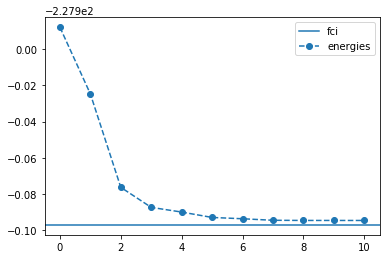

In [2]:
result.history.plot("energies", baselines={"fci":fci, "cisd": cisd})